In [1227]:
import os
import copy
from getdist import loadMCSamples, plots, mcsamples
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from copy import deepcopy
#from classy import Class

In [1228]:
from matplotlib import cm
cool = matplotlib.cm.get_cmap('cool')
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 24

In [1229]:
def combine_systematics(samples1, samples2, cosmo, truth1, truth2):
    shift1 = get_shifts(samples1, cosmo, truth1)
    shift2 = get_shifts(samples2, cosmo, truth2)
    sigma1 = get_sigmas(samples1, cosmo)
    sigma2 = get_sigmas(samples2, cosmo)
    systematics = []
    for i, (name, e1, e2, s1, s2) in enumerate(zip(cosmo, shift1, shift2, sigma1, sigma2)):
        err = s1*s2/np.sqrt(s1**2+s2**2)
        shift = abs(e1*s2**2 + e2*s1**2)/(s1**2+s2**2)
        sys = shift-err
        if sys < 0: 
            sys = 0.
        systematics.append((name, np.round(err, 4), np.round(sys, 4)))
        # systematics.append([np.round(err, 4), np.round(sys, 4)])
    return systematics

def get_systematics(samples, cosmo, truth, data_errors=None):
    systematics = []
    for i, name in enumerate(cosmo):
        stats = samples.getMargeStats().parWithName(name)
        lower = stats.limits[0].lower
        upper = stats.limits[0].upper
        err = stats.err
        if truth[name] - upper > 0: syst = upper - truth[name]
        elif lower - truth[name] > 0: syst = lower - truth[name]
        else: syst = 0.
        if data_errors is None: systematics.append( syst / err )
        else: systematics.append( syst / data_errors[name] )
    return np.array(systematics)

def get_phase_space(samples, samples_ref, cosmo):
    shifts = []
    allstats = samples.getMargeStats()
    allstats_ref = samples_ref.getMargeStats()
    for i, name in enumerate(cosmo):
        stats = allstats.parWithName(name)
        mean = stats.mean
        err = stats.err
        #lower = stats.limits[0].lower
        #upper = stats.limits[0].upper
        #if mean > truth[name]: err = upper-mean
        #else: err = mean-lower
        shift = (mean-allstats_ref.parWithName(name).mean) / err
        shifts.append(shift)
    return np.array( shifts )

def get_relative_shifts(samples1, samples2, cosmo):
    shifts = []
    allstats1 = samples1.getMargeStats()
    allstats2 = samples2.getMargeStats()
    for i, name in enumerate(cosmo):
        stats1 = allstats1.parWithName(name)
        stats2 = allstats2.parWithName(name)
        shift = 2. * (stats1.mean-stats2.mean) / (stats1.err + stats2.err)
        shifts.append(shift)
    return np.array( shifts )

def get_sigma_deviation(samples1, samples2, cosmo):
    shifts = []
    allstats1 = samples1.getMargeStats()
    allstats2 = samples2.getMargeStats()
    for i, name in enumerate(cosmo):
        stats1 = allstats1.parWithName(name)
        stats2 = allstats2.parWithName(name)
        shift = (stats1.mean-stats2.mean) / np.sqrt(stats1.err**2 + stats2.err**2)
        #print(stats1.mean-stats2.mean, np.sqrt(stats1.err**2 + stats2.err**2))
        shifts.append(shift)
    return np.array( shifts )

def get_relative_tension(samples1, samples2, cosmo):
    shifts = []
    allstats1 = samples1.getMargeStats()
    allstats2 = samples2.getMargeStats()
    for i, name in enumerate(cosmo):
        stats1 = allstats1.parWithName(name)
        stats2 = allstats2.parWithName(name)
        shift = (stats1.mean-stats2.mean) / np.sqrt(stats1.err**2 + stats2.err**2)
        shifts.append(shift)
    return np.array( shifts )

def get_relative_shifts_from_truth(samples, cosmo, truth, samples_ref=None):
    shifts = []
    allstats = samples.getMargeStats()
    if samples_ref is not None: allstats_ref = samples.getMargeStats()
    for i, name in enumerate(cosmo):
        stats = allstats.parWithName(name)
        mean = stats.mean
        # err = stats.err
        if samples_ref is not None: stats = allstats_ref.parWithName(name)
        lower = stats.limits[0].lower
        upper = stats.limits[0].upper
        if mean > truth[name]: err = upper-mean
        else: err = mean-lower
        shift = (mean-truth[name]) / err
        shifts.append(shift)
    return np.array( shifts )

def get_relative_shifts_from_truth_2(samples, cosmo, truth):
    shifts = []
    for i, name in enumerate(cosmo):
        ix = samples.getParamNames().list().index(name)
        mean = samples.mean(ix)
        lower = samples.confidence(ix, limfrac=0.31, upper=False)
        upper = samples.confidence(ix, limfrac=0.31, upper=True)
        err = upper - lower
        shift = (mean-truth[name]) / err
        shifts.append(shift)
    return np.array( shifts )

def get_shifts_from_truth_2(samples, cosmo, truth):
    shifts = []
    for i, name in enumerate(cosmo):
        ix = samples.getParamNames().list().index(name)
        mean = samples.mean(ix)
        lower = samples.confidence(ix, limfrac=0.31, upper=False)
        upper = samples.confidence(ix, limfrac=0.31, upper=True)
        err = upper - lower
        shift = (mean-truth[name])
        shifts.append(shift)
    return np.array( shifts )

def get_errors_2(samples, cosmo, truth):
    shifts = []
    for i, name in enumerate(cosmo):
        ix = samples.getParamNames().list().index(name)
        mean = samples.mean(ix)
        lower = samples.confidence(ix, limfrac=0.31, upper=False)
        upper = samples.confidence(ix, limfrac=0.31, upper=True)
        err = upper - lower
        shifts.append(err)
    return np.array(shifts)

def get_error_ratio(samples, samples_ref, cosmo):
    error_ratio = []
    for i, name in enumerate(cosmo):
        sigma = samples.getMargeStats().parWithName(name).err
        sigma_ref = samples_ref.getMargeStats().parWithName(name).err
        error_ratio.append( sigma / sigma_ref )
    return np.array(error_ratio)

def get_errors(samples, cosmo):
    errors = {}
    for i, name in enumerate(cosmo):
        errors[name] = samples.getMargeStats().parWithName(name).err
    return errors

def get_means(samples, cosmo):
    means = {}
    for i, name in enumerate(cosmo):
        means[name] = samples.getMargeStats().parWithName(name).mean
    return means

def get_Omega_m(samples, nu=False):
    p=samples.getParams()
    if nu: samples.addDerived((p.omega_b*1e-2+p.omega_cdm)/p.h**2 + p.M_tot_NH/93.14/p.h**2, name='Omega_m', label=r'\Omega_m')
    else: samples.addDerived((p.omega_b*1e-2+p.omega_cdm)/p.h**2, name='Omega_m', label=r'\Omega_m')

        
def resample_nu(samples):
    p=samples.getParams()
    weights = - np.log( np.heaviside( 0.09 - p.M_tot_NH, 0 ) + 1e-16 )
    samples.reweightAddingLogLikes(weights)

def resampleBBN(samples, truth=2.14394):
    p=samples.getParams()
    weights = 0.5 * ((p.omega_b-truth)/0.035)**2 - 0.5 * ((p.omega_b-truth)/0.05)**2 # chi2 = - log(L) = - Log(exp(-p^2/(2s^2))) = (p/s)^2 /2 
    samples.reweightAddingLogLikes(weights)
    
def resample_ns(samples, truth=.96):
    p=samples.getParams()
    weights = 0.5 * ((p.n_s-truth)/0.02)**2 
    samples.reweightAddingLogLikes(weights)
    
def prior(bs, prior_mean, prior_sigma, prior_type='gauss'):
        if 'gauss' in prior_type: 
            prior = - 0.5 * (bs - prior_mean)**2 / prior_sigma**2
        elif 'lognormal'in prior_type:
            prior = - 0.5 * (np.log(bs) - prior_mean)**2 / prior_sigma**2 #- np.log(bs)     
        return prior

def set_prior_nongauss(samples, log_b1_mean=0.8, log_b1_sigma=0.8944, b1type='lognormal', prior_sigma=2., invprior=False): # Prior for non-Gaussian parameter: Log-normal prior on b1 and Gaussian prior on c2
    p = samples.getParams()
    b1, c2 = p.b1_hN, p.c2_hN
    prior1 = 0. * prior(b1, log_b1_mean, log_b1_sigma, prior_type='lognormal')
    prior2 = prior(c2, 0., prior_sigma)
    try:
        c4 = p.c4_hN
        prior4 = prior(c4, 0., prior_sigma)
    except:
        prior4 = 0.
    weights = - ( prior1 + prior2 + prior4 )
#     b1, c2, c4 = p.b1_hS, p.c2_hS, p.c4_hS
#     prior1 = prior(b1, log_b1_mean, log_b1_sigma, prior_type='lognormal')
#     prior2 = prior(c2, 0., prior_sigma)
#     prior4 = prior(c4, 0., prior_sigma)
#     weights += - ( prior1 + prior2 + prior4 )
    if invprior: weights = -weights
    samples.reweightAddingLogLikes(weights)
    

In [1230]:
def weighting_A_s(samples):
    p=samples.getParams()
    try:
        weights = 0.
#         for c2 in [p.c2_hN, p.c2_hS, p.c2_lN, p.c2_lS]:
#             weights += 0. * np.log(c2 + 4)
        for c4 in [p.c4_hN, p.c4_hS, p.c4_lN, p.c4_lS]:
            weights += 2. * np.log(c4 + 4.01)
    except: 
        weights = 0.
#         for c2 in [p.c2_hN]: #, p.c2_hS, p.c2_lN, p.c2_lS]:
#             weights += 0. * np.log(c2 + 4)
        for c4 in [p.c4_hN]: #, p.c2_hS, p.c2_lN, p.c2_lS]:
            weights -= 2. * np.log(c4 + 4.01)
    samples.reweightAddingLogLikes(weights)

load chain

In [1231]:
def get_relative_posteriors(samples, truth, doBBN=False):
    p=samples.getParams()
    # if doBBN: resampleBBN(samples, truth=truth['omega_b']*100.)
    samples.addDerived(p.h/truth['h']-1, name='rh', label=r'\Delta h/h')
    try: samples.addDerived(np.log(1e10*p.A_s)/truth['ln10^{10}A_s']-1, name='rlnA_s', label=r'\Delta \ln 10^{10}A_s/\ln10^{10}A_s')
    except: samples.addDerived(p.lnA_s/truth['ln10^{10}A_s']-1, name='rlnA_s', label=r'\Delta ln10^{10}A_s/ln10^{10}A_s')
    # samples.addDerived(np.exp(p.lnA_s)/ np.exp(truth['ln10^{10}A_s'])-1, name='rA_s', label=r'\Delta A_s/A_s')
    samples.addDerived(p.omega_cdm/truth['omega_cdm']-1, name='romega_cdm', label=r'\Delta \omega_{cdm}/\omega_{cdm}')
    # samples.addDerived(p.n_s/truth['n_s']-1, name='rn_s', label=r'\Delta n_s/n_s')
    samples.addDerived(p.Omega_m/truth['Omega_m']-1, name='rOmega_m', label=r'\Delta \Omega_m/\Omega_m')
    samples.addDerived(p.sigma8/truth['sigma8']-1, name='rsigma8', label=r'\Delta \sigma_8/\sigma_8')
    # samples.addDerived((p.omega_b*1e-2+p.omega_cdm)/p.h**2/truth['Omega_m']-1, name='rOmega_m', label=r'\Delta \Omega_m/\Omega_m')

def weighting_A_s(samples, ps=False):
    p=samples.getParams()
    weights = 0.
    samples.reweightAddingLogLikes(weights)
    
def load_chain(chainname, truth=None, basedir='./', doBBN=False, add_Omega_m=False, sample_A_s_ps=False, 
               sample_A_s=False, fix_ns=False, process_ng=False, cutnu=False):
    try: 
        chains = os.path.join(basedir, chainname)
        samples = loadMCSamples(chains, settings={'ignore_rows':0});
    except: 
        chains = os.path.join(basedir, chainname, chainname)
        samples = loadMCSamples(chains, settings={'ignore_rows':0});
    if cutnu: resample_nu(samples)
    if doBBN: resampleBBN(samples)
    if truth is not None: get_relative_posteriors(samples, truth)
    if add_Omega_m: get_Omega_m(samples)
    if sample_A_s: weighting_A_s(samples)
    if sample_A_s_ps:
        weighting_A_s(samples, ps=True)
    if fix_ns: resample_ns(samples)
    if process_ng: set_prior_nongauss(samples)
    return samples

In [1232]:
def get_bestfit_from_montepython(pathdir, run):
    #run = 'bossede'
    #fitdir = os.path.join(os.path.expanduser('~'), 'Documents', 'github', 'montepython_public-3.3', 'local',  run)
    #configfile = os.path.join(fitdir, 'config_cmass.yaml')
    values = np.loadtxt(open(os.path.join(pathdir, run + '.bestfit'), 'r')) # the values
    l = [] # the keys
    with open(os.path.join(pathdir, run + '.bestfit'), 'r') as f:
        for line in f:
            line = line.replace(' ', '')
            line = line.replace('#', '')
            line = line.replace('\n', '')
            l.append(line.split(','))

    bestfit = {}
    for (key, value) in list(zip(l[0], values)):
        bestfit[key] = value
    return bestfit

truth

In [1233]:
n_truth = {'omega_b': 0.02303, 'omega_cdm': 0.11711, 'h': 0.7, 
           'ln10^{10}A_s': 3.06652, 'n_s': 0.96, 'Omega_m': 0.286}
p_truth = {'omega_b': 0.02214, 'omega_cdm': 0.118911, 'h': 0.6777, 
               'ln10^{10}A_s': 3.06652, 'n_s': 0.9611, 'Omega_m': 0.307115}

# p_truth.update({'sigma8': 0.8288}) # BOSS MDmock
p_truth.update({'sigma8': 0.8225})# eBOSS EZmock # https://arxiv.org/pdf/2007.08999v1.pdf
p_truth.update({'S8': 0.8225*np.sqrt(0.307115/0.3)})

pt_truth = {'omega_b': 0.0214394, 'omega_cdm': 0.11503, 'h': 0.654083, 'ln10^{10}A_s': 3.05147, 'n_s': 0.965,}
pt_truth.update({'Omega_m': 0.318986, 'sigma8': 0.8049})

cola_truth = {'omega_b': 0.02210, 'omega_cdm': 0.1166, 'h': 0.68, 'ln10^{10}A_s': 3.069, 'n_s': 0.96}
cola_truth.update({'Omega_m': 0.300, 'sigma8': 0.82})

planck_truth = {'omega_b': 2.2237, 'omega_cdm': 0.120, 'h': 0.6736, 
               'ln10^{10}A_s': 3.044, 'n_s': 0.965, 'Omega_m': 0.3153} 

In [1234]:
def load_multi(runs, labels):
    chains = []
    for run in runs :
        chains.append(load_chain(run, truth=None, basedir=basedir))
    return chains, labels

In [1235]:
matplotlib.style.use('default')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

rec = plots.getSinglePlotter(ratio=1,width_inch=8)
rec.settings.axes_fontsize = 24
rec.settings.lab_fontsize = 24
rec.settings.legend_fontsize = 18


tri = plots.getSubplotPlotter(width_inch=8)
tri.settings.axes_fontsize = 24
tri.settings.lab_fontsize = 24
tri.settings.legend_fontsize = 18
tri.settings.scaling = True
#tri.settings.alpha_filled_add=0.6

oneD = plots.get_subplot_plotter(width_inch=15)
oneD.settings.axes_fontsize = 24
oneD.settings.lab_fontsize = 24
oneD.settings.legend_fontsize = 18
oneD.settings.scaling = True

<Figure size 800x800 with 0 Axes>

# BEST-FIT

In [1236]:
basedir = './eBOSS_LCDM_real_analysis'

## Planck

In [1237]:
chainname = "base_mnu_plikHM_TTTEEE_lowl_lowE_lensing"
chains = os.path.join('./plikHM_TTTEEE_lowl_lowE_lensing', chainname)
planck = loadMCSamples(chains, settings={'ignore_rows':0.0});
p=planck.getParams()
planck.addDerived(p.H0/100., name='h', label=r'h')
planck.addDerived(p.logA, name='ln10^{10}A_s', label=r'\ln 10^{10}A_s')
planck.addDerived(np.exp(planck.getParams().logA)*1e-10, name='A_s', label=r'A_s')
planck.addDerived(p.omegabh2 * 100., name='omega_b', label=r'\omega_b')
planck.addDerived(p.omegach2, name='omega_cdm', label=r'\omega_{cdm}')
planck.addDerived(p.ns, name='n_s', label=r'n_s')
planck.addDerived(p.omeganuh2 * 93.14, name='M_nu', label=r'\sum m_\nu', range=[0.06, .25])


cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
planck_mean = get_means(planck, cosmo)
planck_error = get_errors(planck,cosmo)

planck_mean_paper = {'Omega_m': 0.3153, 'h': 0.6736, 'sigma8': 0.8111,
 'omega_cdm': 0.1200, 'ln10^{10}A_s': 3.044, 'S8': 0.832, 'n_s': 0.9649}
planck_error_paper = {'Omega_m': 0.0073, 'h': 0.0054, 'sigma8': 0.0060, 
 'omega_cdm': 0.0012, 'ln10^{10}A_s': 0.014, 'S8': 0.013, 'n_s': 0.0042 }
planck_bestfit_paper = {'Omega_m': 0.3158, 'h': 0.6732, 'sigma8': 0.8120,
 'omega_cdm': 0.12011 , 'ln10^{10}A_s': 3.0448, 'S8': 0.8331, 'n_s': 0.96605}


#with np.printoptions(precision=4):
#    for i in cosmo:
#        print(i,':',planck_mean[i])

## BOSS

In [1238]:
BOSS_chain, BOSS_label = load_multi(
    ["LCDM_BOSS_BAO_data_220421",],
    ["BOSS", ])

#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s']
boss_bestfit = get_bestfit_from_montepython("minimization/LCDM_BOSS_BAO_data_220421", "LCDM_BOSS_BAO_data_220421")
boss_bestfit['S8'] = boss_bestfit['sigma8']*np.sqrt(boss_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = BOSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
boss_error = get_errors(BOSS_chain[0],cosmo)
boss_mean = get_means(BOSS_chain[0],cosmo)


#for i in cosmo:
#    stats = sample.getMargeStats().parWithName(i)
#    mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#    err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#    #print(i,':', r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
#    print(i,':', r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))


#Shift
boss_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',boss_bestfit[i])
        #print(i,':',boss_mean[i])
        boss_shift[i] = boss_mean[i] - boss_bestfit[i]

## eBOSS / kmax 0.24 /model 1

In [1242]:
eBOSS_0p24_model_1_chain, eBOSS_0p24_model_1_label = load_multi(
    ["LCDM_eBOSS_data_kmax_0p24_priors_16_model_1",],
    ["eBOSS",])

#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s']
eboss_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_data_kmax_0p24_priors_16_model_1", "LCDM_eBOSS_data_kmax_0p24_priors_16_model_1")
eboss_bestfit['S8'] = eboss_bestfit['sigma8']*np.sqrt(eboss_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = eBOSS_0p24_model_1_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
eboss_error = get_errors(eBOSS_0p24_model_1_chain[0],cosmo)
eboss_mean = get_means(eBOSS_0p24_model_1_chain[0],cosmo)

#for i in cosmo:
#    stats = sample.getMargeStats().parWithName(i)
#    mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#    err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#    #print(i,':', r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
#    print(i,':', r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))

print(eboss_error)

#Shift
eboss_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',eboss_bestfit[i])
        #print(i,':',eboss_mean[i])
        print(i,':',eboss_error[i]/eboss_bestfit[i])
        #eboss_shift[i] = eboss_mean[i] - eboss_bestfit[i]   

{'Omega_m': 0.036721304113337024, 'h': 0.034012976475434185, 'sigma8': 0.08374096267191197, 'omega_cdm': 0.007959189420569257, 'ln10^{10}A_s': 0.20340079170446285, 'S8': 0.1098076417793537}
Omega_m : 0.11078573048809465
h : 0.05264074708254663
sigma8 : 0.08879220939697059
omega_cdm : 0.06896578412004437
ln10^{10}A_s : 0.05953451208802376
S8 : 0.11076765720378826


## eBOSS CF

In [1243]:
eBOSS_cf_chain, eBOSS_cf_label = load_multi(
    ["LCDM_eBOSS_data_cf_prior_16",],
    ["eBOSS CF",])

#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s']
ebossCF_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_data_cf_prior_16", "LCDM_eBOSS_data_cf_prior_16")
ebossCF_bestfit['S8'] = ebossCF_bestfit['sigma8']*np.sqrt(ebossCF_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = eBOSS_cf_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
ebossCF_error = get_errors(eBOSS_cf_chain[0],cosmo)
ebossCF_mean = get_means(eBOSS_cf_chain[0],cosmo)


#for i in cosmo:
#    stats = sample.getMargeStats().parWithName(i)
#    mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#    err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#    #print(i,':', r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
#    print(i,':', r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))


#Shift
ebossCF_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',ebossCF_bestfit[i])
        #print(i,':',ebossCF_mean[i])
        ebossCF_shift[i] = ebossCF_mean[i] - ebossCF_bestfit[i]

In [1244]:
# smin = 27,50 ; smax = 157.5   
##### correspondance : kmin = 0.04 ; kmax = 0.228
ebossCF_25_200_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_data_cf_prior_16_smin_25", "LCDM_eBOSS_data_cf_prior_16_smin_25")
ebossCF_25_200_bestfit['S8'] = ebossCF_25_200_bestfit['sigma8']*np.sqrt(ebossCF_25_200_bestfit['Omega_m']/0.3)

# kmin = 0.01 ; kmax = 0.24 (real analysis)

# kmin = 0.02 ; kmax = 0.24
eboss_0p02_0p24_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_kmax_0.24_kmin_0.02", "LCDM_eBOSS_kmax_0.24_kmin_0.02")
eboss_0p02_0p24_bestfit['S8'] = eboss_0p02_0p24_bestfit['sigma8']*np.sqrt(eboss_0p02_0p24_bestfit['Omega_m']/0.3)

# kmin = 0.03 ; kmax = 0.24
eboss_0p03_0p24_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_kmax_0.24_kmin_0.03", "LCDM_eBOSS_kmax_0.24_kmin_0.03")
eboss_0p03_0p24_bestfit['S8'] = eboss_0p03_0p24_bestfit['sigma8']*np.sqrt(eboss_0p03_0p24_bestfit['Omega_m']/0.3)

# kmin = 0.04 ; kmax = 0.24
eboss_0p04_0p24_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_kmax_0.24_kmin_0.04", "LCDM_eBOSS_kmax_0.24_kmin_0.04")
eboss_0p04_0p24_bestfit['S8'] = eboss_0p04_0p24_bestfit['sigma8']*np.sqrt(eboss_0p04_0p24_bestfit['Omega_m']/0.3)




# kmin = 0.04 ; kmax = 0.22
eboss_0p04_0p22_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_kmax_0.22_kmin_0.04", "LCDM_eBOSS_kmax_0.22_kmin_0.04")
eboss_0p04_0p22_bestfit['S8'] = eboss_0p04_0p22_bestfit['sigma8']*np.sqrt(eboss_0p04_0p22_bestfit['Omega_m']/0.3)

# kmin = 0.04 ; kmax = 0.23
eboss_0p04_0p23_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_kmax_0.23_kmin_0.04", "LCDM_eBOSS_kmax_0.23_kmin_0.04")
eboss_0p04_0p23_bestfit['S8'] = eboss_0p04_0p23_bestfit['sigma8']*np.sqrt(eboss_0p04_0p23_bestfit['Omega_m']/0.3)





# kmin = 0.02 ; kmax = 0.11
eboss_0p02_0p11_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_kmax_0.11_kmin_0.02", "LCDM_eBOSS_kmax_0.11_kmin_0.02")
eboss_0p02_0p11_bestfit['S8'] = eboss_0p02_0p11_bestfit['sigma8']*np.sqrt(eboss_0p02_0p11_bestfit['Omega_m']/0.3)

In [1245]:
for i in cosmo:
    print(i,':', 2*(eboss_bestfit[i] - eboss_0p02_0p24_bestfit[i])/(eboss_error[i] + eboss_error[i]))

Omega_m : 0.8509174920247796
h : -0.1641314750572334
sigma8 : -0.022570793787087234
omega_cdm : 1.3657169625726235
ln10^{10}A_s : -0.632072269348886
S8 : 0.4188402609853747


In [1246]:
for i in cosmo:
    print(i,':', 2*(eboss_bestfit[i] - eboss_0p03_0p24_bestfit[i])/(eboss_error[i] + eboss_error[i]))

Omega_m : 1.5073865522084207
h : -0.2863965759372918
sigma8 : 0.6456278776233189
omega_cdm : 2.4634908109270306
ln10^{10}A_s : -0.5995551884438622
S8 : 1.2605801214674184


In [1247]:
for i in cosmo:
    print(i,':', 2*(eboss_0p03_0p24_bestfit[i] - eboss_0p04_0p24_bestfit[i])/(eboss_error[i] + eboss_error[i]))

Omega_m : 0.024397281677003894
h : 0.11547063523936528
sigma8 : 0.2785279659535513
omega_cdm : 0.22603055473849107
ln10^{10}A_s : 0.12201034121862553
S8 : 0.21605726597269476


In [1248]:
for i in cosmo:
    print(i,':', 2*(ebossCF_bestfit[i] - ebossCF_25_200_bestfit[i])/(eboss_error[i] + eboss_error[i]))

Omega_m : 0.0007815626566914027
h : 0.0019374958274395147
sigma8 : 0.5135157111637038
omega_cdm : 0.004799483713915192
ln10^{10}A_s : 0.4674809729263897
S8 : 0.3957816076360208


In [1249]:
# kmin = 0.015 ; kmax = 0.235
#(smin = 419, smin = 25,6)

for i in cosmo:
    print(i,':', 2*(eboss_bestfit[i] - ebossCF_25_200_bestfit[i])/(eboss_error[i] + ebossCF_error[i]))

Omega_m : 0.7131905654689028
h : -0.05854493630432642
sigma8 : 0.7627135087995551
omega_cdm : 1.0983830775605692
ln10^{10}A_s : 0.11606726298554385
S8 : 0.9631835535206009


In [1250]:
# kmin = 0.025 ; kmax = 0.245
# (smax = 251, smin = 25.6)

for i in cosmo:
    print(i,':', 2*(eboss_0p02_0p24_bestfit[i] - ebossCF_25_200_bestfit[i])/(eboss_error[i] + ebossCF_error[i]))

Omega_m : -0.15527537819825818
h : 0.11851393005491319
sigma8 : 0.785212569307436
omega_cdm : -0.09767635293975566
ln10^{10}A_s : 0.7135954573744185
S8 : 0.5365604187909369


In [1251]:
# kmin = 0.035 ; kmax = 0.245
# (smax = 180, smin = 25.6)

for i in cosmo:
    print(i,':', 2*(eboss_0p03_0p24_bestfit[i] - ebossCF_25_200_bestfit[i])/(eboss_error[i] + ebossCF_error[i]))

Omega_m : -0.8252827845380465
h : 0.25040892551250227
sigma8 : 0.11913753086775167
omega_cdm : -1.0590781659534838
ln10^{10}A_s : 0.682855503128378
S8 : -0.3208206196529748


In [1252]:
# kmin = 0.045 ; kmax = 0.245
# (smax = 140, smin = 25.6)

for i in cosmo:
    print(i,':', 2*(eboss_0p04_0p24_bestfit[i] - ebossCF_25_200_bestfit[i])/(eboss_error[i] + ebossCF_error[i]))

Omega_m : -0.8501832107874997
h : 0.12584354421599
sigma8 : -0.15850523252992121
omega_cdm : -1.2570298528586072
ln10^{10}A_s : 0.5675132829100527
S8 : -0.5408926534959927


In [1253]:
# kmin = 0.045 ; kmax = 0.235
# (smax = 140, smin = 26.7)

for i in cosmo:
    print(i,':', 2*(eboss_0p04_0p23_bestfit[i] - ebossCF_25_200_bestfit[i])/(eboss_error[i] + ebossCF_error[i]))

Omega_m : -0.9803636064423593
h : 0.09887208648090191
sigma8 : -0.3916224492212141
omega_cdm : -1.5090671931646638
ln10^{10}A_s : 0.5158679288758825
S8 : -0.7791305593802249


In [1254]:
# kmin = 0.045 ; kmax = 0.225
# (smax = 140, smin = 27.8)

for i in cosmo:
    print(i,':', 2*(eboss_0p04_0p22_bestfit[i] - ebossCF_25_200_bestfit[i])/(eboss_error[i] + ebossCF_error[i]))

Omega_m : -0.8646859928133565
h : 0.06127570125139534
sigma8 : -0.4377740324681899
omega_cdm : -1.3615425602065485
ln10^{10}A_s : 0.3825297753583918
S8 : -0.7564296221881104


In [1255]:
# smin = 
ebossCF_25_140_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_data_cf_smin_25_smax_140", "LCDM_eBOSS_data_cf_smin_25_smax_140")
ebossCF_25_140_bestfit['S8'] = ebossCF_25_140_bestfit['sigma8']*np.sqrt(ebossCF_25_140_bestfit['Omega_m']/0.3)


ebossCF_25_145_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_data_cf_smin_25_smax_145", "LCDM_eBOSS_data_cf_smin_25_smax_145")
ebossCF_25_145_bestfit['S8'] = ebossCF_25_145_bestfit['sigma8']*np.sqrt(ebossCF_25_145_bestfit['Omega_m']/0.3)




In [1256]:
for i in cosmo:
    print(i,':', 2*(eboss_0p04_0p22_bestfit[i] - ebossCF_25_140_bestfit[i])/(eboss_error[i] + ebossCF_error[i]))

Omega_m : -0.927624953904868
h : -0.02560448945147889
sigma8 : -0.46718077236484695
omega_cdm : -1.586747236968739
ln10^{10}A_s : 0.48233005318198335
S8 : -0.810076230628989


In [1257]:
for i in cosmo:
    print(i,':', 2*(eboss_0p04_0p22_bestfit[i] - ebossCF_25_145_bestfit[i])/(eboss_error[i] + ebossCF_error[i]))

Omega_m : -0.9894910760040505
h : -0.07769517875545975
sigma8 : -0.2965088345044634
omega_cdm : -1.7635373645662435
ln10^{10}A_s : 0.7300669417784044
S8 : -0.7046970274481293


In [1258]:
for i in cosmo:
    print(i,':', eboss_0p04_0p22_bestfit[i])

Omega_m : 0.2746915
h : 0.6499119
sigma8 : 0.8422611
omega_cdm : 0.09305156
ln10^{10}A_s : 3.473851
S8 : 0.8059511629073147


In [1259]:
# kmin = 0.02 ; kmax = 0.11

for i in cosmo:
    print(i,':', 2*(eboss_0p02_0p11_bestfit[i] - ebossCF_25_200_bestfit[i])/(eboss_error[i] + ebossCF_error[i]))

Omega_m : 1.1617762330444383
h : -1.0249788263362651
sigma8 : 1.362077005625397
omega_cdm : 0.36923796052713204
ln10^{10}A_s : 1.0533570048870193
S8 : 1.6871565086840212


## eBOSS + BOSS

In [1269]:
BOSS_eBOSS_chain, BOSS_eBOSS_label = load_multi(
    ["LCDM_eBOSS_model_1_BOSS_BAO_data_220421"],
    ["BOSS + eBOSS", ])


#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s']
BOSS_eBOSS_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_model_1_BOSS_BAO_data_220421", "LCDM_eBOSS_model_1_BOSS_BAO_data_220421")
BOSS_eBOSS_bestfit['S8'] = BOSS_eBOSS_bestfit['sigma8']*np.sqrt(BOSS_eBOSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = BOSS_eBOSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
BOSS_eBOSS_error = get_errors(BOSS_eBOSS_chain[0],cosmo)
BOSS_eBOSS_mean = get_means(BOSS_eBOSS_chain[0],cosmo)


#for i in cosmo:
#    stats = sample.getMargeStats().parWithName(i)
#    mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#    err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#    print(i,':', r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))


#Shift
BOSS_eBOSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',BOSS_eBOSS_bestfit[i])
        #print(i,':',BOSS_eBOSS_mean[i])
        #print(i,':',BOSS_eBOSS_error[i]/BOSS_eBOSS_bestfit[i])
        print(i,':',BOSS_eBOSS_error[i]/planck_error_paper[i])
        #BOSS_eBOSS_shift[i] = BOSS_eBOSS_mean[i] - BOSS_eBOSS_bestfit[i]

Omega_m : 1.0592828924951685
h : 1.5105111426366393
sigma8 : 6.2675216808139504
omega_cdm : 3.409251253124608
ln10^{10}A_s : 7.628562233368456
S8 : 2.995305294005774


## eBOSS + BOSS + BAOSmallZ + Lya + Pan

In [1272]:
BOSS_eBOSS_BAO_Lya_Pan_chain, BOSS_eBOSS_BAO_Lya_Pan_label = load_multi(
    ["LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_220430"],
    ["BOSS + eBOSS + ext-BAO + Pantheon", ])

#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s']
BOSS_eBOSS_BAO_Lya_Pan_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_220430", "LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_220430")
BOSS_eBOSS_BAO_Lya_Pan_bestfit['S8'] = BOSS_eBOSS_BAO_Lya_Pan_bestfit['sigma8']*np.sqrt(BOSS_eBOSS_BAO_Lya_Pan_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = BOSS_eBOSS_BAO_Lya_Pan_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
BOSS_eBOSS_BAO_Lya_Pan_error = get_errors(BOSS_eBOSS_BAO_Lya_Pan_chain[0],cosmo)
BOSS_eBOSS_BAO_Lya_Pan_mean = get_means(BOSS_eBOSS_BAO_Lya_Pan_chain[0],cosmo)


#for i in cosmo:
#    stats = sample.getMargeStats().parWithName(i)
#    mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#    err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#    print(i,':', r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))

print(BOSS_eBOSS_BAO_Lya_Pan_error)

#Shift
BOSS_eBOSS_BAO_Lya_Pan_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',BOSS_eBOSS_BAO_Lya_Pan_bestfit[i])
        #print(i,':',BOSS_eBOSS_BAO_Lya_Pan_mean[i])
        print(i,':',BOSS_eBOSS_BAO_Lya_Pan_error[i]/planck_error_paper[i])
        BOSS_eBOSS_BAO_Lya_Pan_shift[i] = BOSS_eBOSS_BAO_Lya_Pan_mean[i] - BOSS_eBOSS_BAO_Lya_Pan_bestfit[i]

{'Omega_m': 0.0068869468851617665, 'h': 0.007574879625033622, 'sigma8': 0.036723861759625984, 'omega_cdm': 0.003650745291316364, 'ln10^{10}A_s': 0.10245370338558954, 'S8': 0.03828744880470484}
Omega_m : 0.9434173815290091
h : 1.4027554861173372
sigma8 : 6.1206436266043305
omega_cdm : 3.0422877427636372
ln10^{10}A_s : 7.318121670399253
S8 : 2.94518836959268


## eBOSS + BOSS + BAOSmallZ + Lya + Pan + BBN [$n_s + \omega_b$]

In [1262]:
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_chain, ns_ob_BOSS_eBOSS_BAO_Lya_Pan_label = load_multi(
    ["LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_ns_omega_b_220921"],
    ["BOSS + eBOSS + ext-BAO + Pantheon + BBN [$n_s + \omega_b$]", ])

#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s']
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_ns_omega_b_220921", "LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_ns_omega_b_220921")
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_bestfit['S8'] = ns_ob_BOSS_eBOSS_BAO_Lya_Pan_bestfit['sigma8']*np.sqrt(ns_ob_BOSS_eBOSS_BAO_Lya_Pan_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = ns_ob_BOSS_eBOSS_BAO_Lya_Pan_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s']
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_error = get_errors(ns_ob_BOSS_eBOSS_BAO_Lya_Pan_chain[0],cosmo)
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_mean = get_means(ns_ob_BOSS_eBOSS_BAO_Lya_Pan_chain[0],cosmo)


#for i in cosmo:
#    stats = sample.getMargeStats().parWithName(i)
#    mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#   err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#    #print(i,':', r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
#    print(i,':', r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))


#Shift
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',ns_ob_BOSS_eBOSS_BAO_Lya_Pan_bestfit[i])
        #print(i,':',ns_ob_BOSS_eBOSS_BAO_Lya_Pan_mean[i])
        ns_ob_BOSS_eBOSS_BAO_Lya_Pan_shift[i] = ns_ob_BOSS_eBOSS_BAO_Lya_Pan_mean[i] - ns_ob_BOSS_eBOSS_BAO_Lya_Pan_bestfit[i]

## BOSS + BAOSmallZ + Lya + Pan + BBN [$n_s + \omega_b$]

In [1263]:
ns_ob_BOSS_BAO_Lya_Pan_chain, ns_ob_BOSS_BAO_Lya_Pan_label = load_multi(
    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_ns_omega_b_221018"],
    ["BOSS + ext-BAO + Pantheon + BBN [$n_s + \omega_b$]", ])

#Bestfit
#cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s']
#ns_ob_BOSS_BAO_Lya_Pan_bestfit = get_bestfit_from_montepython("minimization/", "")
#ns_ob_BOSS_BAO_Lya_Pan_bestfit['S8'] = ns_ob_BOSS_BAO_Lya_Pan_bestfit['sigma8']*np.sqrt(ns_ob_BOSS_BAO_Lya_Pan_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = ns_ob_BOSS_BAO_Lya_Pan_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s']
ns_ob_BOSS_BAO_Lya_Pan_error = get_errors(ns_ob_BOSS_BAO_Lya_Pan_chain[0],cosmo)
ns_ob_BOSS_BAO_Lya_Pan_mean = get_means(ns_ob_BOSS_BAO_Lya_Pan_chain[0],cosmo)

for i in cosmo:
    stats = sample.getMargeStats().parWithName(i)
    mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
    err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
    #print(i,':', r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
    print(i,':', r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
    #print(i,':', r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))

#Shift
#ns_ob_BOSS_BAO_Lya_Pan_shift = {}
#with np.printoptions(precision=4):
#    for i in cosmo:
        #print(i,':',ns_ob_BOSS_BAO_Lya_Pan_error[i]/ns_ob_BOSS_eBOSS_BAO_Lya_Pan_error[i])
        #print(i,':',ns_ob_BOSS_BAO_Lya_Pan_bestfit[i])
        #print(i,':',ns_ob_BOSS_BAO_Lya_Pan_mean[i])
        #ns_ob_BOSS_BAO_Lya_Pan_shift[i] = ns_ob_BOSS_BAO_Lya_Pan_mean[i] - ns_ob_BOSS_BAO_Lya_Pan_bestfit[i]

Omega_m : $0.302^{+0.010}_{-0.011}$
h : $0.684^{+0.009}_{-0.009}$
sigma8 : $0.757^{+0.045}_{-0.045}$
omega_cdm : $0.118^{+0.006}_{-0.007}$
ln10^{10}A_s : $2.938^{+0.139}_{-0.138}$
S8 : $0.759^{+0.044}_{-0.044}$
n_s : $0.943^{+0.043}_{-0.043}$


## BOSS + BAOSmallZ + Lya + Pan

In [1264]:
BOSS_BAO_Lya_Pan_chain, BOSS_BAO_Lya_Pan_label = load_multi(
    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_220701"],
    ["BOSS + ext-BAO + Pantheon", ])

#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s']
BOSS_BAO_Lya_Pan_bestfit = get_bestfit_from_montepython("minimization/LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_220701", "LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_220701")
BOSS_BAO_Lya_Pan_bestfit['S8'] = BOSS_BAO_Lya_Pan_bestfit['sigma8']*np.sqrt(BOSS_BAO_Lya_Pan_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = BOSS_BAO_Lya_Pan_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
BOSS_BAO_Lya_Pan_error = get_errors(BOSS_BAO_Lya_Pan_chain[0],cosmo)
BOSS_BAO_Lya_Pan_mean = get_means(BOSS_BAO_Lya_Pan_chain[0],cosmo)


#for i in cosmo:
#    stats = sample.getMargeStats().parWithName(i)
#    mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#    err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#    print(i,':', r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))


#Shift
BOSS_BAO_Lya_Pan_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',BOSS_BAO_Lya_Pan_bestfit[i])
        #print(i,':',BOSS_BAO_Lya_Pan_mean[i])
        BOSS_BAO_Lya_Pan_shift[i] = BOSS_BAO_Lya_Pan_mean[i] - BOSS_BAO_Lya_Pan_bestfit[i]

## eBOSS + BOSS + BBN [$n_s + \omega_b$]

In [1265]:
basedir = './eBOSS_LCDM_alternative'
ns_chain, ns_label = load_multi(
    ["LCDM_eBOSS_BOSS_BBN_ns_omegab_220504"],
    ["eBOSS + BOSS + BBN [$n_s + \omega_b$]", ])
basedir = './eBOSS_LCDM_real_analysis'

#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s',]
ns_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_BOSS_BBN_ns_omegab_220504", "LCDM_eBOSS_BOSS_BBN_ns_omegab_220504")
ns_bestfit['S8'] = ns_bestfit['sigma8']*np.sqrt(ns_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = ns_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','n_s','omega_b','S8']
ns_error = get_errors(ns_chain[0],cosmo)
ns_mean = get_means(ns_chain[0],cosmo)


#for i in cosmo:
#    stats = sample.getMargeStats().parWithName(i)
#    mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#    err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#    #print(i,':', r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
#    print(i,':', r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))
    

#Shift
ns_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',ns_bestfit[i])
        #print(i,':',ns_mean[i])
        ns_shift[i] = ns_mean[i] - ns_bestfit[i]

## eBOSS + BOSS + BBN [$\omega_b$]

In [1107]:
ob_chain, ob_label = load_multi(
    ["LCDM_eBOSS_BOSS_BBN_omegab_220921"],
    ["eBOSS + BOSS + BBN [$\omega_b$]", ])

#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s',]
ob_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_BOSS_BBN_omegab_220921", "LCDM_eBOSS_BOSS_BBN_omegab_220921")
ob_bestfit['S8'] = ob_bestfit['sigma8']*np.sqrt(ob_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = ob_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','omega_b','S8']
ob_error = get_errors(ob_chain[0],cosmo)
ob_mean = get_means(ob_chain[0],cosmo)

#Shift
ob_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',ob_bestfit[i])
        #print(i,':',ob_mean[i])
        ob_shift[i] = ob_mean[i] - ob_bestfit[i]

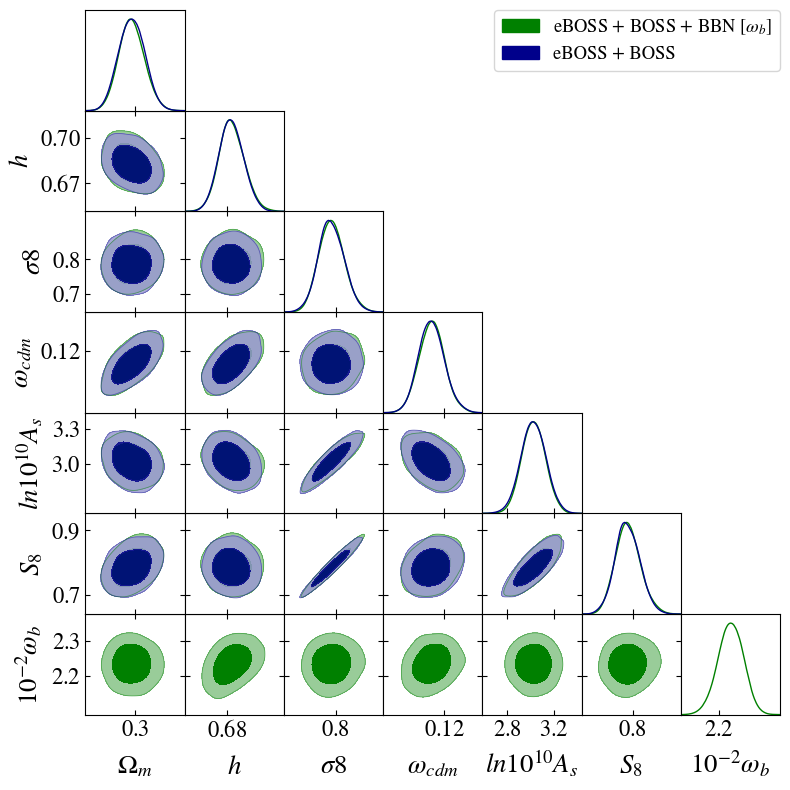

In [1108]:
tri.settings.axes_fontsize = 21
tri.triangle_plot([ob_chain[0], BOSS_eBOSS_chain[0]],
                ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','omega_b',],
                #['Om', 'hub', 's8', 'n'],
                filled=True,
                legend_labels=["eBOSS + BOSS + BBN [$\omega_b$]", "eBOSS + BOSS"],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'color':'green'},
                           {'lw':1, 'color':'darkblue'},
                           {'lw':1, 'color':'red'},],
                #markers={'n':0.965,'ob': 2.233,},
                contour_colors=['green','darkblue','red'],
               )
plt.show()
tri.settings.axes_fontsize = 24

## eBOSS + BOSS [$n_s$]

In [1109]:
ns_alone_chain, ns_alone_label = load_multi(
    ["LCDM_eBOSS_BOSS_BBN_ns_220921"],
    ["eBOSS + BOSS[$n_s$]", ])

#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s',]
ns_alone_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_BOSS_BBN_ns_220921", "LCDM_eBOSS_BOSS_BBN_ns_220921")
ns_alone_bestfit['S8'] = ns_alone_bestfit['sigma8']*np.sqrt(ns_alone_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = ns_alone_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','n_s','S8']
ns_alone_error = get_errors(ns_alone_chain[0],cosmo)
ns_alone_mean = get_means(ns_alone_chain[0],cosmo)

#Shift
ns_alone_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',ns_bestfit[i])
        #print(i,':',ns_mean[i])
        ns_alone_shift[i] = ns_alone_mean[i] - ns_alone_bestfit[i]

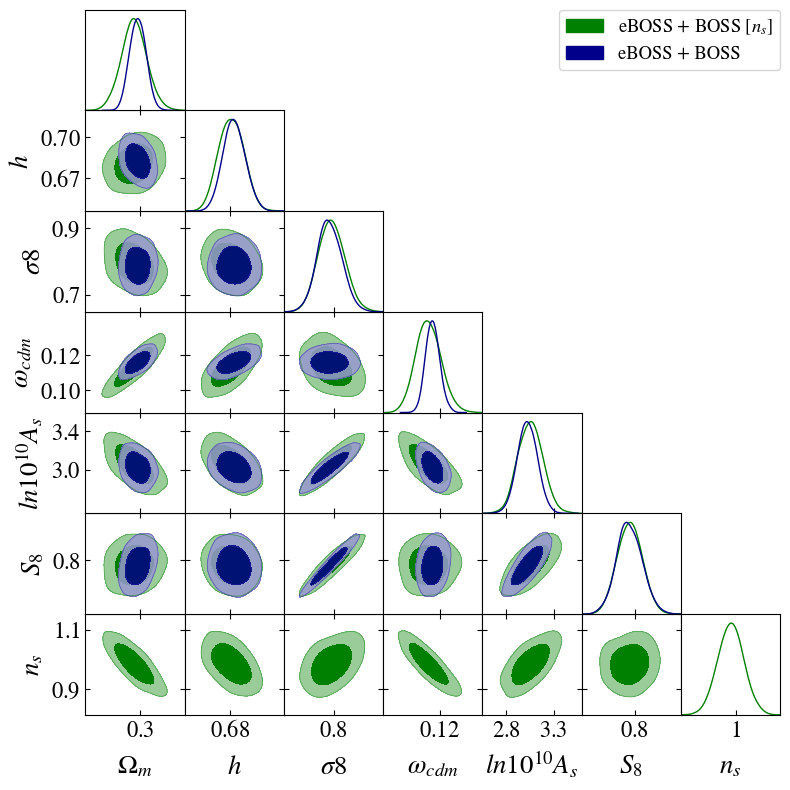

In [1110]:
tri.settings.axes_fontsize = 21
tri.triangle_plot([ns_alone_chain[0], BOSS_eBOSS_chain[0]],
                ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s',],
                #['Om', 'hub', 's8', 'n'],
                filled=True,
                legend_labels=["eBOSS + BOSS [$n_s$]", "eBOSS + BOSS"],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'color':'green'},
                           {'lw':1, 'color':'darkblue'},
                           {'lw':1, 'color':'red'},],
                #markers={'n':0.965,'ob': 2.233,},
                contour_colors=['green','darkblue','red'],
               )
plt.show()
tri.settings.axes_fontsize = 24

## eBOSS + BOSS + BAOSmallZ + Lya + Pan + Planck

In [1111]:
basedir = './eBOSS_LCDM_alternative'
ns_Pl_LSS_chain, ns_Pl_LSS_label = load_multi(
    ["LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_ns_omega_b_2200924",],
    [r"LSS + Pan + Planck [$n_s$ + $\omega_b$]", ])
basedir = './eBOSS_LCDM_real_analysis'

#Bestfit
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s',]
ns_Pl_LSS_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_ns_omega_b_2200924", "LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_ns_omega_b_2200924")
ns_Pl_LSS_bestfit['S8'] = ns_Pl_LSS_bestfit['sigma8']*np.sqrt(ns_Pl_LSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = ns_Pl_LSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
#sample.addDerived(p.Omega_m, name='O_m', range=[0., 1.], label=r'Omega_m')
#print(sample.getInlineLatex('O_m',limit=1))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','n_s','omega_b','S8','tau_reio']
ns_Pl_LSS_error = get_errors(ns_Pl_LSS_chain[0],cosmo)
ns_Pl_LSS_mean = get_means(ns_Pl_LSS_chain[0],cosmo)


#for i in cosmo:
#    stats = sample.getMargeStats().parWithName(i)
#    mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#    err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#    print(i,':', r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
#    #print(i,':', r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))
    

#Shift
ns_Pl_LSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',ns_Pl_LSS_bestfit[i])
        ns_Pl_LSS_shift[i] = ns_Pl_LSS_mean[i] - ns_Pl_LSS_bestfit[i]

# PLOTS

In [1112]:
"""
basedir = './eBOSS_LCDM_real_analysis'


#Planck


chainname = "base_mnu_plikHM_TTTEEE_lowl_lowE_lensing"
chains = os.path.join('./plikHM_TTTEEE_lowl_lowE_lensing', chainname)
planck_plot = loadMCSamples(chains, settings={'ignore_rows':0.0});
p=planck_plot.getParams()
planck_plot.addDerived(p.H0/100., name='hub', label=r'h')
planck_plot.addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
planck_plot.addDerived(p.sigma8, name='s8', label=r'\sigma_8')
planck_plot.addDerived(p.logA, name='lnAS', label=r'\ln 10^{10}A_s')


#BOSS


BOSS_plot_chain, BOSS_plot_label = load_multi(
    ["LCDM_BOSS_BAO_data_220421",],["BOSS", ])
p=BOSS_plot_chain[0].getParams()
#BOSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_plot_chain[0].addDerived(p.Omega_m - boss_shift['Omega_m'], name='Om', label=r'\Omega_m')
BOSS_plot_chain[0].addDerived(p.h - boss_shift['h'], name='hub', label=r'h')
BOSS_plot_chain[0].addDerived(p.sigma8 - boss_shift['sigma8'], name='s8', label=r'\sigma_8')
#BOSS_plot_chain[0].addDerived(p.logA + 0.1219, name='lnAS', label=r'\ln 10^{10}A_s')


#eBOSS


eBOSS_plot_chain, eBOSS_plot_label = load_multi(
    ["LCDM_eBOSS_data_kmax_0p24_priors_16_model_1",],["eBOSS",])
p=eBOSS_plot_chain[0].getParams()
#eBOSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#eBOSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#eBOSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
eBOSS_plot_chain[0].addDerived(p.Omega_m - eboss_shift['Omega_m'], name='Om', label=r'\Omega_m')
eBOSS_plot_chain[0].addDerived(p.h - eboss_shift['h'], name='hub', label=r'h')
eBOSS_plot_chain[0].addDerived(p.sigma8 - eboss_shift['sigma8'], name='s8', label=r'\sigma_8')
eBOSS_plot_chain[0].addDerived(p.omega_cdm - eboss_shift['omega_cdm'], name='ocdm', label=r'\omega_{\rm cdm}')
eBOSS_plot_chain[0].addDerived(np.log(10**10*p.A_s) - eboss_shift['ln10^{10}A_s'], name='lnAS', label=r'\ln 10^{10}A_s')


#eBOSS CF


eBOSS_cf_plot_chain, eBOSS_cf_plot_label = load_multi(
    ["LCDM_eBOSS_data_cf_prior_16",],
    ["eBOSS CF",])
p=eBOSS_cf_plot_chain[0].getParams()
#eBOSS_cf_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#eBOSS_cf_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#eBOSS_cf_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
eBOSS_cf_plot_chain[0].addDerived(p.Omega_m - ebossCF_shift['h'], name='Om', label=r'\Omega_m')
eBOSS_cf_plot_chain[0].addDerived(p.h - ebossCF_shift['Omega_m'], name='hub', label=r'h')
eBOSS_cf_plot_chain[0].addDerived(p.sigma8 - ebossCF_shift['sigma8'], name='s8', label=r'\sigma_8')
#eBOSS_cf_plot_chain[0].addDerived(p.logA - 0.0653, name='lnAS', label=r'\ln 10^{10}A_s')


#BOSS + eBOSS


BOSS_eBOSS_plot_chain, BOSS_eBOSS_plot_label = load_multi(
    ["LCDM_eBOSS_model_1_BOSS_BAO_data_220421"],
    ["eBOSS + BOSS", ])
p=BOSS_eBOSS_plot_chain[0].getParams()
#BOSS_eBOSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_eBOSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_eBOSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_eBOSS_plot_chain[0].addDerived(p.Omega_m - BOSS_eBOSS_shift['Omega_m'], name='Om', label=r'\Omega_m')
BOSS_eBOSS_plot_chain[0].addDerived(p.h - BOSS_eBOSS_shift['h'], name='hub', label=r'h')
BOSS_eBOSS_plot_chain[0].addDerived(p.sigma8 - BOSS_eBOSS_shift['sigma8'], name='s8', label=r'\sigma_8')
#BOSS_eBOSS_plot_chain[0].addDerived(p.logA - 0.1219, name='lnAS', label=r'\ln 10^{10}A_s')


#BOSS + eBOSS + ext-BAO + Pan


BOSS_eBOSS_BAO_Lya_Pan_plot_chain, BOSS_eBOSS_BAO_Lya_Pan_plot_label = load_multi(
    ["LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_220430"],
    ["eBOSS + BOSS + ext-BAO + Pantheon", ])
p=BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].getParams()
#BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.Omega_m - BOSS_eBOSS_BAO_Lya_Pan_shift['Omega_m'], name='Om', label=r'\Omega_m')
BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.h - BOSS_eBOSS_BAO_Lya_Pan_shift['h'], name='hub', label=r'h')
BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.sigma8 - BOSS_eBOSS_BAO_Lya_Pan_shift['sigma8'], name='s8', label=r'\sigma_8')
#BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.logA - 0.1347, name='lnAS', label=r'\ln 10^{10}A_s')


#BOSS + ext-BAO + Pan


BOSS_BAO_Lya_Pan_plot_chain, BOSS_BAO_Lya_Pan_plot_label = load_multi(
    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_220701"],
    ["BOSS + ext-BAO + Pantheon", ])
p=BOSS_BAO_Lya_Pan_plot_chain[0].getParams()
#BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.Omega_m - BOSS_BAO_Lya_Pan_shift['Omega_m'], name='Om', label=r'\Omega_m')
BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.h - BOSS_BAO_Lya_Pan_shift['h'], name='hub', label=r'h')
BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.sigma8 - BOSS_BAO_Lya_Pan_shift['sigma8'], name='s8', label=r'\sigma_8')
#BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.logA - 0.1291, name='lnAS', label=r'\ln 10^{10}A_s')


# eBOSS + BOSS + BBN [ns + omega_b]


basedir = './eBOSS_LCDM_alternative'
ns_plot_chain, ns_plot_label = load_multi(
    ["LCDM_eBOSS_BOSS_BBN_ns_omegab_220504",],
    [r"BOSS + eBOSS + BBN [$n_s$ + $\omega_b$]", ])
basedir = './eBOSS_real_analysis'
p=ns_plot_chain[0].getParams()
ns_plot_chain[0].addDerived(p.Omega_m - ns_shift['Omega_m'], name='Om', label=r'\Omega_m')
ns_plot_chain[0].addDerived(p.h - ns_shift['h'], name='hub', label=r'h')
ns_plot_chain[0].addDerived(p.sigma8 - ns_shift['sigma8'], name='s8', label=r'\sigma_8')
ns_plot_chain[0].addDerived(p.n_s - ns_shift['n_s'], name='n', label=r'n_s')
ns_plot_chain[0].addDerived(p.omega_b - ns_shift['omega_b'], name='ob', label=r'100\omega_b')


# eBOSS + BOSS + BBN [ns + omega_b]


basedir = './eBOSS_LCDM_alternative'
ns_Pl_LSS_plot_chain, ns_Pl_LSS_plot_label = load_multi(
    ["LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_Planck_ns_omega_b_220515",],
    [r"LSS + Pan + Planck [$n_s$ + $\omega_b$]", ])
basedir = './eBOSS_LCDM_real_analysis'
p=ns_Pl_LSS_plot_chain[0].getParams()
ns_Pl_LSS_plot_chain[0].addDerived(p.Omega_m - ns_Pl_LSS_shift['Omega_m'], name='Om', label=r'\Omega_m')
ns_Pl_LSS_plot_chain[0].addDerived(p.h - ns_Pl_LSS_shift['h'], name='hub', label=r'h')
ns_Pl_LSS_plot_chain[0].addDerived(p.sigma8 - ns_Pl_LSS_shift['sigma8'], name='s8', label=r'\sigma_8')
ns_Pl_LSS_plot_chain[0].addDerived(p.n_s - ns_Pl_LSS_shift['n_s'], name='n', label=r'n_s')
ns_Pl_LSS_plot_chain[0].addDerived(p.omega_b - ns_Pl_LSS_shift['omega_b'], name='ob', label=r'100\omega_b')
"""

'\nbasedir = \'./eBOSS_LCDM_real_analysis\'\n\n\n#Planck\n\n\nchainname = "base_mnu_plikHM_TTTEEE_lowl_lowE_lensing"\nchains = os.path.join(\'./plikHM_TTTEEE_lowl_lowE_lensing\', chainname)\nplanck_plot = loadMCSamples(chains, settings={\'ignore_rows\':0.0});\np=planck_plot.getParams()\nplanck_plot.addDerived(p.H0/100., name=\'hub\', label=r\'h\')\nplanck_plot.addDerived(p.Omega_m, name=\'Om\', label=r\'\\Omega_m\')\nplanck_plot.addDerived(p.sigma8, name=\'s8\', label=r\'\\sigma_8\')\nplanck_plot.addDerived(p.logA, name=\'lnAS\', label=r\'\\ln 10^{10}A_s\')\n\n\n#BOSS\n\n\nBOSS_plot_chain, BOSS_plot_label = load_multi(\n    ["LCDM_BOSS_BAO_data_220421",],["BOSS", ])\np=BOSS_plot_chain[0].getParams()\n#BOSS_plot_chain[0].addDerived(p.Omega_m, name=\'Om\', label=r\'\\Omega_m\')\n#BOSS_plot_chain[0].addDerived(p.h, name=\'hub\', label=r\'h\')\n#BOSS_plot_chain[0].addDerived(p.sigma8, name=\'s8\', label=r\'\\sigma_8\')\nBOSS_plot_chain[0].addDerived(p.Omega_m - boss_shift[\'Omega_m\'], nam

In [1113]:
basedir = './eBOSS_LCDM_real_analysis'


#Planck


planck_plot = load_chain("Planck_LCDM_220513", truth=None, basedir=basedir)
p=planck_plot.getParams()
planck_plot.addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
planck_plot.addDerived(p.h, name='hub', label=r'h')
planck_plot.addDerived(p.sigma8, name='s8', label=r'\sigma_8')
planck_plot.addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
planck_plot.addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')


#BOSS


BOSS_plot_chain, BOSS_plot_label = load_multi(
    ["LCDM_BOSS_BAO_data_220421",],["BOSS", ])
p=BOSS_plot_chain[0].getParams()
#BOSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
BOSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
BOSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
BOSS_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
#BOSS_plot_chain[0].addDerived(p.logA + 0.1219, name='lnAS', label=r'\ln 10^{10}A_s')


#eBOSS


eBOSS_plot_chain, eBOSS_plot_label = load_multi(
    ["LCDM_eBOSS_data_kmax_0p24_priors_16_model_1",],["eBOSS",])
p=eBOSS_plot_chain[0].getParams()
#eBOSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#eBOSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#eBOSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
eBOSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
eBOSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
eBOSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
eBOSS_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
eBOSS_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')


#eBOSS CF


eBOSS_cf_plot_chain, eBOSS_cf_plot_label = load_multi(
    ["LCDM_eBOSS_data_cf_prior_16",],
    ["eBOSS CF",])
p=eBOSS_cf_plot_chain[0].getParams()
#eBOSS_cf_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#eBOSS_cf_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#eBOSS_cf_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
eBOSS_cf_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
eBOSS_cf_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
eBOSS_cf_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
#eBOSS_cf_plot_chain[0].addDerived(p.logA - 0.0653, name='lnAS', label=r'\ln 10^{10}A_s')


#BOSS + eBOSS


BOSS_eBOSS_plot_chain, BOSS_eBOSS_plot_label = load_multi(
    ["LCDM_eBOSS_model_1_BOSS_BAO_data_220421"],
    ["eBOSS + BOSS", ])
p=BOSS_eBOSS_plot_chain[0].getParams()
#BOSS_eBOSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_eBOSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_eBOSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_eBOSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
BOSS_eBOSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
BOSS_eBOSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
#BOSS_eBOSS_plot_chain[0].addDerived(p.logA - 0.1219, name='lnAS', label=r'\ln 10^{10}A_s')


#BOSS + eBOSS + ext-BAO + Pan


BOSS_eBOSS_BAO_Lya_Pan_plot_chain, BOSS_eBOSS_BAO_Lya_Pan_plot_label = load_multi(
    ["LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_220430"],
    ["eBOSS + BOSS + ext-BAO + Pantheon", ])
p=BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].getParams()
#BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
#BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.logA - 0.1347, name='lnAS', label=r'\ln 10^{10}A_s')


#BOSS + ext-BAO + Pan


BOSS_BAO_Lya_Pan_plot_chain, BOSS_BAO_Lya_Pan_plot_label = load_multi(
    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_220701"],
    ["BOSS + ext-BAO + Pantheon", ])
p=BOSS_BAO_Lya_Pan_plot_chain[0].getParams()
#BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
#BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.logA - 0.1291, name='lnAS', label=r'\ln 10^{10}A_s')



#BOSS + eBOSS + ext-BAO + Pan [ns + omega_b]

ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain, ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_label = load_multi(
    ["LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_ns_omega_b_220921"],
    ["BOSS + eBOSS + ext-BAO + Pantheon + BBN [$n_s + \omega_b$]", ])
p=ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].getParams()
#ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
#BOSS_BAO_Lya_Pan_plot_chain[0].addDerived(p.logA - 0.1291, name='lnAS', label=r'\ln 10^{10}A_s')


# eBOSS + BOSS + BBN [ns + omega_b]


basedir = './eBOSS_LCDM_alternative'
ns_plot_chain, ns_plot_label = load_multi(
    ["LCDM_eBOSS_BOSS_BBN_ns_omegab_220504",],
    [r"BOSS + eBOSS + BBN [$n_s$ + $\omega_b$]", ])
basedir = './eBOSS_LCDM_real_analysis'
p=ns_plot_chain[0].getParams()
ns_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
ns_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
ns_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
ns_plot_chain[0].addDerived(p.n_s, name='n', label=r'n_s')
ns_plot_chain[0].addDerived(p.omega_b, name='ob', label=r'100\omega_b')


# eBOSS + BOSS + BBN [omega_b]


ob_plot_chain, ob_plot_label = load_multi(
    ["LCDM_eBOSS_BOSS_BBN_omegab_220921",],
    [r"BOSS + eBOSS + BBN [$\omega_b$]", ])
p=ob_plot_chain[0].getParams()
ob_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
ob_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
ob_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
ob_plot_chain[0].addDerived(p.omega_b, name='ob', label=r'100\omega_b')


# eBOSS + BOSS [n_s]


ns_alone_plot_chain, ns_alone_plot_label = load_multi(
    ["LCDM_eBOSS_BOSS_BBN_ns_220921",],
    [r"BOSS + eBOSS [$\n_s$]", ])
p=ns_alone_plot_chain[0].getParams()
ns_alone_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
ns_alone_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
ns_alone_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
ns_alone_plot_chain[0].addDerived(p.n_s, name='n', label=r'n_s')


# Planck + eBOSS + BOSS + BBN [ns + omega_b]


basedir = './eBOSS_LCDM_alternative'
ns_Pl_LSS_plot_chain, ns_Pl_LSS_plot_label = load_multi(
    ["LCDM_eBOSS_BOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_ns_omega_b_2200924",],
    [r"LSS + Pan + Planck [$n_s$ + $\omega_b$]", ])
basedir = './eBOSS_LCDM_real_analysis'
p=ns_Pl_LSS_plot_chain[0].getParams()
ns_Pl_LSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
ns_Pl_LSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
ns_Pl_LSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
ns_Pl_LSS_plot_chain[0].addDerived(p.n_s, name='n', label=r'n_s')
ns_Pl_LSS_plot_chain[0].addDerived(p.omega_b, name='ob', label=r'100\omega_b')
ns_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
ns_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')

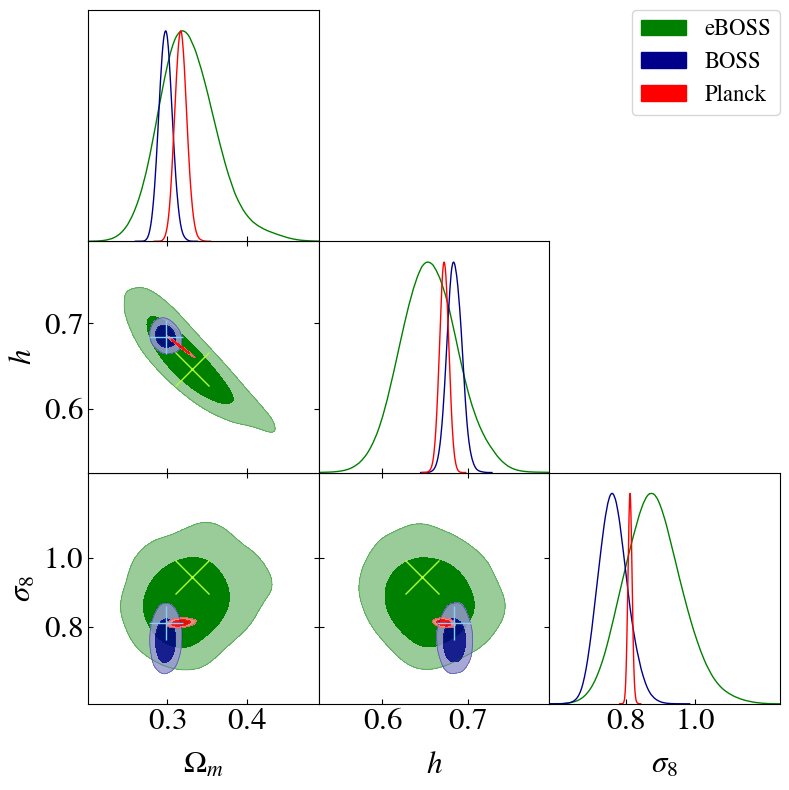

In [1114]:
tri.triangle_plot([eBOSS_plot_chain[0], BOSS_plot_chain[0], planck_plot],
                #['Omega_m', 'h', 'sigma8'], 
                ['Om', 'hub', 's8',],  
                filled=True,
                legend_labels=[eBOSS_plot_label[0], BOSS_plot_label[0], 'Planck'],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'color':'green'},
                           {'lw':1, 'color':'darkblue'},
                           {'lw':1, 'color':'red'},],
                contour_colors=['green','darkblue','red'],
               )

cosmo = ['Omega_m', 'h', 'sigma8']
for i, ci in enumerate(cosmo[1:]):
    for j, cj in enumerate(cosmo[:-1]):
        if i >= j:
            tri.subplots[i+1,j].plot(eboss_bestfit[cj], eboss_bestfit[ci], 'x', markersize=25, color="greenyellow")
            tri.subplots[i+1,j].plot(boss_bestfit[cj], boss_bestfit[ci], '+', markersize=25, color="lightskyblue")

#plt.savefig("Figures/eBOSS_BOSS_Planck.pdf", dpi=1000, facecolor='w')
plt.savefig("Figures/Fig_4_1.pdf", dpi=1000, facecolor='w')
plt.show()

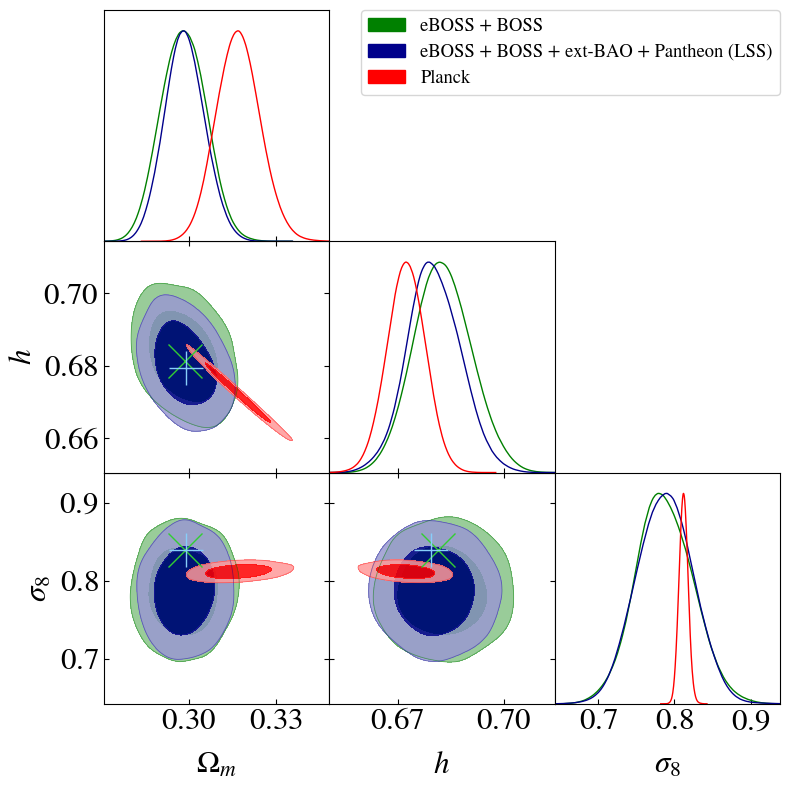

In [1115]:
tri.settings.legend_fontsize = 15
tri.triangle_plot([BOSS_eBOSS_plot_chain[0], BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0], planck_plot,],
                #['Omega_m', 'h', 'sigma8'], 
                ['Om', 'hub', 's8',],  
                filled=True,
                legend_labels=["eBOSS + BOSS", "eBOSS + BOSS + ext-BAO + Pantheon (LSS)", 'Planck',],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'color':'green'},
                           {'lw':1, 'color':'darkblue'},
                           {'lw':1, 'color':'red'},],
                contour_colors=['green','darkblue','red',],
               )
cosmo = ['Omega_m', 'h', 'sigma8']
for i, ci in enumerate(cosmo[1:]):
    for j, cj in enumerate(cosmo[:-1]):
        if i >= j:
            tri.subplots[i+1,j].plot(BOSS_eBOSS_bestfit[cj], BOSS_eBOSS_bestfit[ci], 'x', markersize=25, color="limegreen")
            tri.subplots[i+1,j].plot(BOSS_eBOSS_BAO_Lya_Pan_bestfit[cj], BOSS_eBOSS_BAO_Lya_Pan_bestfit[ci], '+', markersize=25, color="lightskyblue")

#plt.savefig("Figures/eBOSS_BOSS_BAOsmallZ_Lya_Pan_Planck.pdf", dpi=1000, facecolor='w')
plt.savefig("Figures/Fig_4_2.pdf", dpi=1000, facecolor='w')
plt.show()

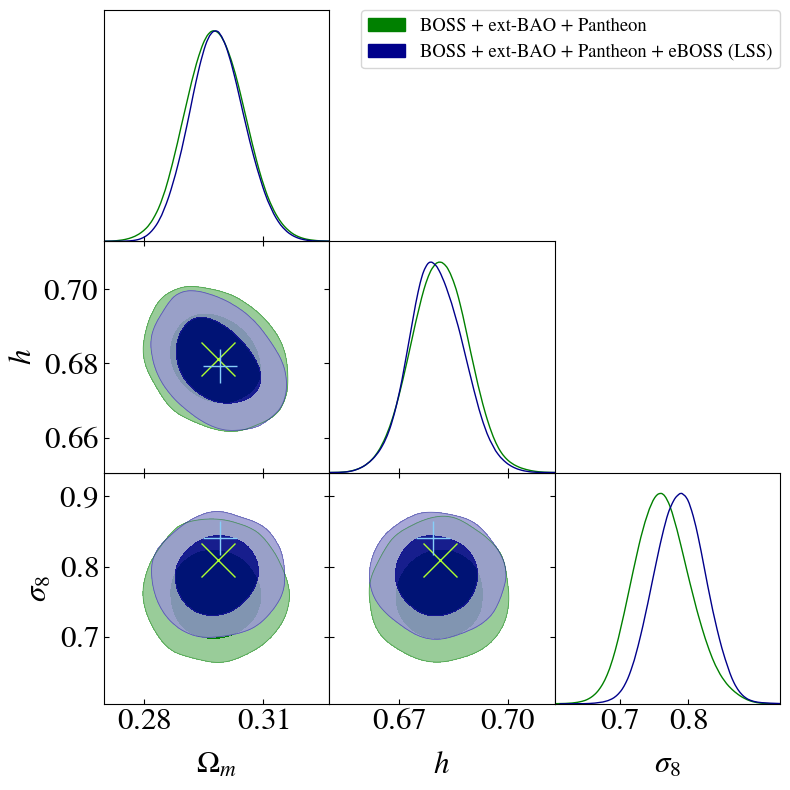

In [1116]:
tri.settings.legend_fontsize = 15
tri.triangle_plot([BOSS_BAO_Lya_Pan_plot_chain[0], BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0], ],
                #['Omega_m', 'h', 'sigma8'], 
                ['Om', 'hub', 's8',],  
                filled=True,
                legend_labels=[BOSS_BAO_Lya_Pan_plot_label[0], "BOSS + ext-BAO + Pantheon + eBOSS (LSS)",],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'color':'green'},
                           {'lw':1, 'color':'darkblue'},],
                contour_colors=['green','darkblue',],
               )
cosmo = ['Omega_m', 'h', 'sigma8']
for i, ci in enumerate(cosmo[1:]):
    for j, cj in enumerate(cosmo[:-1]):
        if i >= j:
            tri.subplots[i+1,j].plot(BOSS_BAO_Lya_Pan_bestfit[cj], BOSS_BAO_Lya_Pan_bestfit[ci], 'x', markersize=25, color="greenyellow")
            tri.subplots[i+1,j].plot(BOSS_eBOSS_BAO_Lya_Pan_bestfit[cj], BOSS_eBOSS_BAO_Lya_Pan_bestfit[ci], '+', markersize=25, color="lightskyblue")

#plt.savefig("Figures/eBOSS_vs_woeBOSS.pdf", dpi=1000, facecolor='w')
plt.savefig("Figures/Fig_4_3.pdf", dpi=1000, facecolor='w')
plt.show()

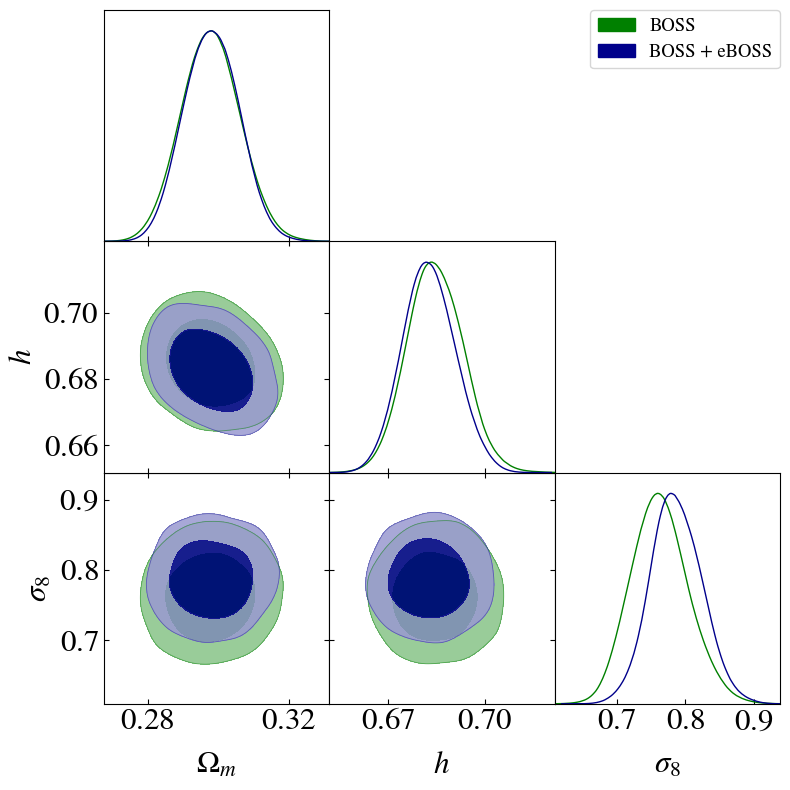

In [1117]:
tri.settings.legend_fontsize = 15
tri.triangle_plot([BOSS_plot_chain[0], BOSS_eBOSS_plot_chain[0], ],
                #['Omega_m', 'h', 'sigma8'], 
                ['Om', 'hub', 's8',],  
                filled=True,
                legend_labels=[BOSS_plot_label[0], "BOSS + eBOSS",],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'color':'green'},
                           {'lw':1, 'color':'darkblue'},],
                contour_colors=['green','darkblue',],
               )
plt.show()

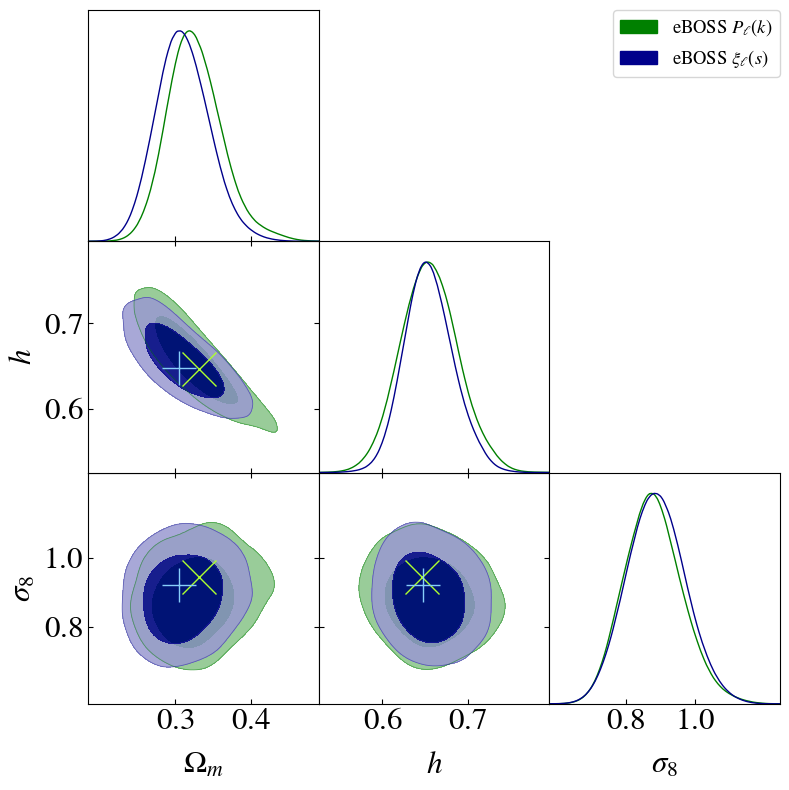

In [1118]:
tri.triangle_plot([eBOSS_plot_chain[0], eBOSS_cf_plot_chain[0]],
                #['Omega_m', 'h', 'sigma8'], 
                ['Om', 'hub', 's8',],  
                filled=True,
                legend_labels=[r"eBOSS $P_\ell(k)$", r"eBOSS $\xi_\ell(s)$ "],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'color':'green'},
                           {'lw':1, 'color':'darkblue'}],
                contour_colors=['green','darkblue'],
               )
cosmo = ['Omega_m', 'h', 'sigma8']
for i, ci in enumerate(cosmo[1:]):
    for j, cj in enumerate(cosmo[:-1]):
        if i >= j:
            tri.subplots[i+1,j].plot(eboss_bestfit[cj], eboss_bestfit[ci], 'x', markersize=25, color="greenyellow")
            tri.subplots[i+1,j].plot(ebossCF_bestfit[cj], ebossCF_bestfit[ci], '+', markersize=25, color="lightskyblue")

#plt.savefig("Figures/eBOSS_CF_vs_FS.pdf", dpi=1000, facecolor='w')
plt.savefig("Figures/Fig_4_4.pdf", dpi=1000, facecolor='w')
plt.show()

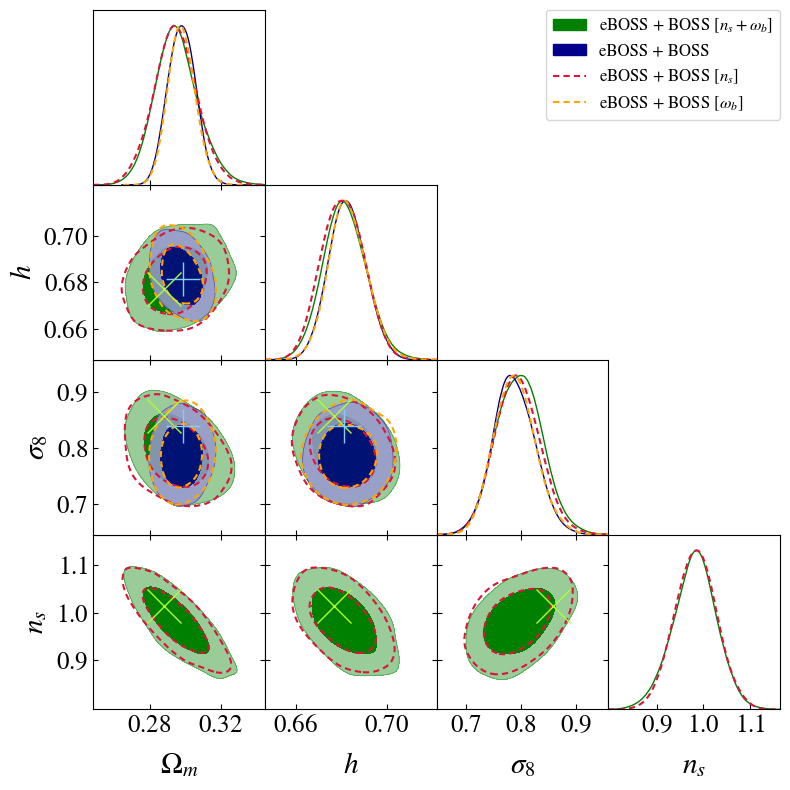

In [1119]:
tri.settings.axes_fontsize = 21

tri.triangle_plot([ns_plot_chain[0], BOSS_eBOSS_plot_chain[0], ns_alone_plot_chain[0], ob_plot_chain[0],],
                #['Omega_m', 'h', 'sigma8', 'n_s', 'omega_b'],
                ['Om', 'hub', 's8', 'n'],
                filled=[True,True,False,False],
                legend_labels=["eBOSS + BOSS [$n_s + \omega_b$]",
                               "eBOSS + BOSS",
                               "eBOSS + BOSS [$n_s$]",
                               "eBOSS + BOSS [$\omega_b$]",],
                legend_loc='upper right', 
                line_args=[{'lw':1,'ls':'-', 'color':'green'},
                           {'lw':1,'ls':'-', 'color':'darkblue'},
                           {'lw':1.5,'ls':'--', 'color':'crimson'},
                           {'lw':1.5,'ls':'--', 'color':'orange'},],
                #markers={'n':0.965,'ob': 2.233,},
                contour_colors=['green','darkblue','crimson','orange'],
                contour_ls= ['-','-', '--' ,'--'],
                contour_lws= [1, 1, 1.5, 1.5],
               )
cosmo = ['Omega_m', 'h', 'sigma8','n_s']
for i, ci in enumerate(cosmo[1:]):
    for j, cj in enumerate(cosmo[:-1]):
        if i >= j:
            tri.subplots[i+1,j].plot(ns_bestfit[cj], ns_bestfit[ci], 'x', markersize=25, color="greenyellow")
cosmo = ['Omega_m', 'h', 'sigma8']
for i, ci in enumerate(cosmo[1:]):
    for j, cj in enumerate(cosmo[:-1]):
        if i >= j:
            tri.subplots[i+1,j].plot(BOSS_eBOSS_bestfit[cj], BOSS_eBOSS_bestfit[ci], '+', markersize=25, color="lightskyblue")

#plt.savefig("Figures/eBOSS_BOSS_Planck_ns_omega_b.pdf", dpi=1000, facecolor='w')
plt.savefig("Figures/Fig_8.pdf", dpi=1000, facecolor='w')
plt.show()
tri.settings.axes_fontsize = 24

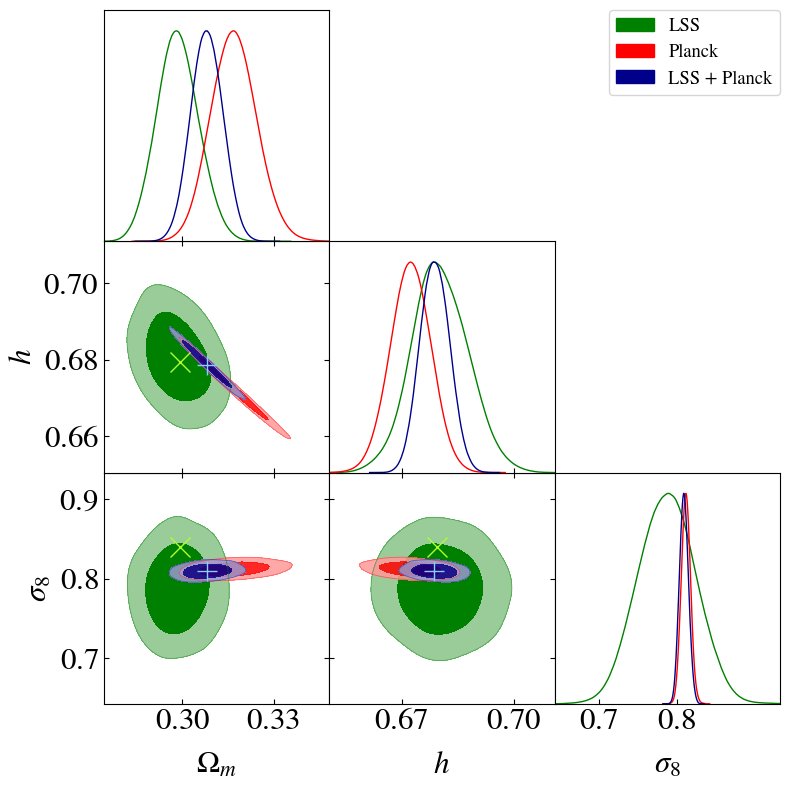

In [1120]:
tri.triangle_plot([BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0], planck_plot, ns_Pl_LSS_plot_chain[0],],
                #['Omega_m', 'h', 'sigma8'], 
                ['Om', 'hub', 's8',],  
                #['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s'],
                filled=True,
                legend_labels=["LSS",
                               "Planck",
                               "LSS + Planck",],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'color':'green'},
                           {'lw':1, 'color':'red'},
                           {'lw':1, 'color':'darkblue'},],
                contour_colors=['green','red','darkblue',],
               )
cosmo = ['Omega_m','h','sigma8',]
for i, ci in enumerate(cosmo[1:]):
    for j, cj in enumerate(cosmo[:-1]):
        if i >= j:
            tri.subplots[i+1,j].plot(BOSS_eBOSS_BAO_Lya_Pan_bestfit[cj], BOSS_eBOSS_BAO_Lya_Pan_bestfit[ci], 'x', markersize=15, color="greenyellow")
            tri.subplots[i+1,j].plot(ns_Pl_LSS_bestfit[cj], ns_Pl_LSS_bestfit[ci], '+', markersize=15, color="lightskyblue")

#plt.savefig("Figures/LSS_Planck.pdf", dpi=1000, facecolor='w')
plt.show()

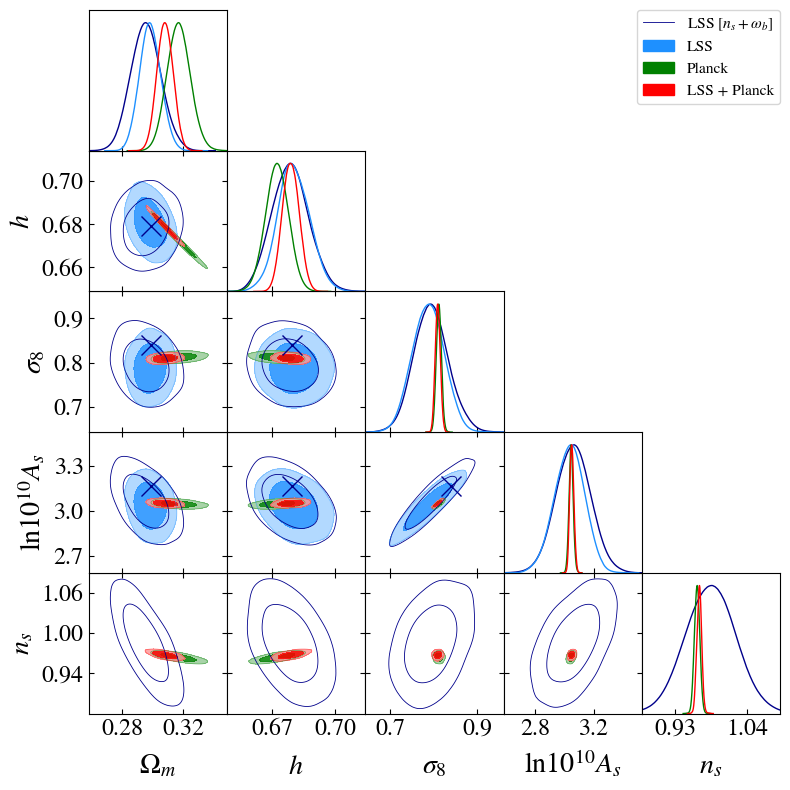

In [1121]:
tri.settings.axes_fontsize = 21
tri.settings.legend_fontsize = 15
tri.triangle_plot([ns_ob_BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0], BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0], 
                   planck_plot, ns_Pl_LSS_plot_chain[0],],
                #['Omega_m', 'h', 'sigma8'], 
                #['Om', 'hub', 's8','n_s'],  
                ['Om', 'hub', 's8', 'lnAS','n_s',],
                #['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s'],
                filled= [False,True,True,True,],
                legend_labels=["LSS [$n_s + \omega_b$]",
                               "LSS",
                               "Planck",
                               "LSS + Planck",],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'ls': '-', 'color':'darkblue'},
                           {'lw':1, 'color':'dodgerblue'},
                           {'lw':1, 'color':'green'},
                           {'lw':1, 'color':'red'},],
                colors=['darkblue','dodgerblue','green','red'],
                contour_ls= ['-', '-' ,'-', '-'],
                #contour_lw= [1.5, 1, 1, 1,],
               )
cosmo = ['Omega_m','h','sigma8','ln10^{10}A_s']
for i, ci in enumerate(cosmo[1:]):
    for j, cj in enumerate(cosmo[:-1]):
        if i >= j:
            tri.subplots[i+1,j].plot(BOSS_eBOSS_BAO_Lya_Pan_bestfit[cj], BOSS_eBOSS_BAO_Lya_Pan_bestfit[ci], 'x', markersize=15, color="darkblue")
cosmo = ['Omega_m','h','sigma8','ln10^{10}A_s','n_s']
#for i, ci in enumerate(cosmo[1:]):
#    for j, cj in enumerate(cosmo[:-1]):
#        if i >= j:
#            #print(i+1, j)
#            tri.subplots[i+1,j].plot(ns_Pl_LSS_bestfit[cj], ns_Pl_LSS_bestfit[ci], '+', markersize=15, color="black")

tri.subplots[4,1].set_ylim([0.88,1.09])

#plt.savefig("Figures/LSS_Planck.pdf", dpi=1000, facecolor='w')
plt.show()
tri.settings.axes_fontsize = 24

In [1122]:
basedir = './eBOSS_LCDM_real_analysis'

eBOSS_noshift_plot_chain, eBOSS_noshift_plot_label = load_multi(
    ["LCDM_eBOSS_data_kmax_0p24_priors_16_model_1",],["eBOSS (before correction)",])
p=eBOSS_noshift_plot_chain[0].getParams()
eBOSS_noshift_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
eBOSS_noshift_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
eBOSS_noshift_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
eBOSS_noshift_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
eBOSS_noshift_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')

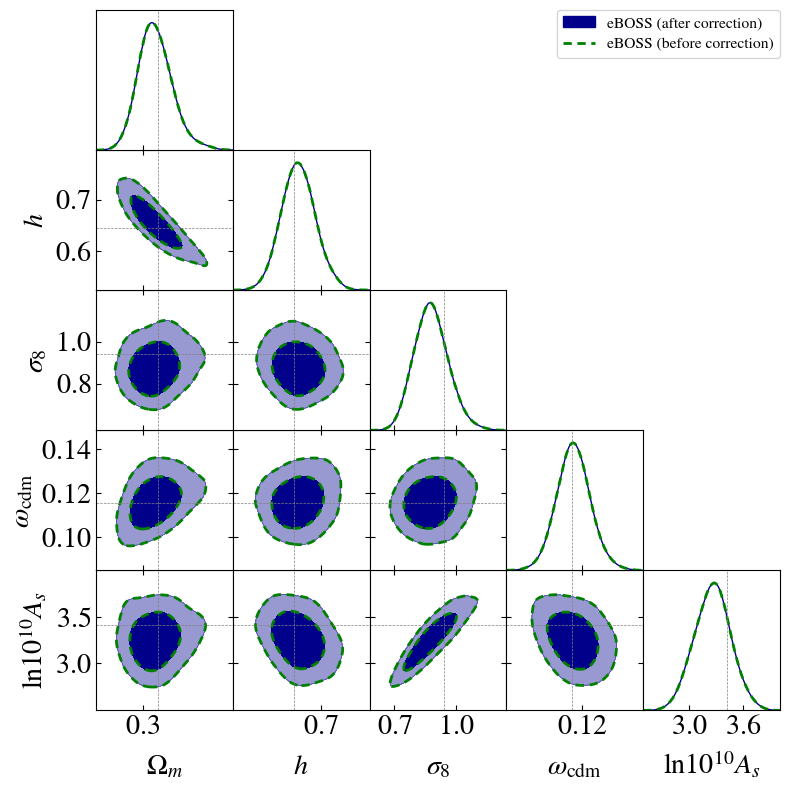

In [1123]:
tri.triangle_plot([eBOSS_plot_chain[0], eBOSS_noshift_plot_chain[0],], 
           #['Omega_m', 'h', 'sigma8'], 
           ['Om', 'hub', 's8','ocdm','lnAS'],
           filled=[True, False,],
           contour_ls= ['-', '--',],
           contour_lws= [1, 2,],
           legend_loc='upper right',
           markers = [eboss_bestfit[c] for c in ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s']],
           line_args=[{'lw':1, 'color':'darkblue'},
                      {'lw':1, 'color':'green'},],
           contour_colors=['darkblue','green',],
           legend_labels=["eBOSS (after correction)", "eBOSS (before correction)",],)
#plt.savefig("eBOSS_correction.pdf", dpi=1000, facecolor='w', bbox_inches='tight')
plt.show()

# Plot BAO fs8

In [1124]:
basedir = './eBOSS_LCDM_real_analysis'

In [1125]:
#BOSS


BOSS_fs8_plot_chain, BOSS_fs8_plot_label = load_multi(
    ["LCDM_fsigma8_BOSS_221010",],["BOSS fs8", ])
p=BOSS_fs8_plot_chain[0].getParams()
#BOSS_fs8_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_fs8_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_fs8_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_fs8_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
BOSS_fs8_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
BOSS_fs8_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_fs8_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
BOSS_fs8_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
#BOSS_fs8_plot_chain[0].addDerived(p.logA + 0.1219, name='lnAS', label=r'\ln 10^{10}A_s')


#eBOSS


eBOSS_fs8_plot_chain, eBOSS_fs8_plot_label = load_multi(
    ["LCDM_fsigma8_eBOSS_221010",],["eBOSS fs8", ])
p=eBOSS_fs8_plot_chain[0].getParams()
#eBOSS_fs8_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#eBOSS_fs8_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#eBOSS_fs8_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
eBOSS_fs8_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
eBOSS_fs8_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
eBOSS_fs8_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
eBOSS_fs8_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
eBOSS_fs8_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
#eBOSS_fs8_plot_chain[0].addDerived(p.logA + 0.1219, name='lnAS', label=r'\ln 10^{10}A_s')


#eBOSS + BOSS


BOSS_eBOSS_fs8_plot_chain, BOSS_eBOSS_fs8_plot_label = load_multi(
    ["LCDM_fsigma8_eBOSS_BOSS_221010",],["eBOSS + BOSS fs8", ])
p=BOSS_eBOSS_fs8_plot_chain[0].getParams()
#BOSS_eBOSS_fs8_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_eBOSS_fs8_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_eBOSS_fs8_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_eBOSS_fs8_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
BOSS_eBOSS_fs8_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
BOSS_eBOSS_fs8_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
BOSS_eBOSS_fs8_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
BOSS_eBOSS_fs8_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
#BOSS_eBOSS_fs8_plot_chain[0].addDerived(p.logA + 0.1219, name='lnAS', label=r'\ln 10^{10}A_s')


#LSS


LSS_fs8_plot_chain, LSS_fs8_plot_label = load_multi(
    ["LCDM_fsigma8_eBOSS_BOSS_Pan_BAOsmallz_Lyalpha_221010",],["LSS fs8", ])
p=LSS_fs8_plot_chain[0].getParams()
#LSS_fs8_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#LSS_fs8_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#LSS_fs8_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
LSS_fs8_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
LSS_fs8_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
LSS_fs8_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
LSS_fs8_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
LSS_fs8_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
#LSS_fs8_plot_chain[0].addDerived(p.logA + 0.1219, name='lnAS', label=r'\ln 10^{10}A_s')


#LSS + Planck

ns_Pl_LSS_fs8_plot_chain, LSS_fs8_plot_label = load_multi(
    ["LCDM_fsigma8_eBOSS_BOSS_Pan_BAOsmallz_Lyalpha_newPlanck_ns_omega_b_221010",],["LSS + Planck fs8", ])
p=ns_Pl_LSS_fs8_plot_chain[0].getParams()
#ns_Pl_LSS_fs8_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#ns_Pl_LSS_fs8_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#ns_Pl_LSS_fs8_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
ns_Pl_LSS_fs8_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
ns_Pl_LSS_fs8_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
ns_Pl_LSS_fs8_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
ns_Pl_LSS_fs8_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
ns_Pl_LSS_fs8_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
#ns_Pl_LSS_fs8_plot_chain[0].addDerived(p.logA + 0.1219, name='lnAS', label=r'\ln 10^{10}A_s')

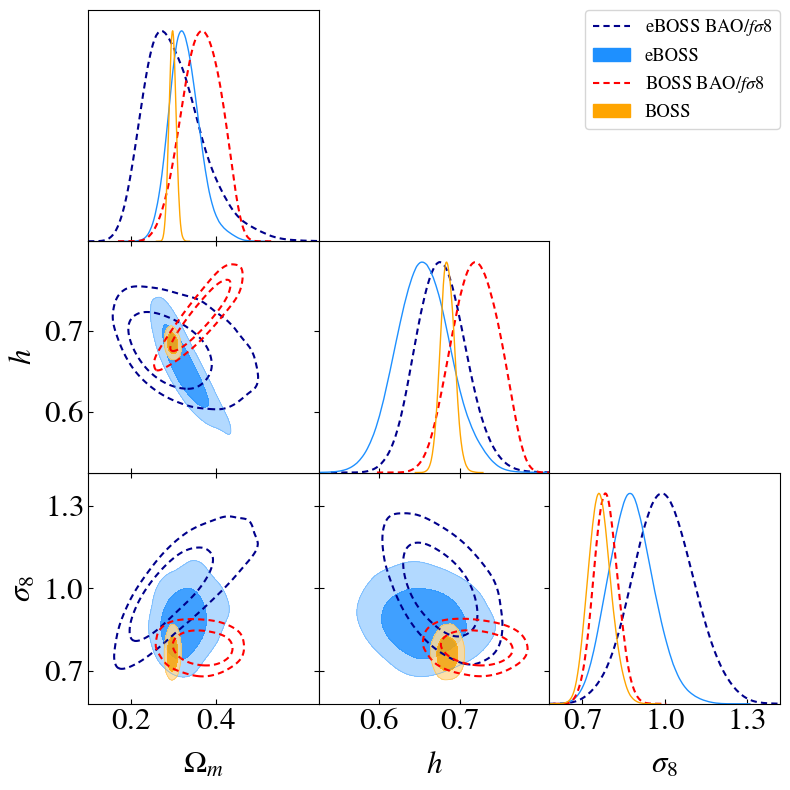

In [1126]:
tri.triangle_plot([eBOSS_fs8_plot_chain[0], eBOSS_plot_chain[0],
                   BOSS_fs8_plot_chain[0], BOSS_plot_chain[0],],              
                ['Om', 'hub', 's8',],  
                filled=[False, True, False, True],
                legend_labels=["eBOSS BAO/$f\sigma8$","eBOSS",
                               "BOSS BAO/$f\sigma8$","BOSS",],
                legend_loc='upper right', 
                #line_args=[{'lw':1, 'color':'green'},
                 #          {'lw':1, 'color':'red'},
                 #        {'lw':1, 'color':'darkblue'},],
                contour_ls= ['--','-', '--' ,'-'],
                contour_lws= [1.5, 1, 1.5, 1],
                contour_colors=['darkblue','dodgerblue','red','orange'],
               )

plt.savefig("Figures/eBOSS_BOSS_fs8.pdf", dpi=1000, facecolor='w')
plt.show()

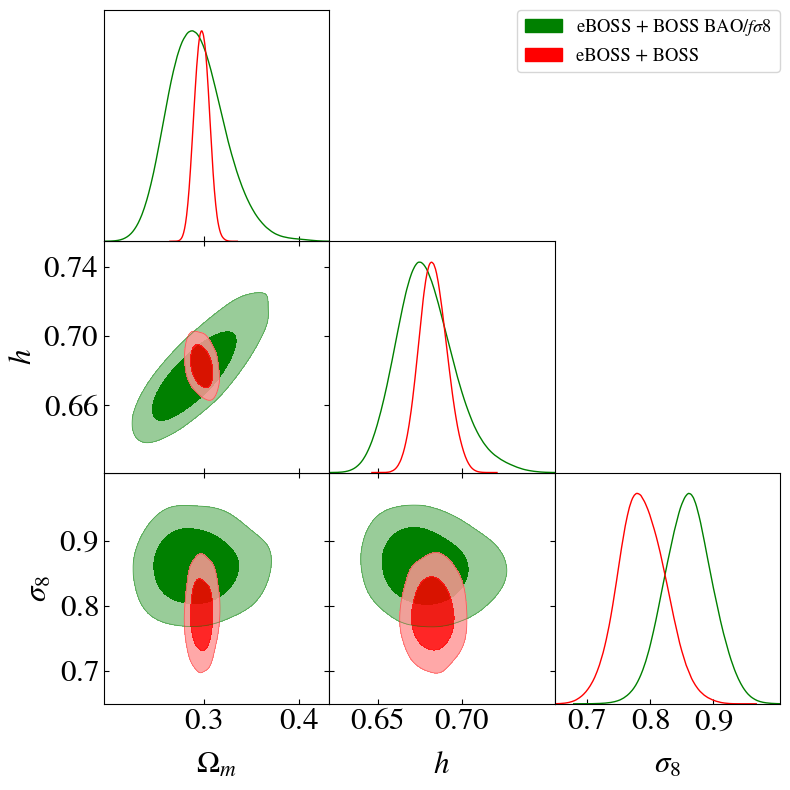

In [1127]:
tri.triangle_plot([BOSS_eBOSS_fs8_plot_chain[0], BOSS_eBOSS_plot_chain[0]],
                ['Om', 'hub', 's8',],  
                filled=True,
                legend_labels=["eBOSS + BOSS BAO/$f\sigma8$",
                               "eBOSS + BOSS"],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'color':'green'},
                           {'lw':1, 'color':'red'},
                           {'lw':1, 'color':'darkblue'},],
                contour_colors=['green','red','darkblue',],
               )

#plt.savefig("Figures/XX", dpi=1000, facecolor='w')
plt.show()

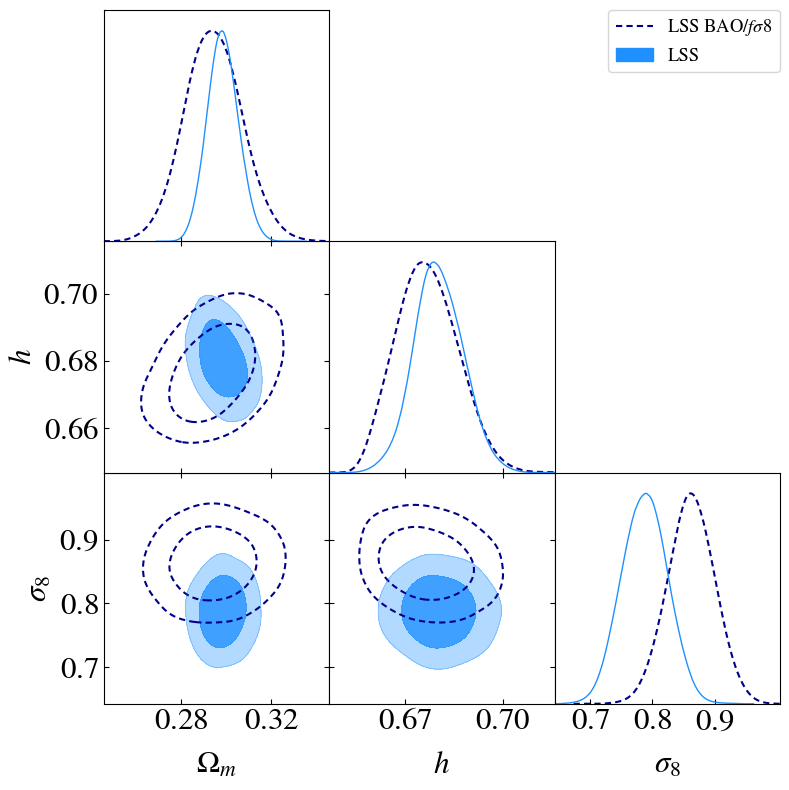

In [1128]:
tri.triangle_plot([LSS_fs8_plot_chain[0], BOSS_eBOSS_BAO_Lya_Pan_plot_chain[0]],
                ['Om', 'hub', 's8',],  
                filled=[False, True, False, True],
                legend_labels=["LSS BAO/$f\sigma8$","LSS",],
                legend_loc='upper right', 
                #line_args=[{'lw':1, 'color':'green'},
                 #          {'lw':1, 'color':'red'},
                 #        {'lw':1, 'color':'darkblue'},],
                contour_ls= ['--','-', '--' ,'-'],
                contour_lws= [1.5, 1, 1.5, 1],
                contour_colors=['darkblue','dodgerblue','red','orange'],
               )

plt.savefig("Figures/LSS_fs8.pdf", dpi=1000, facecolor='w')
plt.show()

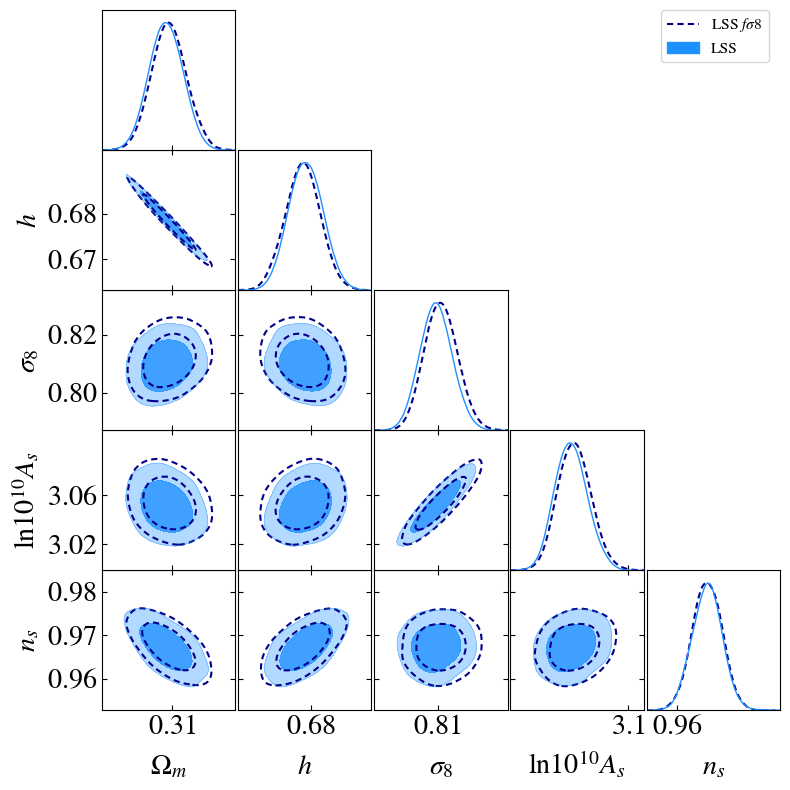

In [1129]:
tri.triangle_plot([ns_Pl_LSS_fs8_plot_chain[0], ns_Pl_LSS_plot_chain[0]],
                ['Om', 'hub', 's8', 'lnAS','n_s',],  
                filled=[False, True, False, True],
                legend_labels=["LSS $f\sigma8$","LSS",],
                legend_loc='upper right', 
                #line_args=[{'lw':1, 'color':'green'},
                 #          {'lw':1, 'color':'red'},
                 #        {'lw':1, 'color':'darkblue'},],
                contour_ls= ['--','-', '--' ,'-'],
                contour_lws= [1.5, 1, 1.5, 1],
                contour_colors=['darkblue','dodgerblue','red','orange'],
               )

plt.savefig("Figures/LLS_Planck_fs8.pdf", dpi=1000, facecolor='w')
plt.show()

In [1221]:
BOSS_fs8_chain, BOSS_fs8_label = load_multi(
    ["LCDM_fsigma8_BOSS_221010",],
    ["BOSS fs8", ])


#Mean / 1sigma error
sample = BOSS_fs8_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
boss_fs8_error = get_errors(BOSS_fs8_chain[0],cosmo)
boss_fs8_mean = get_means(BOSS_fs8_chain[0],cosmo)


for i in cosmo:
    print(i,':', boss_fs8_error[i]/boss_error[i])
    #print(i,':', 2*(boss_fs8_mean[i] - boss_mean[i])/(boss_error[i]+boss_fs8_error[i]))

Omega_m : 5.422499570624874
h : 3.2278624351029213
sigma8 : 1.0391170154015517
omega_cdm : 7.7852970401665855
ln10^{10}A_s : 2.6172838088893653
S8 : 1.5868132374908415


In [1226]:
eBOSS_0p24_model_1_fs8_chain, eBOSS_0p24_model_1_fs8_label = load_multi(
    ["LCDM_fsigma8_eBOSS_221010",],
    ["eBOSS fs8",])


#Mean / 1sigma error
sample = eBOSS_0p24_model_1_fs8_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
eboss_fs8_error = get_errors(eBOSS_0p24_model_1_fs8_chain[0],cosmo)
eboss_fs8_mean = get_means(eBOSS_0p24_model_1_fs8_chain[0],cosmo)


for i in cosmo:
    #print(i,':', eboss_fs8_error[i])
    #print(i,':', eboss_error[i])
    print(i,':', eboss_fs8_error[i]/[i])
    #print(i,':', 2*(eboss_fs8_mean[i] - eboss_mean[i])/(eboss_fs8_error[i]+eboss_error[i]))

Omega_m : 1.928852475397211
h : 0.9070044103486425
sigma8 : 1.3296177973219987
omega_cdm : 3.7385959763686674
ln10^{10}A_s : 1.2478901315751647
S8 : 1.9706311361134408


In [1224]:
BOSS_eBOSS_BAO_Lya_Pan_fs8_chain, BOSS_eBOSS_BAO_Lya_Pan_fs8_label = load_multi(
    ["LCDM_fsigma8_eBOSS_BOSS_Pan_BAOsmallz_Lyalpha_221010"],
    ["BOSS + eBOSS + ext-BAO + Pantheon fs8", ])

#Mean / 1sigma error
sample = BOSS_eBOSS_BAO_Lya_Pan_fs8_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
BOSS_eBOSS_BAO_Lya_Pan_fs8_error = get_errors(BOSS_eBOSS_BAO_Lya_Pan_fs8_chain[0],cosmo)
BOSS_eBOSS_BAO_Lya_Pan_fs8_mean = get_means(BOSS_eBOSS_BAO_Lya_Pan_fs8_chain[0],cosmo)

for i in cosmo:
    print(i,':', BOSS_eBOSS_BAO_Lya_Pan_fs8_error[i]/BOSS_eBOSS_BAO_Lya_Pan_error[i])
    #print(i,':', 2*(BOSS_eBOSS_BAO_Lya_Pan_fs8_mean[i]-BOSS_eBOSS_BAO_Lya_Pan_mean[i])/(BOSS_eBOSS_BAO_Lya_Pan_fs8_error[i]+BOSS_eBOSS_BAO_Lya_Pan_error[i]))

Omega_m : 1.8662763839012961
h : 1.2423715463880918
sigma8 : 1.0378378735057339
omega_cdm : 2.220318776429086
ln10^{10}A_s : 1.3264682823079217
S8 : 1.1224886165489314


In [1133]:
ns_Pl_LSS_fs8_chain, ns_Pl_LSS_fs8_label = load_multi(
    ["LCDM_fsigma8_eBOSS_BOSS_Pan_BAOsmallz_Lyalpha_newPlanck_ns_omega_b_221010",],
    [r"LSS + Pan + Planck [$n_s$ + $\omega_b$] fs8", ])


#Mean / 1sigma error
sample = ns_Pl_LSS_fs8_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','n_s','omega_b','S8','tau_reio']
ns_Pl_LSS_fs8_error = get_errors(ns_Pl_LSS_fs8_chain[0],cosmo)
ns_Pl_LSS_fs8_mean = get_means(ns_Pl_LSS_fs8_chain[0],cosmo)

for i in cosmo:
    print(i,':', ns_Pl_LSS_fs8_error[i]/ns_Pl_LSS_error[i])
    #print(i,':', 2*(ns_Pl_LSS_fs8_mean[i] - ns_Pl_LSS_mean[i])/ (ns_Pl_LSS_fs8_error[i] + ns_Pl_LSS_error[i]))

Omega_m : 1.0322079695810722
h : 1.0258289516156245
sigma8 : 1.029635595898483
omega_cdm : 1.034677898503997
ln10^{10}A_s : 1.0294952531207942
n_s : 0.9851448729490552
omega_b : 1.0571183609227228
S8 : 1.0425897262993666
tau_reio : 1.0386498682182221


# SIGMA DEVIATION

In [1208]:
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']

## eBOSS - BOSS

In [1219]:
for i in cosmo:
    print(i,':', (eboss_bestfit[i] - boss_bestfit[i])/ np.sqrt(eboss_error[i]**2 + boss_error[i]**2))
    #print(i,':', (eboss_mean[i] - boss_mean[i])/ np.sqrt(eboss_error[i]**2 + boss_error[i]**2))

Omega_m : 0.8866771541927602
h : -1.075385589514944
sigma8 : 1.4145325826885113
omega_cdm : -0.11123188974679024
ln10^{10}A_s : 1.43471568449028
S8 : 1.5514191841823672


## eBOSS - eBOSS CF

In [1136]:
for i in cosmo:
    print(i,':', 2 * (eboss_bestfit[i] - ebossCF_bestfit[i])/ (eboss_error[i] + ebossCF_error[i]))
   # print(i,':', 2 * (eboss_mean[i] - ebossCF_mean[i])/ (eboss_error[i] + ebossCF_error[i]))
    #print(i,':', (eboss_error[i] / ebossCF_error[i] - 1)*100)

Omega_m : 0.7123928846637246
h : -0.0606350339815853
sigma8 : 0.25082982556686934
omega_cdm : 1.0941798144285453
ln10^{10}A_s : -0.32586489447424827
S8 : 0.5600475471567783


## BOSS - Planck

In [1137]:
for i in cosmo:
    print(i,':', (boss_bestfit[i] - planck_bestfit_paper[i])/ np.sqrt(boss_error[i]**2 + planck_error_paper[i]**2))
    #print(i,':', (boss_mean[i] - planck_mean_paper[i])/ np.sqrt(boss_error[i]**2 + planck_error_paper[i]**2))

Omega_m : -1.6047856125137423
h : 1.0462174830794915
sigma8 : -0.03190845895772671
omega_cdm : -0.7541208759429368
ln10^{10}A_s : 0.2624870280782134
S8 : -0.5508230600698463


## (eBOSS + BOSS) - BOSS

In [1138]:
for i in cosmo:
    #print(i,':', (BOSS_eBOSS_bestfit[i] - boss_bestfit[i])/ np.sqrt(BOSS_eBOSS_error[i]**2 + boss_error[i]**2))
    #print(i,':', (BOSS_eBOSS_mean[i] - boss_mean[i])/ np.sqrt(BOSS_eBOSS_error[i]**2 + boss_error[i]**2))
    print(i,':', BOSS_eBOSS_error[i]/boss_error[i])

Omega_m : 0.9338451205244187
h : 0.9417722117680729
sigma8 : 0.8972276998545873
omega_cdm : 0.8667047268389896
ln10^{10}A_s : 0.8812418913273011
S8 : 0.8937983652024495


## (eBOSS + BOSS) - LSS

In [1139]:
for i in cosmo:
    #print(i,':', (BOSS_eBOSS_bestfit[i] - BOSS_eBOSS_BAO_Lya_Pan_bestfit[i])/ np.sqrt(BOSS_eBOSS_error[i]**2 + BOSS_eBOSS_BAO_Lya_Pan_error[i]**2))
    #print(i,':', (BOSS_eBOSS_mean[i] - BOSS_eBOSS_BAO_Lya_Pan_mean[i])/ np.sqrt(BOSS_eBOSS_error[i]**2 + BOSS_eBOSS_BAO_Lya_Pan_error[i]**2))
    print(i,':', BOSS_eBOSS_error[i]/BOSS_eBOSS_BAO_Lya_Pan_error[i])

Omega_m : 1.1228146875759004
h : 1.076817134265899
sigma8 : 1.0239971583333478
omega_cdm : 1.1206209081418508
ln10^{10}A_s : 1.0424207982527662
S8 : 1.017016542958855


## eBOSS - Planck

In [1140]:
for i in cosmo:
    print(i,':', (eboss_bestfit[i] - planck_bestfit_paper[i])/ np.sqrt(eboss_error[i]**2 + planck_error_paper[i]**2))
    #print(i,':', (eboss_mean[i] - planck_mean_paper[i])/ np.sqrt(eboss_error[i]**2 + planck_error_paper[i]**2))

Omega_m : 0.418334739601701
h : -0.7859120345533539
sigma8 : 1.5616771681485362
omega_cdm : -0.5841864465364908
ln10^{10}A_s : 1.8232062943777734
S8 : 1.4310088038495696


## (eBOSS + BOSS) - Planck

In [1141]:
for i in cosmo:
    print(i,':', (BOSS_eBOSS_bestfit[i] - planck_bestfit_paper[i])/ np.sqrt(BOSS_eBOSS_error[i]**2 + planck_error_paper[i]**2))
    #print(i,':', (BOSS_eBOSS_mean[i] - planck_mean_paper[i])/ np.sqrt(BOSS_eBOSS_error[i]**2 + planck_error_paper[i]**2))
    #print(i,':', BOSS_eBOSS_error[i]/planck_error_paper[i])

Omega_m : -1.6169285950637238
h : 0.8371577343554626
sigma8 : 0.7224536884162237
omega_cdm : -1.0424156701705307
ln10^{10}A_s : 1.041595809966398
S8 : 0.10859185656240837


## LSS - Planck

In [1142]:
for i in cosmo:
    #print(i,':', (BOSS_eBOSS_BAO_Lya_Pan_bestfit[i] - planck_bestfit_paper[i])/ np.sqrt(BOSS_eBOSS_BAO_Lya_Pan_error[i]**2 + planck_error_paper[i]**2))
    #print(i,':', (BOSS_eBOSS_BAO_Lya_Pan_mean[i] - planck_mean_paper[i])/ np.sqrt(BOSS_eBOSS_BAO_Lya_Pan_error[i]**2 + planck_error_paper[i]**2))
    print(i,':', BOSS_eBOSS_BAO_Lya_Pan_error[i]/planck_error_paper[i]) 

Omega_m : 0.9434173815290091
h : 1.4027554861173372
sigma8 : 6.1206436266043305
omega_cdm : 3.0422877427636372
ln10^{10}A_s : 7.318121670399253
S8 : 2.94518836959268


## (LSS) - (LSS- eBOSS)

In [1143]:
for i in cosmo:
    print(i,':', BOSS_eBOSS_BAO_Lya_Pan_error[i]/BOSS_BAO_Lya_Pan_error[i]) 

Omega_m : 0.92357105906734
h : 0.9562876317272262
sigma8 : 0.8832073472455113
omega_cdm : 0.8716519634676789
ln10^{10}A_s : 0.8565127251100667
S8 : 0.9008374784036747


## (eBOSS + BOSS + BBN [$n_s + \omega_b$]) - (eBOSS + BOSS)  [relative shift]

In [1144]:
for i in cosmo:
    #print(i,':', 2*(ns_bestfit[i] - BOSS_eBOSS_bestfit[i])/(ns_error[i] + BOSS_eBOSS_error[i]))
    #print(i,':', 2*(ns_mean[i] - BOSS_eBOSS_mean[i])/(ns_error[i] + BOSS_eBOSS_error[i]))
    print(i,':', ns_error[i] / BOSS_eBOSS_error[i])

Omega_m : 1.5895760517854571
h : 1.161724719632346
sigma8 : 1.1045208984644703
omega_cdm : 1.8252026280945859
ln10^{10}A_s : 1.2546513668985357
S8 : 1.0024640417746074


## (LSS [$n_s + \omega_b$]) - LSS  [relative shift]

In [1145]:
for i in cosmo:
    #print(i,':', 2*(ns_ob_BOSS_eBOSS_BAO_Lya_Pan_bestfit[i] - BOSS_eBOSS_BAO_Lya_Pan_bestfit[i])/(ns_ob_BOSS_eBOSS_BAO_Lya_Pan_error[i] + BOSS_eBOSS_BAO_Lya_Pan_error[i]))
    #print(i,':', 2*(ns_ob_BOSS_eBOSS_BAO_Lya_Pan_mean[i] - BOSS_eBOSS_BAO_Lya_Pan_mean[i])/(ns_ob_BOSS_eBOSS_BAO_Lya_Pan_error[i] + BOSS_eBOSS_BAO_Lya_Pan_error[i]))
    print(i,':', ns_ob_BOSS_eBOSS_BAO_Lya_Pan_error[i] / BOSS_eBOSS_BAO_Lya_Pan_error[i])

Omega_m : 1.4098726269114377
h : 1.1444505232459259
sigma8 : 1.085239298875865
omega_cdm : 1.617072149186078
ln10^{10}A_s : 1.1631969568376719
S8 : 1.016543233605742


## (eBOSS + BOSS + BBN [$\omega_b$]) - (eBOSS + BOSS)  [relative shift]

In [1278]:
for i in cosmo:
    print(i,':', 2*(ob_mean[i] - BOSS_eBOSS_mean[i])/(ob_error[i] + BOSS_eBOSS_error[i]))
    #print(i,':', 2*(ob_bestfit[i] - BOSS_eBOSS_bestfit[i])/(ob_error[i] + BOSS_eBOSS_error[i]))
    #print(i,':', ob_error[i] / BOSS_eBOSS_error[i])

Omega_m : -0.0059699502501249935
h : 0.03677905097623125
sigma8 : 0.03157342607231845
omega_cdm : 0.02297480078609736
ln10^{10}A_s : 0.017927528909019868
S8 : 0.0296665005458434


## (eBOSS + BOSS [$n_s$]) - (eBOSS + BOSS)  [relative shift]

In [1275]:
for i in cosmo:
    #print(i,':', 2*(ns_alone_mean[i] - BOSS_eBOSS_mean[i])/(ns_alone_error[i] + BOSS_eBOSS_error[i]))
    #print(i,':', 2*(ns_alone_bestfit[i] - BOSS_eBOSS_bestfit[i])/(ns_alone_error[i] + BOSS_eBOSS_error[i]))
    print(i,':', ns_alone_error[i]/BOSS_eBOSS_error[i])

Omega_m : 1.569914495014777
h : 1.1335587794768531
sigma8 : 1.0740504839896767
omega_cdm : 1.7926321060213048
ln10^{10}A_s : 1.2385095322378228
S8 : 0.9799076705476734


## (eBOSS + BOSS + BBN [$n_s + \omega_b$]) - Planck

In [1148]:
for i in cosmo:
    print(i,':', (ns_bestfit[i] - planck_mean[i])/ np.sqrt(ns_error[i]**2 + planck_error[i]**2))
    #print(i,':', (ns_mean[i] - planck_mean[i])/ np.sqrt(ns_error[i]**2 + planck_error[i]**2))

Omega_m : -1.6483440184537161
h : 0.43387525833764723
sigma8 : 1.1557026942694666
omega_cdm : -1.4443064220078032
ln10^{10}A_s : 1.4628889958992317
S8 : 0.23824408610888678


## (LSS + Planck) - Planck

In [1149]:
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','n_s','S8']
for i in cosmo:
    #print(i,':', (ns_Pl_LSS_bestfit[i] - planck_mean_paper[i])/ np.sqrt(ns_Pl_LSS_error[i]**2 + planck_error_paper[i]**2))
    print(i,':', (1- ns_Pl_LSS_error[i] / planck_error_paper[i] ) *100) 
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']

Omega_m : 28.759616430767842
h : 27.161917491372535
sigma8 : 3.1155196954764763
omega_cdm : 27.87752754192536
ln10^{10}A_s : 0.6552414654563465
n_s : 12.556922881286525
S8 : 23.89506824345389


## (LSS + Planck) - LSS

In [1150]:
for i in cosmo:
    print(i,':', (ns_Pl_LSS_bestfit[i] - BOSS_eBOSS_BAO_Lya_Pan_bestfit[i])/ np.sqrt(ns_Pl_LSS_error[i]**2 + BOSS_eBOSS_BAO_Lya_Pan_error[i]**2))

Omega_m : 1.0522330135359053
h : -0.07658888915381261
sigma8 : -0.812802860409282
omega_cdm : 1.0154507072693186
ln10^{10}A_s : -1.1066273830227609
S8 : -0.4549946690526665


## eBOSS - eBOSS CF

In [1151]:
for i in cosmo:
    #print(i,':', (eboss_bestfit[i] - ebossCF_bestfit[i])/ np.sqrt(eboss_error[i]**2 + ebossCF_bestfit[i]**2))
    print(i,':', 2*(eboss_bestfit[i] - ebossCF_bestfit[i])/(eboss_error[i] + ebossCF_bestfit[i]))

print("\n")
    
print(get_error_ratio(eBOSS_0p24_model_1_chain[0], eBOSS_cf_chain[0], cosmo))

Omega_m : 0.14964955536553362
h : -0.005605968476439293
sigma8 : 0.04190117506117963
omega_cdm : 0.17534555945101232
ln10^{10}A_s : -0.03800128831246196
S8 : 0.1160215743836891


[1.04211448 1.17099262 0.99366385 0.77900176 0.89635995 1.03786758]


# Patchy analysis

In [1152]:
basedir = './eBOSS_LCDM_new'

In [1153]:
patchy_chain, patchy_label = load_multi(
    ["LCDM_eBOSS_patchy_kmax_0p24_priors_16_model_1",],
    [r"Patchy",])

#Bestfit
#patchy_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_patchy_kmax_0p24_priors_16_model_1", "LCDM_eBOSS_patchy_kmax_0p24_priors_16_model_1")
patchy_bestfit = get_bestfit_from_montepython("minimization/LCDM_eBOSS_patchy_kmax_0p24_priors_16_model_1_no_neutrino", "LCDM_eBOSS_patchy_kmax_0p24_priors_16_model_1_no_neutrino")
patchy_bestfit['S8'] = patchy_bestfit['sigma8']*np.sqrt(patchy_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = patchy_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
patchy_error = get_errors(patchy_chain[0],cosmo)
patchy_mean = get_means(patchy_chain[0],cosmo)

In [1154]:
for i in cosmo:
    print(i,':', (patchy_bestfit[i] - p_truth[i]) / patchy_error[i])
#print(p_truth)

Omega_m : -0.053932114380631016
h : -0.2311581511367456
sigma8 : -0.33711964467526595
omega_cdm : -0.9472586092100308
ln10^{10}A_s : 0.10450646866880557
S8 : -0.2921349714354908


In [1155]:
for i in cosmo:
    print(i,':', (patchy_mean[i] - p_truth[i]) / patchy_error[i])

Omega_m : -0.5527589024182402
h : 0.2750177540878808
sigma8 : -1.269666388377011
omega_cdm : -1.038395603057237
ln10^{10}A_s : -0.7592074659292698
S8 : -1.2472916941094536


In [1156]:
patchy_plot_chain, patchy_plot_label = load_multi(
    ["LCDM_eBOSS_patchy_kmax_0p24_priors_16_model_1"],
    ["Patchy", ])
p=patchy_plot_chain[0].getParams()
#BOSS_eBOSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
#BOSS_eBOSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
#BOSS_eBOSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
patchy_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
patchy_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
patchy_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
#BOSS_eBOSS_plot_chain[0].addDerived(p.logA - 0.1219, name='lnAS', label=r'\ln 10^{10}A_s')

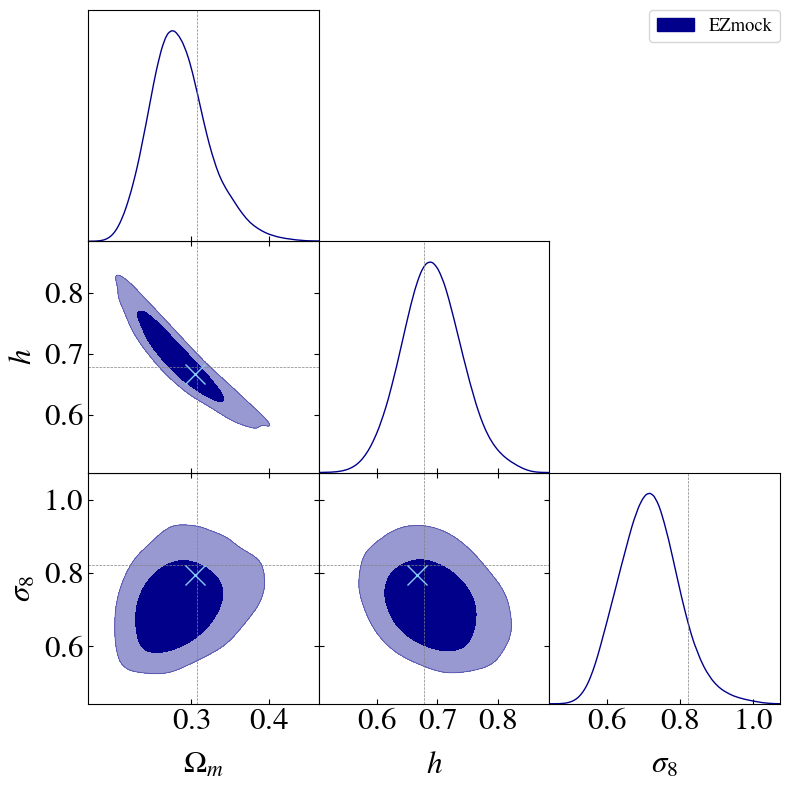

In [1157]:
tri.triangle_plot([patchy_plot_chain[0]],
                #['Omega_m', 'h', 'sigma8'], 
                ['Om', 'hub', 's8',],  
                filled=True,
                legend_labels=["EZmock"],
                legend_loc='upper right', 
                line_args=[{'lw':1, 'color':'darkblue'},],
                contour_colors=['darkblue',],
                markers = [p_truth[c] for c in ['Omega_m', 'h', 'sigma8']],
               )
cosmo = ['Omega_m', 'h', 'sigma8']
for i, ci in enumerate(cosmo[1:]):
    for j, cj in enumerate(cosmo[:-1]):
        if i >= j:
            tri.subplots[i+1,j].plot(patchy_bestfit[cj], patchy_bestfit[ci], 'x', markersize=15, color="lightskyblue")


#plt.savefig("Figures/Patchy.pdf", dpi=1000, facecolor='w')
plt.show()

# BESTFIT MODELES ALTERNATIFS

In [1158]:
basedir = './eBOSS_LCDM_alternative'

## $\Omega_{k}$

### BOSS

In [1159]:
omega_k_woeBOSS_chain, omega_k_woeBOSS_label = load_multi(
    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220701",],
    [r"LSS + Pan - eBOSS [$\Omega_k$]",])

#Bestfit
omega_k_woeBOSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220701", "LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220701")
omega_k_woeBOSS_bestfit['S8'] = omega_k_woeBOSS_bestfit['sigma8']*np.sqrt(omega_k_woeBOSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = omega_k_woeBOSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
stats = sample.getMargeStats().parWithName('Omega_k')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl95.lower, cl95.upper-mean]).reshape(2,-1)
print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','Omega_k']
omega_k_woeBOSS_error = get_errors(omega_k_woeBOSS_chain[0],cosmo)
omega_k_woeBOSS_mean = get_means(omega_k_woeBOSS_chain[0],cosmo)

#Shift
omega_k_woeBOSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',omega_k_woeBOSS_bestfit[i])
        #print(i,':',omega_k_woeBOSS_mean[i])
        omega_k_woeBOSS_shift[i] = omega_k_woeBOSS_mean[i] - omega_k_woeBOSS_bestfit[i]

$-0.032^{+0.062}_{-0.057}$


### eBOSS + BOSS

In [1160]:
omega_k_chain, omega_k_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220501",],
    [r"LSS + Pan [$\Omega_k$]",])

#Bestfit
omega_k_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220501", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220501")
omega_k_bestfit['S8'] = omega_k_bestfit['sigma8']*np.sqrt(omega_k_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = omega_k_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
stats = sample.getMargeStats().parWithName('Omega_k')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl95.lower, cl95.upper-mean]).reshape(2,-1)
print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','Omega_k']
omega_k_error = get_errors(omega_k_chain[0],cosmo)
omega_k_mean = get_means(omega_k_chain[0],cosmo)

#Shift
omega_k_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',omega_k_bestfit[i])
        #print(i,':',omega_k_mean[i])
        omega_k_shift[i] = omega_k_mean[i] - omega_k_bestfit[i]
        #print(i,':',omega_k_shift[i])

$-0.039^{+0.054}_{-0.052}$


### eBOSS + BOSS [$n_s + \omega_b$]

In [1161]:
omega_k_ns_chain, omega_k_ns_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_ns_omega_b_220921",],
    [r"LSS + Pan [$\Omega_k$] [$n_s + \omega_b$]",])

#Bestfit
omega_k_ns_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_ns_omega_b_220921", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_ns_omega_b_220921")
omega_k_ns_bestfit['S8'] = omega_k_ns_bestfit['sigma8']*np.sqrt(omega_k_ns_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = omega_k_ns_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
stats = sample.getMargeStats().parWithName('Omega_k')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','Omega_k']
omega_k_ns_error = get_errors(omega_k_ns_chain[0],cosmo)
omega_k_ns_mean = get_means(omega_k_ns_chain[0],cosmo)

#Shift
omega_k_ns_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',omega_k_ns_bestfit[i])
        #print(i,':',omega_k_ns_mean[i])
        omega_k_ns_shift[i] = omega_k_ns_mean[i] - omega_k_ns_bestfit[i]

$-0.063^{+0.036}_{-0.037}$


In [1165]:
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','Omega_k']
for i in cosmo:
    print(i,':', 2*(omega_k_ns_mean[i] - omega_k_mean[i])/(omega_k_ns_error[i] + omega_k_error[i]))
    #print(i,':', 2*(omega_k_ns_bestfit[i] - omega_k_bestfit[i])/(omega_k_ns_error[i] + omega_k_error[i]))
    #print(i,':', omega_k_ns_error[i] / omega_k_error[i])

Omega_m : 0.49063888496867825
h : 0.6920408075187225
sigma8 : -0.46564246532587367
omega_cdm : 0.9083381151909963
ln10^{10}A_s : -0.7532413931695788
S8 : -0.33168696480627624
Omega_k : -0.7390546975480322


### Planck + LSS

In [1166]:
#omega_k_Pl_LSS_chain, omega_k_Pl_LSS_label = load_multi(
#    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_Planck_data_Omega_k_220606",],
#    [r"LSS + Pan + Planck [$\Omega_k$]",])

omega_k_Pl_LSS_chain, omega_k_Pl_LSS_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_Omega_k_220924",],
    [r"LSS + Pan + Planck [$\Omega_k$]",])

#Bestfit
omega_k_Pl_LSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_Omega_k_220924", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_Omega_k_220924")
omega_k_Pl_LSS_bestfit['S8'] = omega_k_Pl_LSS_bestfit['sigma8']*np.sqrt(omega_k_Pl_LSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = omega_k_Pl_LSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
stats = sample.getMargeStats().parWithName('Omega_k')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl95.lower, cl95.upper-mean]).reshape(2,-1)
print(r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','tau_reio','Omega_k']
omega_k_Pl_LSS_error = get_errors(omega_k_Pl_LSS_chain[0],cosmo)
omega_k_Pl_LSS_mean = get_means(omega_k_Pl_LSS_chain[0],cosmo)

#Shift
omega_k_Pl_LSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',omega_k_Pl_LSS_bestfit[i])
        omega_k_Pl_LSS_shift[i] = omega_k_Pl_LSS_mean[i] - omega_k_Pl_LSS_bestfit[i]

$0.0008^{+0.0034}_{-0.0034}$


### Planck + LSS (BAO/fs8)

In [1167]:
omega_k_Pl_LSS_BAOfs8_chain, omega_k_Pl_LSS_BAOfs8_label = load_multi(
    ["LCDM_fsigma8_BOSS_eBOSS_Pan_BAOsmallz_Lyalpha_newPlanck_data_Omega_k_221010",],
    [r"LSS + Pan + Planck [$\Omega_k$] BAO/fs8",])

sample = omega_k_Pl_LSS_BAOfs8_chain[0]
p=sample.getParams()
stats = sample.getMargeStats().parWithName('Omega_k')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.4f^{+%.4f}_{-%.4f}$' % (mean, err[1], err[0]))

$0.0013^{+0.0017}_{-0.0017}$


### LSS (BAO/fs8)

In [1168]:
omega_k_LSS_BAOfs8_chain, omega_k_LSS_BAOfs8_label = load_multi(
    ["LCDM_fsigma8_BOSS_eBOSS_Pan_BAOsmallz_Lyalpha_data_Omega_k_221023",],
    [r"LSS + Pan [$\Omega_k$] BAO/fs8",])

cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','Omega_k']

sample = omega_k_LSS_BAOfs8_chain[0]
p=sample.getParams()
stats = sample.getMargeStats().parWithName('Omega_k')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))


#tri.triangle_plot([omega_k_LSS_BAOfs8_chain[0]],
#                cosmo,
#                filled=True,
#                legend_labels=[omega_k_LSS_BAOfs8_label[0]],
#                legend_loc='upper right', 
#                line_args=[{'lw':1, 'color':'darkblue'},],
#                contour_colors=['darkblue',],
#               )

$-0.037^{+0.067}_{-0.053}$


## $w_{\rm DE}$

### BOSS

In [1169]:
w_de_woeBOSS_chain, w_de_woeBOSS_label = load_multi(
    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_220701",],
    [r"LSS + Pan - eBOSS [$w_{\rm DE}$]",])

#Bestfit
w_de_woeBOSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_220701", "LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_220701")
w_de_woeBOSS_bestfit['S8'] = w_de_woeBOSS_bestfit['sigma8']*np.sqrt(w_de_woeBOSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = w_de_woeBOSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
stats = sample.getMargeStats().parWithName('w0_fld')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','w0_fld']
w_de_woeBOSS_error = get_errors(w_de_woeBOSS_chain[0],cosmo)
w_de_woeBOSS_mean = get_means(w_de_woeBOSS_chain[0],cosmo)

#Shift
w_de_woeBOSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',w_de_woeBOSS_bestfit[i])
        #print(i,':',w_de_woeBOSS_mean[i])
        w_de_woeBOSS_shift[i] = w_de_woeBOSS_mean[i] - w_de_woeBOSS_bestfit[i]

$-1.015^{+0.042}_{-0.042}$


### eBOSS + BOSS

In [1170]:
w_de_chain, w_de_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_220507",],
    [r"LSS + Pan [$w_{\rm DE}$]",])

#Bestfit
w_de_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_220507", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_220507")
w_de_bestfit['S8'] = w_de_bestfit['sigma8']*np.sqrt(w_de_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = w_de_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
stats = sample.getMargeStats().parWithName('w0_fld')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','w0_fld']
w_de_error = get_errors(w_de_chain[0],cosmo)
w_de_mean = get_means(w_de_chain[0],cosmo)

#Shift
w_de_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',w_de_bestfit[i])
        #print(i,':',w_de_mean[i])
        w_de_shift[i] = w_de_mean[i] - w_de_bestfit[i]

$-1.038^{+0.041}_{-0.041}$


### eBOSS + BOSS [$n_s + \omega_b$]

In [1171]:
w_de_ns_chain, w_de_ns_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_ns_omega_b_220921",],
    [r"LSS + Pan [$w_{\rm DE}$] [$n_s + \omega_b$]",])

#Bestfit
w_de_ns_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_ns_omega_b_220921", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_ns_omega_b_220921")
w_de_ns_bestfit['S8'] = w_de_ns_bestfit['sigma8']*np.sqrt(w_de_ns_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = w_de_ns_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
stats = sample.getMargeStats().parWithName('w0_fld')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','w0_fld']
w_de_ns_error = get_errors(w_de_ns_chain[0],cosmo)
w_de_ns_mean = get_means(w_de_ns_chain[0],cosmo)

#Shift
w_de_ns_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',w_de_ns_bestfit[i])
        #print(i,':',w_de_ns_mean[i])
        w_de_ns_shift[i] = w_de_ns_mean[i] - w_de_ns_bestfit[i]

$-1.018^{+0.047}_{-0.043}$


In [1174]:
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','w0_fld']
for i in cosmo:
    print(i,':', 2*(w_de_ns_mean[i] - w_de_mean[i])/(w_de_ns_error[i] + w_de_error[i]))
    #print(i,':', 2*(w_de_ns_bestfit[i] - w_de_bestfit[i])/(w_de_ns_error[i] + w_de_error[i]))
    #print(i,':', w_de_ns_error[i] / w_de_error[i])

Omega_m : -0.9056502909124847
h : -0.08941965412825956
sigma8 : 1.0873109500299316
omega_cdm : -0.7815377343660395
ln10^{10}A_s : 1.2564534780822485
S8 : 0.8001734444149892
w0_fld : 0.4601745338570796


### LSS + Planck

In [1175]:
#w_de_Pl_LSS_chain, w_de_Pl_LSS_label = load_multi(
#    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_Planck_data_w_de_220516",],
#    [r"LSS + Pan + Planck [$w_{\rm DE}$]",])
w_de_Pl_LSS_chain, w_de_Pl_LSS_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_w_de_220924",],
    [r"LSS + Pan + Planck [$w_{\rm DE}$]",])

#Bestfit
w_de_Pl_LSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_w_de_220924", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_w_de_220924")
w_de_Pl_LSS_bestfit['S8'] = w_de_Pl_LSS_bestfit['sigma8']*np.sqrt(w_de_Pl_LSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = w_de_Pl_LSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
stats = sample.getMargeStats().parWithName('w0_fld')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl95.lower, cl95.upper-mean]).reshape(2,-1)
print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','tau_reio','w0_fld']
w_de_Pl_LSS_error = get_errors(w_de_Pl_LSS_chain[0],cosmo)
w_de_Pl_LSS_mean = get_means(w_de_Pl_LSS_chain[0],cosmo)

#Shift
w_de_Pl_LSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',w_de_Pl_LSS_bestfit[i])
        w_de_Pl_LSS_shift[i] = w_de_Pl_LSS_mean[i] - w_de_Pl_LSS_bestfit[i]

$-1.039^{+0.055}_{-0.059}$


### Planck + LSS (BAO/fs8)

In [1176]:
w_de_Pl_LSS_BAOfs8_chain, w_de_Pl_LSS_BAOfs8_label = load_multi(
    ["LCDM_fsigma8_BOSS_eBOSS_Pan_BAOsmallz_Lyalpha_newPlanck_data_w_de_221010",], 
    [r"LSS + Pan + Planck [$w_{\rm DE}$] BAO/fs8",])

sample = w_de_Pl_LSS_BAOfs8_chain[0]
p=sample.getParams()
stats = sample.getMargeStats().parWithName('w0_fld')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))

$-1.043^{+0.030}_{-0.030}$


### LSS (BAO/fs8)

In [1177]:
w_de_LSS_BAOfs8_chain, w_de_LSS_BAOfs8_label = load_multi(
    ["LCDM_fsigma8_BOSS_eBOSS_Pan_BAOsmallz_Lyalpha_data_w_de_221023",], 
    [r"LSS + Pan [$w_{\rm DE}$] BAO/fs8",])

cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','w0_fld']

sample = w_de_LSS_BAOfs8_chain[0]
stats = sample.getMargeStats().parWithName('w0_fld')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))

#tri.triangle_plot([w_de_LSS_BAOfs8_chain[0]],
#                cosmo,
#                filled=True,
#                legend_labels=[w_de_LSS_BAOfs8_chain[0]],
#                legend_loc='upper right', 
#                line_args=[{'lw':1, 'color':'darkblue'},],
#                contour_colors=['darkblue',],
#               )

$-0.961^{+0.054}_{-0.042}$


## $M_{\nu}$ 1 neutrino

### BOSS

In [1178]:
Mnu_1_woeBOSS_chain, Mnu_1_woeBOSS_label = load_multi(
    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_220621",],
    [r"LSS + Pan - eBOSS [$M_{\nu}$ 1]",])

#Bestfit
Mnu_1_woeBOSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_220621", "LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_220621")
Mnu_1_woeBOSS_bestfit['S8'] = Mnu_1_woeBOSS_bestfit['sigma8']*np.sqrt(Mnu_1_woeBOSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Mnu_1_woeBOSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
Mnu_1_woeBOSS_chain[0].addDerived(Mnu_1_woeBOSS_chain[0].getParams().m_ncdm, name='M_nu', range=[0., 1.], label=r'\Sigma m_\nu')
print(Mnu_1_woeBOSS_chain[0].getInlineLatex('M_nu',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','m_ncdm']
Mnu_1_woeBOSS_error = get_errors(Mnu_1_woeBOSS_chain[0],cosmo)
Mnu_1_woeBOSS_mean = get_means(Mnu_1_woeBOSS_chain[0],cosmo)

#Shift
Mnu_1_woeBOSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Mnu_1_woeBOSS_bestfit[i])
        Mnu_1_woeBOSS_shift[i] = Mnu_1_woeBOSS_mean[i] - Mnu_1_woeBOSS_bestfit[i]

\Sigma m_\nu < 0.429


### eBOSS + BOSS

In [1179]:
Mnu_1_chain, Mnu_1_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_220621",],
    [r"LSS + Pan [$M_{\nu}$ 1]",])

#Bestfit
Mnu_1_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_220621", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_220621")
Mnu_1_bestfit['S8'] = Mnu_1_bestfit['sigma8']*np.sqrt(Mnu_1_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Mnu_1_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
Mnu_1_chain[0].addDerived(Mnu_1_chain[0].getParams().m_ncdm, name='M_nu', range=[0., 1.], label=r'\Sigma m_\nu')
print(Mnu_1_chain[0].getInlineLatex('M_nu',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','m_ncdm']
Mnu_1_error = get_errors(Mnu_1_chain[0],cosmo)
Mnu_1_mean = get_means(Mnu_1_chain[0],cosmo)

#Shift
Mnu_1_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Mnu_1_bestfit[i])
        Mnu_1_shift[i] = Mnu_1_mean[i] - Mnu_1_bestfit[i]

\Sigma m_\nu < 0.274


### eBOSS + BOSS [$n_s + \omega_b$]

In [1180]:
Mnu_1_ns_chain, Mnu_1_ns_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_ns_omega_b_220621",],
    [r"LSS + Pan [$M_{\nu}$ 1] [$n_s + \omega_b$]",])

#Bestfit
Mnu_1_ns_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_ns_omega_b_220621", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_ns_omega_b_220621")
Mnu_1_ns_bestfit['S8'] = Mnu_1_ns_bestfit['sigma8']*np.sqrt(Mnu_1_ns_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Mnu_1_ns_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
Mnu_1_ns_chain[0].addDerived(Mnu_1_ns_chain[0].getParams().m_ncdm, name='M_nu', range=[0., 1.], label=r'\Sigma m_\nu')
print(Mnu_1_ns_chain[0].getInlineLatex('M_nu',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','m_ncdm']
Mnu_1_ns_error = get_errors(Mnu_1_ns_chain[0],cosmo)
Mnu_1_ns_mean = get_means(Mnu_1_ns_chain[0],cosmo)

#Shift
Mnu_1_ns_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Mnu_1_ns_bestfit[i])
        Mnu_1_ns_shift[i] = Mnu_1_ns_mean[i] - Mnu_1_ns_bestfit[i]

\Sigma m_\nu < 0.777


### LSS + Planck

In [1181]:
Mnu_1_Pl_LSS_chain, Mnu_1_Pl_LSS_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_1nu_220924",],
    [r"LSS + Pan + Planck [$M_{\nu}$ 1]",])

#Bestfit
Mnu_1_Pl_LSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_1nu_220924", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_1nu_220924")
Mnu_1_Pl_LSS_bestfit['S8'] = Mnu_1_Pl_LSS_bestfit['sigma8']*np.sqrt(Mnu_1_Pl_LSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Mnu_1_Pl_LSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
Mnu_1_Pl_LSS_chain[0].addDerived(Mnu_1_Pl_LSS_chain[0].getParams().m_ncdm, name='M_nu', range=[0., 1.], label=r'\Sigma m_\nu')
print(Mnu_1_Pl_LSS_chain[0].getInlineLatex('M_nu',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','tau_reio','m_ncdm']
Mnu_1_Pl_LSS_error = get_errors(Mnu_1_Pl_LSS_chain[0],cosmo)
Mnu_1_Pl_LSS_mean = get_means(Mnu_1_Pl_LSS_chain[0],cosmo)

#Shift
Mnu_1_Pl_LSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Mnu_1_Pl_LSS_bestfit[i])
        Mnu_1_Pl_LSS_shift[i] = Mnu_1_Pl_LSS_mean[i] - Mnu_1_Pl_LSS_bestfit[i]

\Sigma m_\nu < 0.0927


### LSS + Planck (BAO/fs8)

In [1182]:
Mnu_1_Pl_LSS_BAOfs8_chain, Mnu_1_Pl_LSS_BAOfs8_label = load_multi(
    ["LCDM_fsigma8_BOSS_eBOSS_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_1nu_221010",],
    [r"LSS + Pan + Planck [$M_{\nu}$ 1] BAO/fs8",])

Mnu_1_Pl_LSS_BAOfs8_chain[0].addDerived(Mnu_1_Pl_LSS_BAOfs8_chain[0].getParams().m_ncdm, name='M_nu', range=[0., 1.], label=r'\Sigma m_\nu')
print(Mnu_1_Pl_LSS_BAOfs8_chain[0].getInlineLatex('M_nu',limit=2))

\Sigma m_\nu < 0.0804


### LSS (BAO/fs8)

\Sigma m_\nu < 4.84


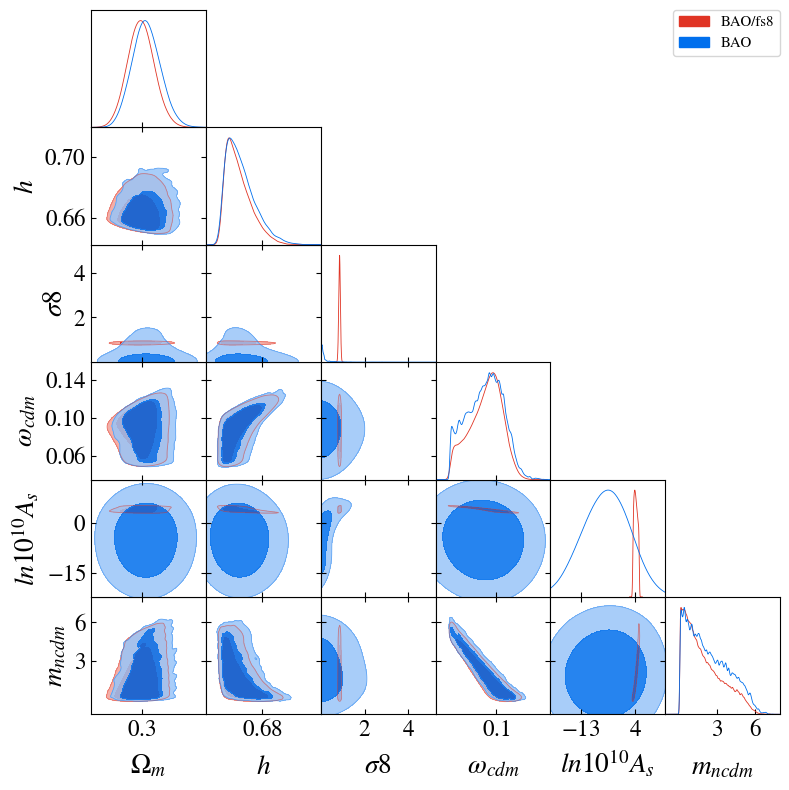

In [1183]:
tri.settings.axes_fontsize = 21

Mnu_1_LSS_BAOfs8_chain, Mnu_1_LSS_BAOfs8_label = load_multi(
    ["LCDM_fsigma8_BOSS_eBOSS_Pan_BAOsmallz_Lyalpha_data_M_1nu_221025",],
    [r"LSS + Pan [$M_{\nu}$ 1] BAO/fs8",])

Mnu_1_LSS_BAO_chain, Mnu_1_LSS_BAO_label = load_multi(
    ["LCDM_fs8_no_BAO_BOSS_eBOSS_Pan_BAOsmallz_Lyalpha_data_M_1nu_221025",],
    [r"LSS + Pan [$M_{\nu}$ 1] BAO",])

planck_Mnu_1 = load_chain("Planck_M_1_nu_221002", truth=None, basedir=basedir)

cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','m_ncdm']

#tri.triangle_plot([Mnu_1_LSS_BAOfs8_chain[0],planck_Mnu_1],
#                cosmo,
#                filled=True,
#                legend_labels=["BAO/fs8", "Planck"],
#                legend_loc='upper right', 
#                #line_args=[{'lw':1, 'color':'darkblue'},],
#                #contour_colors=['darkblue',],
#               )
#plt.savefig("Figures/fs8_LSS_Mnu.pdf", dpi=1000, facecolor='w')


tri.triangle_plot([Mnu_1_LSS_BAOfs8_chain[0],Mnu_1_LSS_BAO_chain[0]],
                cosmo,
                filled=True,
                legend_labels=["BAO/fs8", "BAO"],
                legend_loc='upper right', 
                #line_args=[{'lw':1, 'color':'darkblue'},],
                #contour_colors=['darkblue',],
               )
plt.savefig("Figures/fs8_BAO_Mnu.pdf", dpi=1000, facecolor='w')



Mnu_1_LSS_BAOfs8_chain[0].addDerived(Mnu_1_LSS_BAOfs8_chain[0].getParams().m_ncdm, name='M_nu', range=[0., 1.], label=r'\Sigma m_\nu')
print(Mnu_1_LSS_BAOfs8_chain[0].getInlineLatex('M_nu',limit=2))

tri.settings.axes_fontsize = 24

## $N_{\nu}$

### BOSS

In [1184]:
Nnu_woeBOSS_chain, Nnu_woeBOSS_label = load_multi(
    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_220701",],
    [r"LSS + PAN - eBOSS [$N_{\nu}$]",])

#Bestfit
Nnu_woeBOSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_220701", "LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_220701")
Nnu_woeBOSS_bestfit['S8'] = Nnu_woeBOSS_bestfit['sigma8']*np.sqrt(Nnu_woeBOSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Nnu_woeBOSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
sample.addDerived(p.N_ur - 2.0328, name='Neff', label=r'N_eff')
stats = sample.getMargeStats().parWithName('Neff')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','N_ur']
Nnu_woeBOSS_error = get_errors(Nnu_woeBOSS_chain[0],cosmo)
Nnu_woeBOSS_mean = get_means(Nnu_woeBOSS_chain[0],cosmo)

#Shift
Nnu_woeBOSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Nnu_woeBOSS_bestfit[i])
        #print(i,':',Nnu_woeBOSS_mean[i])
        Nnu_woeBOSS_shift[i] = Nnu_woeBOSS_mean[i] - Nnu_woeBOSS_bestfit[i]

$0.82^{+0.62}_{-1.08}$


### BOSS + eBOSS

In [1185]:
Nnu_chain, Nnu_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_220506",],
    [r"LSS + PAN [$N_{\nu}$]",])

#Bestfit
Nnu_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_220506", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_220506")
Nnu_bestfit['S8'] = Nnu_bestfit['sigma8']*np.sqrt(Nnu_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Nnu_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
sample.addDerived(p.N_ur - 2.0328, name='Neff', label=r'N_eff')
stats = sample.getMargeStats().parWithName('Neff')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','N_ur']
Nnu_error = get_errors(Nnu_chain[0],cosmo)
Nnu_mean = get_means(Nnu_chain[0],cosmo)

#Shift
Nnu_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Nnu_bestfit[i])
        #print(i,':',Nnu_mean[i])
        Nnu_shift[i] = Nnu_mean[i] - Nnu_bestfit[i]

$0.40^{+0.44}_{-0.91}$


### eBOSS + BOSS [$n_s + \omega_b$]

In [1186]:
Nnu_ns_chain, Nnu_ns_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_ns_omega_b_220921",],
    [r"LSS + PAN [$N_{\nu}$]",])

#Bestfit
Nnu_ns_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_ns_omega_b_220921", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_ns_omega_b_220921")
Nnu_ns_bestfit['S8'] = Nnu_ns_bestfit['sigma8']*np.sqrt(Nnu_ns_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Nnu_ns_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
#sample.addDerived(p.N_ur - 2.0328, name='Neff', label=r'N_eff')
sample.addDerived(p.N_ur - 2.0328, name='Neff', label=r'N_eff')
stats = sample.getMargeStats().parWithName('Neff')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
print(r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','N_ur']
Nnu_ns_error = get_errors(Nnu_ns_chain[0],cosmo)
Nnu_ns_mean = get_means(Nnu_ns_chain[0],cosmo)

#Shift
Nnu_ns_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Nnu_ns_bestfit[i])
        #print(i,':',Nnu_ns_mean[i])
        Nnu_ns_shift[i] = Nnu_ns_mean[i] - Nnu_ns_bestfit[i]

$0.48^{+0.47}_{-0.86}$


In [1189]:
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','N_ur']
for i in cosmo:
    print(i,':', 2*(Nnu_ns_mean[i] - Nnu_mean[i])/(Nnu_ns_error[i] + Nnu_error[i]))
    #print(i,':', 2*(Nnu_ns_bestfit[i] - Nnu_bestfit[i])/(Nnu_ns_error[i] + Nnu_error[i]))
    #print(i,':', Nnu_ns_error[i] / Nnu_error[i])

Omega_m : -0.3607149098407865
h : 0.05221023398411896
sigma8 : 0.14697254625131942
omega_cdm : -0.13700502671665618
ln10^{10}A_s : 0.2223793255617194
S8 : 0.002676677958719009
N_ur : 0.11516946249442432


### LSS + Planck

In [1055]:
#Nnu_Pl_LSS_chain, Nnu_Pl_LSS_label = load_multi(
#    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_Planck_data_N_ur_220516",],
#    [r"LSS + PAN + Planck [$N_{\nu}$]",])
Nnu_Pl_LSS_chain, Nnu_Pl_LSS_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_N_ur_220924",],
    [r"LSS + PAN + Planck [$N_{\nu}$]",])


#Bestfit
Nnu_Pl_LSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_N_ur_220924", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_N_ur_220924")
Nnu_Pl_LSS_bestfit['S8'] = Nnu_Pl_LSS_bestfit['sigma8']*np.sqrt(Nnu_Pl_LSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Nnu_Pl_LSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
sample.addDerived(p.N_ur - 2.0328, name='Neff', label=r'N_eff')
stats = sample.getMargeStats().parWithName('Neff')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl95.lower, cl95.upper-mean]).reshape(2,-1)
print(r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','tau_reio','N_ur']
Nnu_Pl_LSS_error = get_errors(Nnu_Pl_LSS_chain[0],cosmo)
Nnu_Pl_LSS_mean = get_means(Nnu_Pl_LSS_chain[0],cosmo)

#Shift
Nnu_Pl_LSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Nnu_Pl_LSS_bestfit[i])
        Nnu_Pl_LSS_shift[i] = Nnu_Pl_LSS_mean[i] - Nnu_Pl_LSS_bestfit[i]

$-0.07^{+0.30}_{-0.29}$


### LSS + Planck (BAO/fs8)

In [1059]:
Nnu_Pl_LSS_BAOfs8_chain, Nnu_Pl_LSS_BAOfs8_label = load_multi(
    ["LCDM_fsigma8_BOSS_eBOSS_Pan_BAOsmallz_Lyalpha_newPlanck_data_N_ur_221010",],
    [r"LSS + Pan + Planck [$N_{\nu}$ BAO/fs8]",])

sample = Nnu_Pl_LSS_BAOfs8_chain[0]
p=sample.getParams()
sample.addDerived(p.N_ur - 2.0328, name='Neff', label=r'N_eff')
stats = sample.getMargeStats().parWithName('Neff')
mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
err = np.array([mean-cl95.lower, cl95.upper-mean]).reshape(2,-1)
print(r'$%.2f^{+%.2f}_{-%.2f}$' % (mean, err[1], err[0]))

$0.05^{+0.33}_{-0.31}$


### LSS (BAO/fs8)

In [964]:
Nnu_LSS_BAOfs8_chain, Nnu_LSS_BAOfs8_label = load_multi(
    ["LCDM_fsigma8_BOSS_eBOSS_Pan_BAOsmallz_Lyalpha_data_N_ur_221024",],
    [r"LSS + Pan [$N_{\nu}$ BAO/fs8]",])


cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','N_ur']

#tri.triangle_plot([Nnu_LSS_BAOfs8_chain[0]],
#                cosmo,
#                filled=True,
#                legend_labels=[Nnu_LSS_BAOfs8_label[0]],
#                legend_loc='upper right', 
#                line_args=[{'lw':1, 'color':'darkblue'},],
#                contour_colors=['darkblue',],
#               )

# PLOT MODELES ALTERNATIFS

In [81]:
basedir = './eBOSS_LCDM_alternative'

In [82]:
"""
# Omega k

planck_omega_k = load_chain("Planck_Omega_k_220513", truth=None, basedir=basedir)
omega_k_plot_chain, omega_k_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220501",],
    [r"LSS + Pan [$\Omega_k$]",])
omega_k_Pl_LSS_plot_chain, omega_k_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_Planck_data_Omega_k_220606",],
    [r"LSS + Pan + Planck [$\Omega_k$]",])
omega_k_woeBOSS_plot_chain, omega_k_woeBOSS_plot_label = load_multi(
    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220701",],
    [r"LSS + Pan - eBOSS [$\Omega_k$]",])

p=planck_omega_k.getParams()
planck_omega_k.addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
planck_omega_k.addDerived(p.h, name='hub', label=r'h')
planck_omega_k.addDerived(p.sigma8, name='s8', label=r'\sigma_8')
planck_omega_k.addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
planck_omega_k.addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
planck_omega_k.addDerived(p.Omega_k, name='Ok', label=r'\Omega_{\rm k}')

p=omega_k_plot_chain[0].getParams()
omega_k_plot_chain[0].addDerived(p.Omega_m - omega_k_shift['Omega_m'], name='Om', label=r'\Omega_m')
omega_k_plot_chain[0].addDerived(p.h - omega_k_shift['h'], name='hub', label=r'h')
omega_k_plot_chain[0].addDerived(p.sigma8 - omega_k_shift['sigma8'], name='s8', label=r'\sigma_8')
omega_k_plot_chain[0].addDerived(p.omega_cdm - omega_k_shift['omega_cdm'], name='ocdm', label=r'\omega_{\rm cdm}')
omega_k_plot_chain[0].addDerived(np.log(10**10*p.A_s) - omega_k_shift['ln10^{10}A_s'], name='lnAS', label=r'\ln 10^{10}A_s')
omega_k_plot_chain[0].addDerived(p.Omega_k - omega_k_shift['Omega_k'], name='Ok', label=r'\Omega_{\rm k}')

p=omega_k_Pl_LSS_plot_chain[0].getParams()
omega_k_Pl_LSS_plot_chain[0].addDerived(p.Omega_m - omega_k_Pl_LSS_shift['Omega_m'], name='Om', label=r'\Omega_m')
omega_k_Pl_LSS_plot_chain[0].addDerived(p.h - omega_k_Pl_LSS_shift['h'], name='hub', label=r'h')
omega_k_Pl_LSS_plot_chain[0].addDerived(p.sigma8 - omega_k_Pl_LSS_shift['sigma8'], name='s8', label=r'\sigma_8')
omega_k_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm - omega_k_Pl_LSS_shift['omega_cdm'], name='ocdm', label=r'\omega_{\rm cdm}')
omega_k_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s) - omega_k_Pl_LSS_shift['ln10^{10}A_s'], name='lnAS', label=r'\ln 10^{10}A_s')
omega_k_Pl_LSS_plot_chain[0].addDerived(p.Omega_k - omega_k_Pl_LSS_shift['Omega_k'], name='Ok', label=r'\Omega_{\rm k}')





#w_de

planck_w_de = load_chain("Planck_wde_220513", truth=None, basedir=basedir)
w_de_plot_chain, w_de_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_220507",],
    [r"LSS + Pan [$w_{\rm DE}$]",])
w_de_Pl_LSS_plot_chain, w_de_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_Planck_data_w_de_220516",],
    [r"LSS + Pan + Planck [$w_{\rm DE}$]",])

p=planck_w_de.getParams()
planck_w_de.addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
planck_w_de.addDerived(p.h, name='hub', label=r'h')
planck_w_de.addDerived(p.sigma8, name='s8', label=r'\sigma_8')
planck_w_de.addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
planck_w_de.addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
planck_w_de.addDerived(p.w0_fld, name='w_de', label=r'w_0')

p=w_de_plot_chain[0].getParams()
w_de_plot_chain[0].addDerived(p.Omega_m - w_de_shift['Omega_m'], name='Om', label=r'\Omega_m')
w_de_plot_chain[0].addDerived(p.h - w_de_shift['h'], name='hub', label=r'h')
w_de_plot_chain[0].addDerived(p.sigma8 - w_de_shift['sigma8'], name='s8', label=r'\sigma_8')
w_de_plot_chain[0].addDerived(p.omega_cdm - w_de_shift['omega_cdm'], name='ocdm', label=r'\omega_{\rm cdm}')
w_de_plot_chain[0].addDerived(np.log(10**10*p.A_s) - w_de_shift['ln10^{10}A_s'], name='lnAS', label=r'\ln 10^{10}A_s')
w_de_plot_chain[0].addDerived(p.w0_fld - w_de_shift['w0_fld'], name='w_de', label=r'w_0')

p=w_de_Pl_LSS_plot_chain[0].getParams()
w_de_Pl_LSS_plot_chain[0].addDerived(p.Omega_m - w_de_Pl_LSS_shift['Omega_m'], name='Om', label=r'\Omega_m')
w_de_Pl_LSS_plot_chain[0].addDerived(p.h - w_de_Pl_LSS_shift['h'], name='hub', label=r'h')
w_de_Pl_LSS_plot_chain[0].addDerived(p.sigma8 - w_de_Pl_LSS_shift['sigma8'], name='s8', label=r'\sigma_8')
w_de_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm - w_de_Pl_LSS_shift['omega_cdm'], name='ocdm', label=r'\omega_{\rm cdm}')
w_de_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s) - w_de_Pl_LSS_shift['ln10^{10}A_s'], name='lnAS', label=r'\ln 10^{10}A_s')
w_de_Pl_LSS_plot_chain[0].addDerived(p.w0_fld - w_de_Pl_LSS_shift['w0_fld'], name='w_de', label=r'w_0')





#M_nu

planck_Mnu = load_chain("Planck_M_nu_220513", truth=None, basedir=basedir)
Mnu_plot_chain, Mnu_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_220501",],
    [r"LSS + Pan [$M_{\nu}$]",])
Mnu_Pl_LSS_plot_chain, Mnu_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_Planck_data_M_nu_220515",],
    [r"LSS + Pan + Planck [$M_{\nu}$]",])

p=planck_Mnu.getParams()
planck_Mnu.addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
planck_Mnu.addDerived(p.h, name='hub', label=r'h')
planck_Mnu.addDerived(p.sigma8, name='s8', label=r'\sigma_8')
planck_Mnu.addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
planck_Mnu.addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
planck_Mnu.addDerived(p.M_tot_NH, name='M_nu', label=r'\sum m_{\nu}')

p=Mnu_plot_chain[0].getParams()
Mnu_plot_chain[0].addDerived(p.Omega_m - Mnu_shift['Omega_m'], name='Om', label=r'\Omega_m')
Mnu_plot_chain[0].addDerived(p.h - Mnu_shift['h'], name='hub', label=r'h')
Mnu_plot_chain[0].addDerived(p.sigma8 - Mnu_shift['sigma8'], name='s8', label=r'\sigma_8')
Mnu_plot_chain[0].addDerived(p.omega_cdm - Mnu_shift['omega_cdm'], name='ocdm', label=r'\omega_{\rm cdm}')
Mnu_plot_chain[0].addDerived(np.log(10**10*p.A_s) - Mnu_shift['ln10^{10}A_s'], name='lnAS', label=r'\ln 10^{10}A_s')
Mnu_plot_chain[0].addDerived(p.M_tot_NH, name='M_nu', label=r'\sum m_{\nu}')

p=Mnu_Pl_LSS_plot_chain[0].getParams()
Mnu_Pl_LSS_plot_chain[0].addDerived(p.Omega_m - Mnu_Pl_LSS_shift['Omega_m'], name='Om', label=r'\Omega_m')
Mnu_Pl_LSS_plot_chain[0].addDerived(p.h - Mnu_Pl_LSS_shift['h'], name='hub', label=r'h')
Mnu_Pl_LSS_plot_chain[0].addDerived(p.sigma8 - Mnu_Pl_LSS_shift['sigma8'], name='s8', label=r'\sigma_8')
Mnu_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm - Mnu_Pl_LSS_shift['omega_cdm'], name='ocdm', label=r'\omega_{\rm cdm}')
Mnu_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s) - Mnu_Pl_LSS_shift['ln10^{10}A_s'], name='lnAS', label=r'\ln 10^{10}A_s')
Mnu_Pl_LSS_plot_chain[0].addDerived(p.M_tot_NH, name='M_nu', label=r'\sum m_{\nu}')






#Neff

planck_Nnu = load_chain("Planck_Neff_220513", truth=None, basedir=basedir)
Nnu_plot_chain, Nnu_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_220506",],
    [r"LSS + PAN [$N_{\nu}$]",])
Nnu_Pl_LSS_plot_chain, Nnu_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_Planck_data_N_ur_220516",],
    [r"LSS + PAN + Planck [$N_{\nu}$]",])

p=planck_Nnu.getParams()
planck_Nnu.addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
planck_Nnu.addDerived(p.h, name='hub', label=r'h')
planck_Nnu.addDerived(p.sigma8, name='s8', label=r'\sigma_8')
planck_Nnu.addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
planck_Nnu.addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
planck_Nnu.addDerived(planck_Nnu.getParams().N_ur, name='N_nu', label=r'\Delta N_{\rm eff}')

p=Nnu_plot_chain[0].getParams()
Nnu_plot_chain[0].addDerived(p.Omega_m - Nnu_shift['Omega_m'], name='Om', label=r'\Omega_m')
Nnu_plot_chain[0].addDerived(p.h - Nnu_shift['h'], name='hub', label=r'h')
Nnu_plot_chain[0].addDerived(p.sigma8 - Nnu_shift['sigma8'], name='s8', label=r'\sigma_8')
Nnu_plot_chain[0].addDerived(p.omega_cdm - Nnu_shift['omega_cdm'], name='ocdm', label=r'\omega_{\rm cdm}')
Nnu_plot_chain[0].addDerived(np.log(10**10*p.A_s) - Nnu_shift['ln10^{10}A_s'], name='lnAS', label=r'\ln 10^{10}A_s')
Nnu_plot_chain[0].addDerived(p.N_ur - Nnu_shift['N_ur'], name='N_nu', label=r'\Delta N_{\rm eff}')

p=Nnu_Pl_LSS_plot_chain[0].getParams()
Nnu_Pl_LSS_plot_chain[0].addDerived(p.Omega_m - Nnu_Pl_LSS_shift['Omega_m'], name='Om', label=r'\Omega_m')
Nnu_Pl_LSS_plot_chain[0].addDerived(p.h - Nnu_Pl_LSS_shift['h'], name='hub', label=r'h')
Nnu_Pl_LSS_plot_chain[0].addDerived(p.sigma8 - Nnu_Pl_LSS_shift['sigma8'], name='s8', label=r'\sigma_8')
Nnu_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm - Nnu_Pl_LSS_shift['omega_cdm'], name='ocdm', label=r'\omega_{\rm cdm}')
Nnu_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s) - Nnu_Pl_LSS_shift['ln10^{10}A_s'], name='lnAS', label=r'\ln 10^{10}A_s')
Nnu_Pl_LSS_plot_chain[0].addDerived(p.N_ur - Nnu_Pl_LSS_shift['N_ur'], name='N_nu', label=r'\Delta N_{\rm eff}')
"""

'\n# Omega k\n\nplanck_omega_k = load_chain("Planck_Omega_k_220513", truth=None, basedir=basedir)\nomega_k_plot_chain, omega_k_plot_label = load_multi(\n    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220501",],\n    [r"LSS + Pan [$\\Omega_k$]",])\nomega_k_Pl_LSS_plot_chain, omega_k_Pl_LSS_plot_label = load_multi(\n    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_Planck_data_Omega_k_220606",],\n    [r"LSS + Pan + Planck [$\\Omega_k$]",])\nomega_k_woeBOSS_plot_chain, omega_k_woeBOSS_plot_label = load_multi(\n    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220701",],\n    [r"LSS + Pan - eBOSS [$\\Omega_k$]",])\n\np=planck_omega_k.getParams()\nplanck_omega_k.addDerived(p.Omega_m, name=\'Om\', label=r\'\\Omega_m\')\nplanck_omega_k.addDerived(p.h, name=\'hub\', label=r\'h\')\nplanck_omega_k.addDerived(p.sigma8, name=\'s8\', label=r\'\\sigma_8\')\nplanck_omega_k.addDerived(p.omega_cdm, name=\'ocdm\', label=r\'\\omega_{\rm cdm}\')\nplanck_omega_k.addDerived(np.log(10**10*p.

In [83]:
# Omega k

planck_omega_k = load_chain("Planck_Omega_k_220513", truth=None, basedir=basedir)
omega_k_plot_chain, omega_k_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_220501",],
    [r"LSS + Pan [$\Omega_k$]",])
omega_k_Pl_LSS_plot_chain, omega_k_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_Omega_k_220924",],
    [r"LSS + Pan + Planck [$\Omega_k$]",])
omega_k_ns_plot_chain, omega_k_ns_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_Omega_k_ns_omega_b_220921",],
    [r"LSS + Pan [$\Omega_k$] [$n_s + \omega_b$]",])

p=planck_omega_k.getParams()
planck_omega_k.addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
planck_omega_k.addDerived(p.h, name='hub', label=r'h')
planck_omega_k.addDerived(p.sigma8, name='s8', label=r'\sigma_8')
planck_omega_k.addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
planck_omega_k.addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
planck_omega_k.addDerived(p.Omega_k, name='Ok', label=r'\Omega_{\rm k}')
planck_omega_k.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=omega_k_plot_chain[0].getParams()
omega_k_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
omega_k_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
omega_k_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
omega_k_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
omega_k_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
omega_k_plot_chain[0].addDerived(p.Omega_k, name='Ok', label=r'\Omega_{\rm k}')
omega_k_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=omega_k_Pl_LSS_plot_chain[0].getParams()
omega_k_Pl_LSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
omega_k_Pl_LSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
omega_k_Pl_LSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
omega_k_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
omega_k_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
omega_k_Pl_LSS_plot_chain[0].addDerived(p.Omega_k, name='Ok', label=r'\Omega_{\rm k}')
omega_k_Pl_LSS_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=omega_k_ns_plot_chain[0].getParams()
omega_k_ns_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
omega_k_ns_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
omega_k_ns_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
omega_k_ns_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
omega_k_ns_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
omega_k_ns_plot_chain[0].addDerived(p.Omega_k, name='Ok', label=r'\Omega_{\rm k}')
omega_k_ns_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')





#w_de

planck_w_de = load_chain("Planck_wde_220513", truth=None, basedir=basedir)
w_de_plot_chain, w_de_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_220507",],
    [r"LSS + Pan [$w_{\rm DE}$]",])
w_de_Pl_LSS_plot_chain, w_de_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_w_de_220924",],
    [r"LSS + Pan + Planck [$w_{\rm DE}$]",])
w_de_Pl_LSS_chain, w_de_Pl_LSS_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_w_de_220924",],
    [r"LSS + Pan + Planck [$w_{\rm DE}$]",])
w_de_ns_plot_chain, w_de_ns_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_ns_omega_b_220921",],
    [r"LSS + Pan [$w_{\rm DE}$] [$n_s + \omega_b$]",])

p=planck_w_de.getParams()
planck_w_de.addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
planck_w_de.addDerived(p.h, name='hub', label=r'h')
planck_w_de.addDerived(p.sigma8, name='s8', label=r'\sigma_8')
planck_w_de.addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
planck_w_de.addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
planck_w_de.addDerived(p.w0_fld, name='w_de', label=r'w_0')
planck_w_de.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=w_de_plot_chain[0].getParams()
w_de_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
w_de_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
w_de_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
w_de_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
w_de_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
w_de_plot_chain[0].addDerived(p.w0_fld, name='w_de', label=r'w_0')
w_de_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=w_de_Pl_LSS_plot_chain[0].getParams()
w_de_Pl_LSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
w_de_Pl_LSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
w_de_Pl_LSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
w_de_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
w_de_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
w_de_Pl_LSS_plot_chain[0].addDerived(p.w0_fld, name='w_de', label=r'w_0')
w_de_Pl_LSS_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=w_de_ns_plot_chain[0].getParams()
w_de_ns_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
w_de_ns_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
w_de_ns_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
w_de_ns_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
w_de_ns_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
w_de_ns_plot_chain[0].addDerived(p.w0_fld, name='w_de', label=r'w_0')
w_de_ns_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')





#M_nu

planck_Mnu_1 = load_chain("Planck_M_1_nu_221002", truth=None, basedir=basedir)
Mnu_1_plot_chain, Mnu_1_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_220621",],
    [r"LSS + Pan [$M_{\nu}$ 1]",])
Mnu_1_Pl_LSS_plot_chain, Mnu_1_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_1nu_220924",],
    [r"LSS + Pan + Planck [$M_{\nu}$ 1]",])
Mnu_1_ns_plot_chain, Mnu_1_ns_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_1nu_ns_omega_b_220621",],
    [r"LSS + Pan [$M_{\nu}$ 1] [$n_s + \omega_b$]",])


p=planck_Mnu_1.getParams()
planck_Mnu_1.addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
planck_Mnu_1.addDerived(p.h, name='hub', label=r'h')
planck_Mnu_1.addDerived(p.sigma8, name='s8', label=r'\sigma_8')
planck_Mnu_1.addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
planck_Mnu_1.addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
planck_Mnu_1.addDerived(p.m_ncdm, name='M_nu', label=r'm_{\nu}')
planck_Mnu_1.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=Mnu_1_plot_chain[0].getParams()
Mnu_1_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
Mnu_1_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
Mnu_1_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
Mnu_1_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
Mnu_1_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
Mnu_1_plot_chain[0].addDerived(p.m_ncdm, name='M_nu', label=r'm_{\nu}')
Mnu_1_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=Mnu_1_Pl_LSS_plot_chain[0].getParams()
Mnu_1_Pl_LSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
Mnu_1_Pl_LSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
Mnu_1_Pl_LSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
Mnu_1_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
Mnu_1_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
Mnu_1_Pl_LSS_plot_chain[0].addDerived(p.m_ncdm, name='M_nu', label=r'm_{\nu}')
Mnu_1_Pl_LSS_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=Mnu_1_ns_plot_chain[0].getParams()
Mnu_1_ns_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
Mnu_1_ns_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
Mnu_1_ns_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
Mnu_1_ns_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
Mnu_1_ns_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
Mnu_1_ns_plot_chain[0].addDerived(p.m_ncdm, name='M_nu', label=r'm_{\nu}')
Mnu_1_ns_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')





#Neff

planck_Nnu = load_chain("Planck_Neff_220513", truth=None, basedir=basedir)
Nnu_plot_chain, Nnu_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_220506",],
    [r"LSS + PAN [$N_{\nu}$]",])
Nnu_Pl_LSS_plot_chain, Nnu_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_N_ur_220924",],
    [r"LSS + PAN + Planck [$N_{\nu}$]",])
Nnu_ns_plot_chain, Nnu_ns_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_N_ur_ns_omega_b_220921",],
    [r"LSS + PAN [$N_{\nu}$]",])

p=planck_Nnu.getParams()
planck_Nnu.addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
planck_Nnu.addDerived(p.h, name='hub', label=r'h')
planck_Nnu.addDerived(p.sigma8, name='s8', label=r'\sigma_8')
planck_Nnu.addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
planck_Nnu.addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
planck_Nnu.addDerived(planck_Nnu.getParams().N_ur - 2.0328, name='N_nu', label=r'\Delta N_{\rm eff}')
planck_Nnu.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=Nnu_plot_chain[0].getParams()
Nnu_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
Nnu_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
Nnu_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
Nnu_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
Nnu_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
Nnu_plot_chain[0].addDerived(p.N_ur - 2.0328, name='N_nu', label=r'\Delta N_{\rm eff}')
Nnu_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=Nnu_Pl_LSS_plot_chain[0].getParams()
Nnu_Pl_LSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
Nnu_Pl_LSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
Nnu_Pl_LSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
Nnu_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
Nnu_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
Nnu_Pl_LSS_plot_chain[0].addDerived(p.N_ur - 2.0328, name='N_nu', label=r'\Delta N_{\rm eff}')
Nnu_Pl_LSS_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=Nnu_ns_plot_chain[0].getParams()
Nnu_ns_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
Nnu_ns_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
Nnu_ns_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
Nnu_ns_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
Nnu_ns_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
Nnu_ns_plot_chain[0].addDerived(p.N_ur - 2.0328, name='N_nu', label=r'\Delta N_{\rm eff}')
Nnu_ns_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

In [84]:
rec = plots.getSinglePlotter(ratio=1.3,width_inch=15,)
rec.settings.axes_fontsize = 24
rec.settings.lab_fontsize = 24
rec.settings.legend_fontsize = 18


#cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s',]
cosmo = ['Om', 'hub', 's8', 'ocdm', 'lnAS','S8']
lim_Om = [0.25,0.35]
lim_hub = [0.61,0.78]
lim_s8 = [0.62,1.]
lim_ocdm = [0.09,0.15]
lim_lnAS = [2.4,3.55]
lim_S8 = [0.62, 0.93]

<Figure size 1500x1950 with 0 Axes>

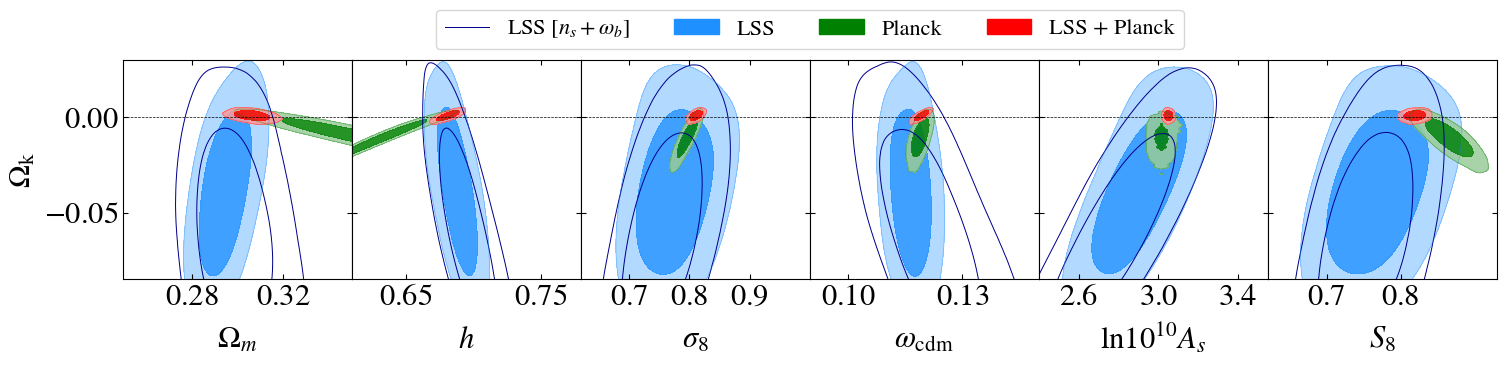

In [85]:
rec.rectangle_plot(cosmo,'Ok',
                   roots=[omega_k_ns_plot_chain[0], omega_k_plot_chain[0], planck_omega_k, omega_k_Pl_LSS_plot_chain[0] ],
                   colors=['darkblue','dodgerblue','green','red'],
                   filled=[False,True,True,True],
                   legend_labels=["LSS [$n_s + \omega_b$]", "LSS", "Planck", "LSS + Planck" ],)
rec.subplots[0,0].set_xlim(lim_Om)
rec.subplots[0,1].set_xlim(lim_hub)
rec.subplots[0,2].set_xlim(lim_s8)
rec.subplots[0,3].set_xlim(lim_ocdm)
rec.subplots[0,4].set_xlim(lim_lnAS)
rec.subplots[0,5].set_xlim(lim_S8)
rec.subplots[0,0].set_ylim([-0.085,0.03])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,0])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,1])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,2])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,3])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,4])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,5])

#cosmo_bestfit = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8']
#for j, cj in enumerate(cosmo_bestfit[:]):
#    rec.subplots[0,j].plot(omega_k_bestfit[cj], omega_k_bestfit['Omega_k'], 'x', markersize=15, color="greenyellow")
#    rec.subplots[0,j].plot(omega_k_ns_bestfit[cj], omega_k_ns_bestfit['Omega_k'], '+', markersize=15, color="black")
#   rec.subplots[0,j].plot(omega_k_Pl_LSS_bestfit[cj], omega_k_Pl_LSS_bestfit['Omega_k'], '+', markersize=15, color="lightskyblue")

plt.savefig("Figures/alter_Omegak.pdf", dpi=1000, facecolor='w', bbox_inches='tight')


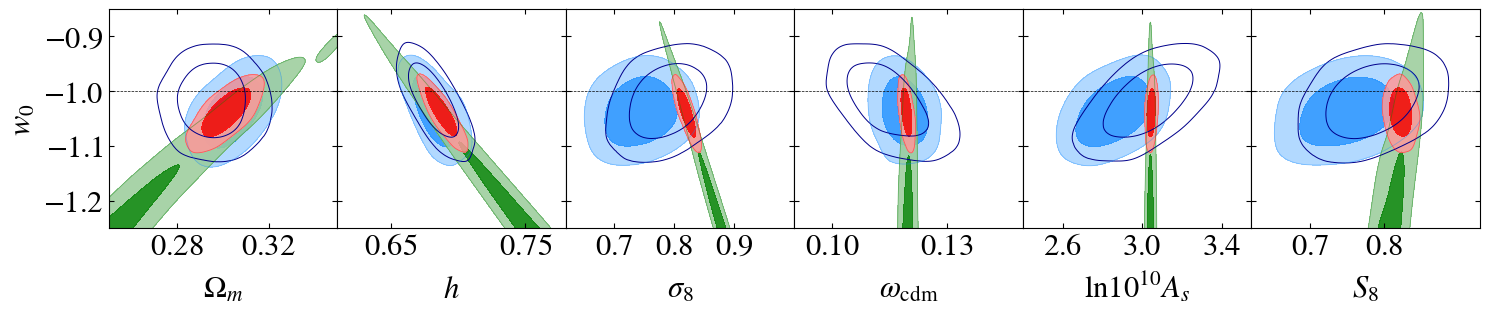

In [86]:
rec.settings.line_labels =False

rec.rectangle_plot(cosmo,'w_de',
                   roots=[w_de_ns_plot_chain[0], w_de_plot_chain[0], planck_w_de, w_de_Pl_LSS_plot_chain[0]],
                   colors=['darkblue','dodgerblue','green','red'],
                   filled=[False,True,True,True],)
rec.subplots[0,0].set_xlim(lim_Om)
rec.subplots[0,1].set_xlim(lim_hub)
rec.subplots[0,2].set_xlim(lim_s8)
rec.subplots[0,3].set_xlim(lim_ocdm)
rec.subplots[0,4].set_xlim(lim_lnAS)
rec.subplots[0,5].set_xlim(lim_S8)
rec.subplots[0,0].set_ylim([-1.25,-0.85])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,0])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,1])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,2])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,3])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,4])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,5])
plt.savefig("Figures/alter_wde.pdf", dpi=1000, facecolor='w', bbox_inches='tight')

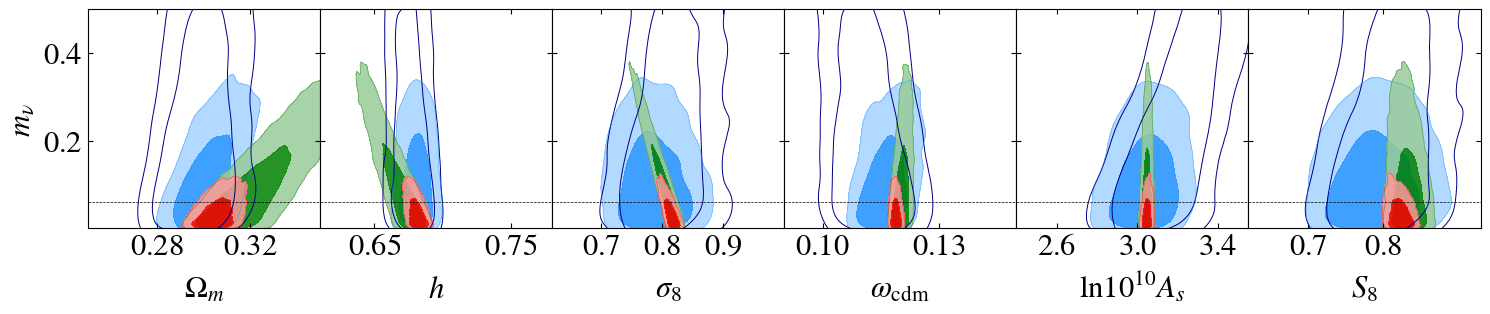

In [87]:
rec.rectangle_plot(cosmo,'M_nu',
                   roots=[Mnu_1_ns_plot_chain[0], Mnu_1_plot_chain[0], planck_Mnu_1, Mnu_1_Pl_LSS_plot_chain[0]],
                   colors=['darkblue','dodgerblue','green','red'],
                   filled=[False,True,True,True],)
rec.subplots[0,0].set_xlim(lim_Om)
rec.subplots[0,1].set_xlim(lim_hub)
rec.subplots[0,2].set_xlim(lim_s8)
rec.subplots[0,3].set_xlim(lim_ocdm)
rec.subplots[0,4].set_xlim(lim_lnAS)
rec.subplots[0,5].set_xlim(lim_S8)
rec.subplots[0,0].set_ylim([0.,0.5])
rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,0])
rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,1])
rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,2])
rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,3])
rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,4])
rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,5])
plt.savefig("Figures/alter_Mnu.pdf", dpi=1000, facecolor='w', bbox_inches='tight')

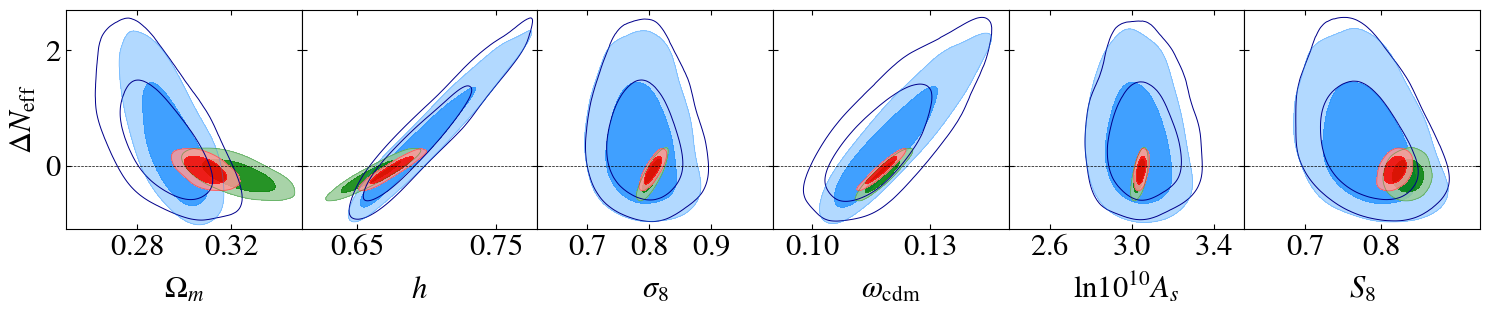

In [88]:
rec.rectangle_plot(cosmo,'N_nu',
                   roots=[Nnu_ns_plot_chain[0], Nnu_plot_chain[0], planck_Nnu, Nnu_Pl_LSS_plot_chain[0]],
                   colors=['darkblue','dodgerblue','green','red'],
                   filled=[False,True,True,True],)
rec.subplots[0,0].set_xlim(lim_Om)
rec.subplots[0,1].set_xlim(lim_hub)
rec.subplots[0,2].set_xlim(lim_s8)
rec.subplots[0,3].set_xlim(lim_ocdm)
rec.subplots[0,4].set_xlim(lim_lnAS)
rec.subplots[0,5].set_xlim(lim_S8)
rec.subplots[0,0].set_ylim([-1.1,2.7])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,0])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,1])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,2])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,3])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,4])
rec.add_y_marker(0,color='k',lw=0.5,ax=[0,5])
plt.savefig("Figures/alter_Neff.pdf", dpi=1000, facecolor='w', bbox_inches='tight')

# BESTFIT MODELES ALTERNATIFS ANNEXES

In [1042]:
basedir = './eBOSS_LCDM_alternative_annexe'

## $w_{\rm DE}$ prior

### eBOSS + BOSS

In [90]:
w_de_prior_chain, w_de_prior_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_prior_220617",],
    [r"LSS + Pan [$w_{\rm DE}$] prior",])

#Bestfit
w_de_prior_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_prior_220617", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_prior_220617")
w_de_prior_bestfit['S8'] = w_de_prior_bestfit['sigma8']*np.sqrt(w_de_prior_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = w_de_prior_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
w_de_prior_chain[0].addDerived(w_de_prior_chain[0].getParams().w0_fld, name='w', range=[-1, 0], label=r'w_0')
print(w_de_prior_chain[0].getInlineLatex('w',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','w0_fld']
w_de_prior_error = get_errors(w_de_prior_chain[0],cosmo)
w_de_prior_mean = get_means(w_de_prior_chain[0],cosmo)

#Shift
w_de_prior_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',w_de_prior_bestfit[i])
        w_de_prior_shift[i] = w_de_prior_mean[i] - w_de_prior_bestfit[i]

w_0 < -0.932


### LSS + Planck

In [91]:
w_de_prior_Pl_LSS_chain, w_de_prior_Pl_LSS_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_w_de_prior_220924",],
    [r"LSS + Pan + Planck [$w_{\rm DE}$] prior" ,])

#Bestfit
w_de_prior_Pl_LSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_w_de_prior_220924", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_w_de_prior_220924")
w_de_prior_Pl_LSS_bestfit['S8'] = w_de_prior_Pl_LSS_bestfit['sigma8']*np.sqrt(w_de_prior_Pl_LSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = w_de_prior_Pl_LSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
w_de_prior_Pl_LSS_chain[0].addDerived(w_de_prior_Pl_LSS_chain[0].getParams().w0_fld, name='w', range=[-1, 0], label=r'w_0')
print(w_de_prior_Pl_LSS_chain[0].getInlineLatex('w',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','w0_fld']
w_de_prior_Pl_LSS_error = get_errors(w_de_prior_Pl_LSS_chain[0],cosmo)
w_de_prior_Pl_LSS_mean = get_means(w_de_prior_Pl_LSS_chain[0],cosmo)

#Shift
w_de_prior_Pl_LSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',w_de_prior_Pl_LSS_bestfit[i])
        w_de_prior_Pl_LSS_shift[i] = w_de_prior_Pl_LSS_mean[i] - w_de_prior_Pl_LSS_bestfit[i]

w_0 < -0.965


## $M_{\nu}$  NH

## BOSS

In [115]:
Mnu_woeBOSS_chain, Mnu_woeBOSS_label = load_multi(
    ["LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_220701",],
    [r"LSS + Pan - eBOSS [$M_{\nu}$]",])

#Bestfit
Mnu_woeBOSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_220701", "LCDM_BOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_220701")
Mnu_woeBOSS_bestfit['S8'] = Mnu_woeBOSS_bestfit['sigma8']*np.sqrt(Mnu_woeBOSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Mnu_woeBOSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
Mnu_woeBOSS_chain[0].addDerived(Mnu_woeBOSS_chain[0].getParams().M_tot_NH, name='M_nu', range=[0.06, 1.5], label=r'\Sigma m_\nu')
print(Mnu_woeBOSS_chain[0].getInlineLatex('M_nu',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','M_tot_NH']
Mnu_woeBOSS_error = get_errors(Mnu_woeBOSS_chain[0],cosmo)
Mnu_woeBOSS_mean = get_means(Mnu_woeBOSS_chain[0],cosmo)

#Shift
Mnu_woeBOSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Mnu_woeBOSS_bestfit[i])
        #print(i,':',Mnu_woeBOSS_mean[i])
        Mnu_woeBOSS_shift[i] = Mnu_woeBOSS_mean[i] - Mnu_woeBOSS_bestfit[i]

\Sigma m_\nu < 0.469


### BOSS + eBOSS

In [110]:
Mnu_chain, Mnu_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_220501",],
    [r"LSS + Pan [$M_{\nu}$]",])

#Bestfit
Mnu_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_220501", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_220501")
Mnu_bestfit['S8'] = Mnu_bestfit['sigma8']*np.sqrt(Mnu_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Mnu_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
Mnu_chain[0].addDerived(Mnu_chain[0].getParams().M_tot_NH, name='M_nu', range=[0.06, 1.5], label=r'\Sigma m_\nu')
print(Mnu_chain[0].getInlineLatex('M_nu',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','M_tot_NH']
Mnu_error = get_errors(Mnu_chain[0],cosmo)
Mnu_mean = get_means(Mnu_chain[0],cosmo)

#Shift
Mnu_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Mnu_bestfit[i])
        #print(i,':',Mnu_mean[i])
        Mnu_shift[i] = Mnu_mean[i] - Mnu_bestfit[i]

\Sigma m_\nu < 0.308


### eBOSS + BOSS [$n_s + \omega_b$]

In [111]:
Mnu_ns_chain, Mnu_ns_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_ns_omega_b_220921",],
    [r"LSS + Pan [$M_{\nu}$] [$n_s + \omega_b$]",])

#Bestfit
Mnu_ns_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_ns_omega_b_220921", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_ns_omega_b_220921")
Mnu_ns_bestfit['S8'] = Mnu_ns_bestfit['sigma8']*np.sqrt(Mnu_ns_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Mnu_ns_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
Mnu_ns_chain[0].addDerived(Mnu_ns_chain[0].getParams().M_tot_NH, name='M_nu', range=[0.06, 1.5], label=r'\Sigma m_\nu')
print(Mnu_ns_chain[0].getInlineLatex('M_nu',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','M_tot_NH']
Mnu_ns_error = get_errors(Mnu_ns_chain[0],cosmo)
Mnu_ns_mean = get_means(Mnu_ns_chain[0],cosmo)

#Shift
Mnu_ns_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Mnu_ns_bestfit[i])
        #print(i,':',Mnu_ns_mean[i])
        Mnu_ns_shift[i] = Mnu_ns_mean[i] - Mnu_ns_bestfit[i]

\Sigma m_\nu < 0.633


In [116]:
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','M_tot_NH']
for i in cosmo:
    #print(i,':', 2*(Mnu_ns_mean[i] - Mnu_mean[i])/(Mnu_ns_error[i] + Mnu_error[i]))
    print(i,':', 2*(Mnu_ns_bestfit[i] - Mnu_bestfit[i])/(Mnu_ns_error[i] + Mnu_error[i]))
    #print(i,':', Mnu_ns_error[i] / Mnu_error[i])

Omega_m : -0.8931361601315851
h : -0.5908135853437232
sigma8 : 0.48859672327472453
omega_cdm : -1.1898527173317057
ln10^{10}A_s : 0.6028922967752974
S8 : 0.17474734624358107
M_tot_NH : 0.0018136391966320105


### LSS + Planck

In [118]:
Mnu_Pl_LSS_chain, Mnu_Pl_LSS_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_nu_220924",],
    [r"LSS + Pan + Planck [$M_{\nu}$]",])

#Bestfit
Mnu_Pl_LSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_nu_220924", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_nu_220924")
Mnu_Pl_LSS_bestfit['S8'] = Mnu_Pl_LSS_bestfit['sigma8']*np.sqrt(Mnu_Pl_LSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Mnu_Pl_LSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
Mnu_Pl_LSS_chain[0].addDerived(Mnu_Pl_LSS_chain[0].getParams().M_tot_NH, name='M_nu', range=[0.06, 1.5], label=r'\Sigma m_\nu')
print(Mnu_Pl_LSS_chain[0].getInlineLatex('M_nu',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','M_tot_NH']
Mnu_Pl_LSS_error = get_errors(Mnu_Pl_LSS_chain[0],cosmo)
Mnu_Pl_LSS_mean = get_means(Mnu_Pl_LSS_chain[0],cosmo)

#Shift
Mnu_Pl_LSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Mnu_Pl_LSS_bestfit[i])
        Mnu_Pl_LSS_shift[i] = Mnu_Pl_LSS_mean[i] - Mnu_Pl_LSS_bestfit[i]

\Sigma m_\nu < 0.134


## $M_{\nu}$ IH

### eBOSS + BOSS

In [1046]:
Mnu_IH_chain, Mnu_IH_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_ih_220609",],
    [r"LSS + Pan [$M_{\nu}$ IH]",])

#Bestfit
Mnu_IH_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_ih_220609", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_ih_220609")
Mnu_IH_bestfit['S8'] = Mnu_IH_bestfit['sigma8']*np.sqrt(Mnu_IH_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Mnu_IH_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
Mnu_IH_chain[0].addDerived(Mnu_IH_chain[0].getParams().M_tot_IH, name='M_nu', range=[0.11, 1.5], label=r'\Sigma m_\nu')
print(Mnu_IH_chain[0].getInlineLatex('M_nu',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','M_tot_IH']
Mnu_IH_error = get_errors(Mnu_IH_chain[0],cosmo)
Mnu_IH_mean = get_means(Mnu_IH_chain[0],cosmo)

#Shift
Mnu_IH_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Mnu_IH_bestfit[i])
        Mnu_IH_shift[i] = Mnu_IH_mean[i] - Mnu_IH_bestfit[i]

\Sigma m_\nu < 0.337


### LSS + Planck

In [1050]:
Mnu_IH_Pl_LSS_chain, Mnu_IH_Pl_LSS_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_nu_ih_220924",],
    [r"LSS + Pan + Planck [$M_{\nu}$ IH]",])

#Bestfit
Mnu_IH_Pl_LSS_bestfit = get_bestfit_from_montepython("minimization_alternative/LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_nu_ih_220924", "LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_nu_ih_220924")
Mnu_IH_Pl_LSS_bestfit['S8'] = Mnu_IH_Pl_LSS_bestfit['sigma8']*np.sqrt(Mnu_IH_Pl_LSS_bestfit['Omega_m']/0.3)

#Mean / 1sigma error
sample = Mnu_IH_Pl_LSS_chain[0]
p=sample.getParams()
sample.addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')
#stats = sample.getMargeStats().parWithName('S8')
#mean, cl68, cl95 = stats.mean, stats.limits[0], stats.limits[1]
#err = np.array([mean-cl68.lower, cl68.upper-mean]).reshape(2,-1)
#print(r'$%.3f^{+%.3f}_{-%.3f}$' % (mean, err[1], err[0]))
Mnu_IH_Pl_LSS_chain[0].addDerived(Mnu_IH_Pl_LSS_chain[0].getParams().M_tot_IH, name='M_nu', range=[0.11, 1.5], label=r'\Sigma m_\nu')
print(Mnu_IH_Pl_LSS_chain[0].getInlineLatex('M_nu',limit=2))
cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s','S8','n_s','M_tot_IH']
Mnu_IH_Pl_LSS_error = get_errors(Mnu_IH_Pl_LSS_chain[0],cosmo)
Mnu_IH_Pl_LSS_mean = get_means(Mnu_IH_Pl_LSS_chain[0],cosmo)

#Shift
Mnu_IH_Pl_LSS_shift = {}
with np.printoptions(precision=4):
    for i in cosmo:
        #print(i,':',Mnu_IH_Pl_LSS_bestfit[i])
        Mnu_IH_Pl_LSS_shift[i] = Mnu_IH_Pl_LSS_mean[i] - Mnu_IH_Pl_LSS_bestfit[i]

\Sigma m_\nu < 0.177


# PLOT ALTERNATIVE ANNEXE

In [99]:
# w_de prior

w_de_prior_plot_chain, w_de_prior_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_w_de_prior_220617",],
    [r"LSS + Pan [$w_{\rm DE}$] prior",])
w_de_prior_Pl_LSS_plot_chain, w_de_prior_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_w_de_prior_220924",],
    [r"LSS + Pan + Planck [$w_{\rm DE}$] prior" ,])

p=w_de_prior_plot_chain[0].getParams()
w_de_prior_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
w_de_prior_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
w_de_prior_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
w_de_prior_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
w_de_prior_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
w_de_prior_plot_chain[0].addDerived(p.w0_fld, name='w_de', label=r'w_0')
w_de_prior_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=w_de_prior_Pl_LSS_plot_chain[0].getParams()
w_de_prior_Pl_LSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
w_de_prior_Pl_LSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
w_de_prior_Pl_LSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
w_de_prior_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
w_de_prior_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
w_de_prior_Pl_LSS_plot_chain[0].addDerived(p.w0_fld, name='w_de', label=r'w_0')
w_de_prior_Pl_LSS_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')


# M_nu NH


Mnu_plot_chain, Mnu_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_220501",],
    [r"LSS + Pan [$M_{\nu}$]",])
Mnu_Pl_LSS_plot_chain, Mnu_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_nu_220924",],
    [r"LSS + Pan + Planck [$M_{\nu}$]",])

p=Mnu_plot_chain[0].getParams()
Mnu_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
Mnu_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
Mnu_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
Mnu_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
Mnu_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
Mnu_plot_chain[0].addDerived(p.M_tot_NH, name='M_NH', label=r'm_{\rm NH}')
Mnu_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=Mnu_Pl_LSS_plot_chain[0].getParams()
Mnu_Pl_LSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
Mnu_Pl_LSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
Mnu_Pl_LSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
Mnu_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
Mnu_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
Mnu_Pl_LSS_plot_chain[0].addDerived(p.M_tot_NH, name='M_NH', label=r'm_{\rm NH}')
Mnu_Pl_LSS_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')


# M_nu IH


Mnu_IH_plot_chain, Mnu_IH_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_data_M_nu_ih_220609",],
    [r"LSS + Pan [$M_{\nu}$ IH]",])
Mnu_IH_Pl_LSS_plot_chain, Mnu_IH_Pl_LSS_plot_label = load_multi(
    ["LCDM_BOSS_eBOSS_BAO_Pan_BAOsmallz_Lyalpha_newPlanck_data_M_nu_ih_220924",],
    [r"LSS + Pan + Planck [$M_{\nu}$ IH]",])

p=Mnu_IH_plot_chain[0].getParams()
Mnu_IH_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
Mnu_IH_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
Mnu_IH_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
Mnu_IH_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
Mnu_IH_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
Mnu_IH_plot_chain[0].addDerived(p.M_tot_IH, name='M_IH', label=r'm_{\rm IH}')
Mnu_IH_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

p=Mnu_IH_Pl_LSS_plot_chain[0].getParams()
Mnu_IH_Pl_LSS_plot_chain[0].addDerived(p.Omega_m, name='Om', label=r'\Omega_m')
Mnu_IH_Pl_LSS_plot_chain[0].addDerived(p.h, name='hub', label=r'h')
Mnu_IH_Pl_LSS_plot_chain[0].addDerived(p.sigma8, name='s8', label=r'\sigma_8')
Mnu_IH_Pl_LSS_plot_chain[0].addDerived(p.omega_cdm, name='ocdm', label=r'\omega_{\rm cdm}')
Mnu_IH_Pl_LSS_plot_chain[0].addDerived(np.log(10**10*p.A_s), name='lnAS', label=r'\ln 10^{10}A_s')
Mnu_IH_Pl_LSS_plot_chain[0].addDerived(p.M_tot_IH, name='M_IH', label=r'm_{\rm IH}')
Mnu_IH_Pl_LSS_plot_chain[0].addDerived(p.sigma8*np.sqrt(p.Omega_m/0.3), name='S8', label=r'S_8')

In [100]:
rec = plots.getSinglePlotter(ratio=1.3,width_inch=15,)
rec.settings.axes_fontsize = 24
rec.settings.lab_fontsize = 24
rec.settings.legend_fontsize = 18


#cosmo = ['Omega_m','h','sigma8','omega_cdm','ln10^{10}A_s',]
cosmo = ['Om', 'hub', 's8', 'ocdm', 'lnAS','S8']
lim_Om = [0.25,0.35]
lim_hub = [0.61,0.78]
lim_s8 = [0.62,1.]
lim_ocdm = [0.09,0.15]
lim_lnAS = [2.4,3.55]
lim_S8 = [0.62, 0.93]

<Figure size 1500x1950 with 0 Axes>

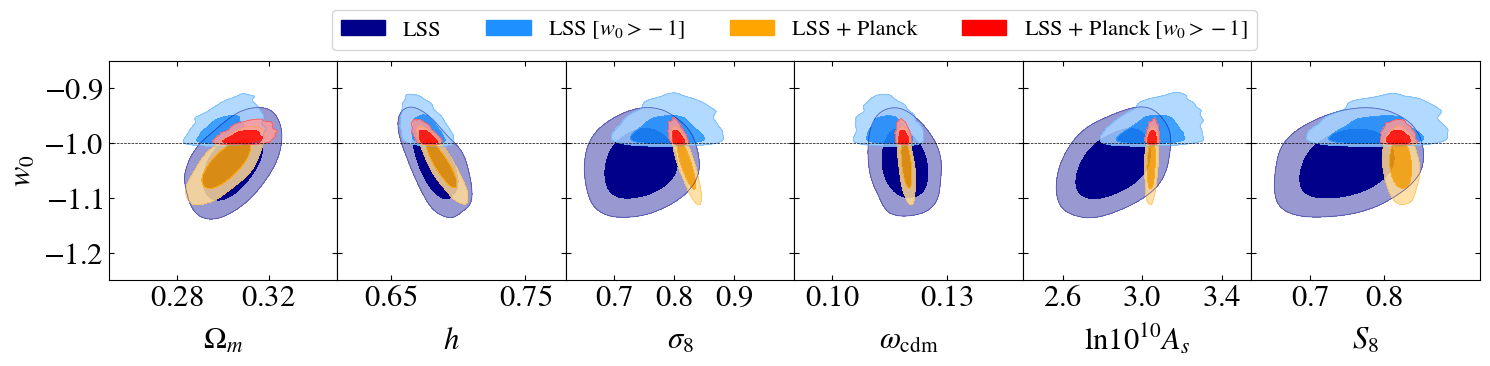

In [101]:
rec.rectangle_plot(cosmo,'w_de',
                   roots=[w_de_plot_chain[0], w_de_prior_plot_chain[0], 
                          w_de_Pl_LSS_plot_chain[0], w_de_prior_Pl_LSS_plot_chain[0]],
                   colors=['darkblue','dodgerblue','orange','red'],
                   filled=[True,True,True,True],
                   legend_labels=["LSS", "LSS [$w_0 > -1$]", 
                                  "LSS + Planck",  "LSS + Planck [$w_0 > -1$]"],)
rec.subplots[0,0].set_xlim(lim_Om)
rec.subplots[0,1].set_xlim(lim_hub)
rec.subplots[0,2].set_xlim(lim_s8)
rec.subplots[0,3].set_xlim(lim_ocdm)
rec.subplots[0,4].set_xlim(lim_lnAS)
rec.subplots[0,5].set_xlim(lim_S8)
rec.subplots[0,0].set_ylim([-1.25,-0.85])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,0])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,1])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,2])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,3])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,4])
rec.add_y_marker(-1,color='k',lw=0.5,ax=[0,5])
plt.savefig("Figures/alter_wde_prior.pdf", dpi=1000, facecolor='w', bbox_inches='tight')

(0.06, 0.41)

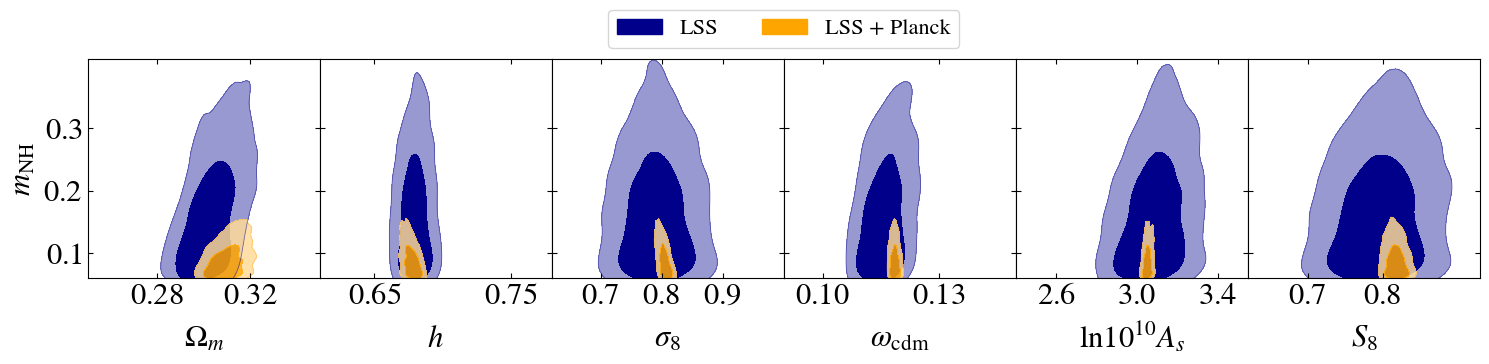

In [102]:
rec.rectangle_plot(cosmo,'M_NH',
                   roots=[Mnu_plot_chain[0], Mnu_Pl_LSS_plot_chain[0]],
                   colors=['darkblue','orange'],
                   legend_labels=["LSS", "LSS + Planck"],
                   filled=[True,True,True,True],)
rec.subplots[0,0].set_xlim(lim_Om)
rec.subplots[0,1].set_xlim(lim_hub)
rec.subplots[0,2].set_xlim(lim_s8)
rec.subplots[0,3].set_xlim(lim_ocdm)
rec.subplots[0,4].set_xlim(lim_lnAS)
rec.subplots[0,5].set_xlim(lim_S8)
rec.subplots[0,0].set_ylim([0.06,0.41])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,0])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,1])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,2])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,3])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,4])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,5])
#plt.savefig("Figures/alter_Mnu.pdf", dpi=1000, facecolor='w', bbox_inches='tight')

(0.11, 0.43)

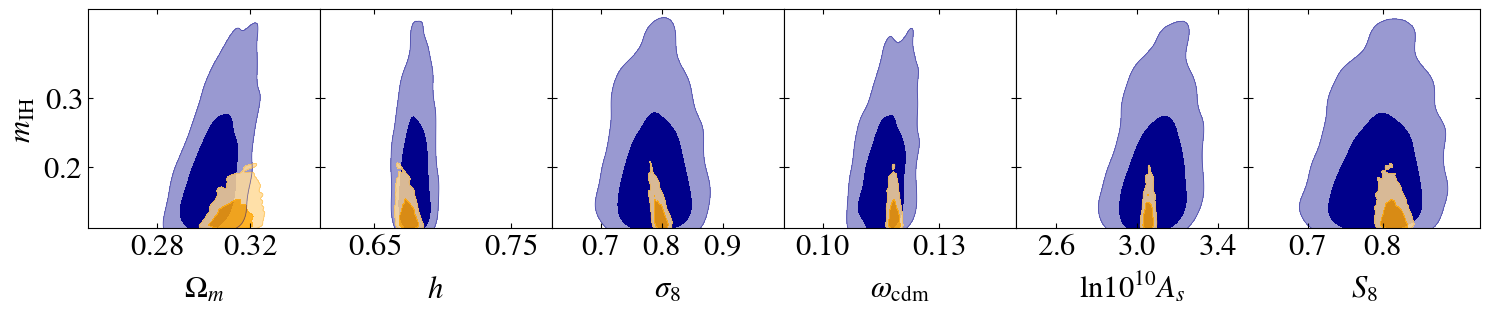

In [103]:
rec.settings.line_labels =False

rec.rectangle_plot(cosmo,'M_IH',
                   roots=[Mnu_IH_plot_chain[0], Mnu_IH_Pl_LSS_plot_chain[0]],
                   colors=['darkblue','orange'],
                   filled=[True,True,True,True],)
rec.subplots[0,0].set_xlim(lim_Om)
rec.subplots[0,1].set_xlim(lim_hub)
rec.subplots[0,2].set_xlim(lim_s8)
rec.subplots[0,3].set_xlim(lim_ocdm)
rec.subplots[0,4].set_xlim(lim_lnAS)
rec.subplots[0,5].set_xlim(lim_S8)
rec.subplots[0,0].set_ylim([0.11,0.43])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,0])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,1])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,2])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,3])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,4])
#rec.add_y_marker(0.06,color='k',lw=0.5,ax=[0,5])
#plt.savefig("Figures/alter_Mnu.pdf", dpi=1000, facecolor='w', bbox_inches='tight')